T. Tarantola, D. Kumaran, P. Dayan, & B. De Martino. (in press) Prior preferences beneficially influence social and non-social learning. Nature Communications.

#Data Analyses

In [48]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import curve_fit
import pylab as pl
import math
import seaborn as sns
import rpy2
import pystan
from pystan.external.pymc import plots
import pickle
from wand.image import Image as WImage

import pandas.rpy.common as com
import rpy2.robjects as ro

# SVG images output text as text, not paths
plt.rcParams['svg.fonttype'] = 'none'

% matplotlib inline
pd.options.display.max_rows = 999 # Set the maximum display to 999 rows so the entire dataframe is visible in the notebook
pd.options.display.max_columns = 999 # Same for columns
np.set_printoptions(threshold='nan')
%load_ext rmagic

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


##Load processed data & add some more convenience variables

Note: Throughout, data from the social experiment are labeled "data" and data from the non-social experiment are labeled "control_data."

In [2]:
data = pd.read_pickle('../data/social/data_processed_social_wexclusions.pkl')
control_data = pd.read_pickle('../data/non_social/data_processed_non_social_wexclusions.pkl')

In [3]:
# Add a variable indicating whether the participant's response during the learning task matches her own preference
# Preference based on whether the participant consistently chose that item (twice out of 2 choices) in the choice task
data.loc[(((data['response_correct']==1)&(data['choice_correct_congruence']==2))|((data['response_correct']==0)&(data['choice_correct_congruence']==0))), 'response_matches_preference'] = 1
data.loc[(((data['response_correct']==1)&(data['choice_correct_congruence']==0))|((data['response_correct']==0)&(data['choice_correct_congruence']==2))), 'response_matches_preference'] = 0
control_data.loc[(((control_data['response_correct']==1)&(control_data['choice_correct_congruence']==2))|((control_data['response_correct']==0)&(control_data['choice_correct_congruence']==0))), 'response_matches_preference'] = 1
control_data.loc[(((control_data['response_correct']==1)&(control_data['choice_correct_congruence']==0))|((control_data['response_correct']==0)&(control_data['choice_correct_congruence']==2))), 'response_matches_preference'] = 0

In [4]:
# Same variable, but -1, 0, or 1; based on how many times the participant chose that item in the choice task
data.loc[(((data['response_correct']==1)&(data['choice_correct_congruence']==2))|((data['response_correct']==0)&(data['choice_correct_congruence']==0))), 'response_matches_preference_signed'] = 1
data.loc[(((data['response_correct']==1)&(data['choice_correct_congruence']==0))|((data['response_correct']==0)&(data['choice_correct_congruence']==2))), 'response_matches_preference_signed'] = -1
data.loc[(data['choice_correct_congruence']==1), 'response_matches_preference_signed'] = 0

control_data.loc[(((control_data['response_correct']==1)&(control_data['choice_correct_congruence']==2))|((control_data['response_correct']==0)&(control_data['choice_correct_congruence']==0))), 'response_matches_preference_signed'] = 1
control_data.loc[(((control_data['response_correct']==1)&(control_data['choice_correct_congruence']==0))|((control_data['response_correct']==0)&(control_data['choice_correct_congruence']==2))), 'response_matches_preference_signed'] = -1
control_data.loc[(control_data['choice_correct_congruence']==1), 'response_matches_preference_signed'] = 0

In [5]:
# Same, but based on whether they bid more for the item than its alternative during the bidding task
data.loc[(((data['response_correct']==1)&(data['inf_bid_dv']>0))|((data['response_correct']==0)&(data['inf_bid_dv']<0))), 'response_matches_preference_bid'] = 1
data.loc[(((data['response_correct']==1)&(data['inf_bid_dv']<0))|((data['response_correct']==0)&(data['inf_bid_dv']>0))), 'response_matches_preference_bid'] = 0
control_data.loc[(((control_data['response_correct']==1)&(control_data['inf_bid_dv']>0))|((control_data['response_correct']==0)&(control_data['inf_bid_dv']<0))), 'response_matches_preference_bid'] = 1
control_data.loc[(((control_data['response_correct']==1)&(control_data['inf_bid_dv']<0))|((control_data['response_correct']==0)&(control_data['inf_bid_dv']>0))), 'response_matches_preference_bid'] = 0

In [6]:
# Same as above, but only if the bid difference is >= 50p
data.loc[(((data['response_correct']==1)&(data['inf_bid_dv']>=0.5))|((data['response_correct']==0)&(data['inf_bid_dv']<=-0.5))), 'response_matches_preference_bid_50p'] = 1
data.loc[(((data['response_correct']==1)&(data['inf_bid_dv']<=-0.5))|((data['response_correct']==0)&(data['inf_bid_dv']>=0.5))), 'response_matches_preference_bid_50p'] = 0
control_data.loc[(((control_data['response_correct']==1)&(control_data['inf_bid_dv']>=0.5))|((control_data['response_correct']==0)&(control_data['inf_bid_dv']<=-0.5))), 'response_matches_preference_bid_50p'] = 1
control_data.loc[(((control_data['response_correct']==1)&(control_data['inf_bid_dv']<=-0.5))|((control_data['response_correct']==0)&(control_data['inf_bid_dv']>=0.5))), 'response_matches_preference_bid_50p'] = 0

In [7]:
#Preference (bid difference) for chosen answer in learning task minus unchosen answer
data.loc[(data['response_correct']==1),'inf_bid_dv_chosen'] = data.loc[(data['response_correct']==1),'inf_bid_dv']
data.loc[(data['response_correct']==0),'inf_bid_dv_chosen'] = -data.loc[(data['response_correct']==0),'inf_bid_dv']
control_data.loc[(control_data['response_correct']==1),'inf_bid_dv_chosen'] = control_data.loc[(control_data['response_correct']==1),'inf_bid_dv']
control_data.loc[(control_data['response_correct']==0),'inf_bid_dv_chosen'] = -control_data.loc[(control_data['response_correct']==0),'inf_bid_dv']

Combined social and non-social control data:

In [8]:
# Concatenate social and control data sets
tojoin = [data,control_data]
data_combined = pd.concat(tojoin)

# Create a dummy variable for "social" group (1=social, 0=control)
data_combined.loc[(data_combined.participant.str[0]=='E'),'social_group'] = 1
data_combined.loc[(data_combined.participant.str[0]=='C'),'social_group'] = 0

# Save data
data_combined.to_csv(path_or_buf=r'../data/combined/data_processed_combined_wexclusions.csv')
data_combined.to_pickle(r'../data/combined/data_processed_combined_wexclusions.pkl')

##Model-agnostic Analyses

First, create a variable indicating whether the feedback on the last presentation of that item pair was correct (=1) or incorrect (=0).

In [9]:
for p in data.participant.unique():
    for t in range(600):
        correct_item = data.loc[((data.participant==p)&(data.learning_trial==t)),'img_correct'].values[0]
        pair_pres = data.loc[((data.participant==p)&(data.learning_trial==t)),'pair_rep'].values[0]
        if pair_pres > 1:
            data.loc[((data.participant==p)&(data.learning_trial==t)),'last_feedback_correct'] = data.loc[((data.participant==p)&(data.img_correct==correct_item)&(data.pair_rep==pair_pres-1)),'feedback_correct'].values[0]
            
for p in control_data.participant.unique():
    for t in range(600):
        correct_item = control_data.loc[((control_data.participant==p)&(control_data.learning_trial==t)),'img_correct'].values[0]
        pair_pres = control_data.loc[((control_data.participant==p)&(control_data.learning_trial==t)),'pair_rep'].values[0]
        if pair_pres > 1:
            control_data.loc[((control_data.participant==p)&(control_data.learning_trial==t)),'last_feedback_correct'] = control_data.loc[((control_data.participant==p)&(control_data.img_correct==correct_item)&(control_data.pair_rep==pair_pres-1)),'feedback_correct'].values[0]

Next, create a signed version of the choice congruence variable:

In [10]:
data.loc[:,'choice_correct_congruence_signed'] = data.loc[:,'choice_correct_congruence'] - 1 
control_data.loc[:,'choice_correct_congruence_signed'] = control_data.loc[:,'choice_correct_congruence'] - 1 

In [11]:
# Load R into the notebook
%reload_ext rmagic
%R library(lme4) 
%Rpush data

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)


These analyses use multi-level regressions, using participant as a random effect, to see whether preference congruence affects correct responses and response times. For correct responses, preference congruence is defined as the difference in bids between the correct and incorrect answers (Supplementary Tables 1, 5, 9, and 13) or as the number of times, out of two, that the participant chose the correct item during the choice task (Supplementary Tables 3, 7, 11, and 15). The "choice" preference congruence measure is coded as 1 (consistently preferred the correct item), 0 (preferred the correct item on one trial but the incorrect item on the other), or -1 (consistently preferred the incorrect item).

For response time analyses, preference congruence was defined in the same way, only using the participant's response on the trial (rather than the correct answer) as the reference point. (I.e. delta v = bid(response) - bid(alternative) rather than bid(correct) - bid(incorrect)). Response times were z-scored by participant.

Each of these analyses was repeated with two additional regressors: (1) whether the feedback presented on the previous presentation of the item pair was correct (1=yes, 0=no), and (2) the number of trials since the previous presentation of the item pair. Because these variables do not exist for the first trials of an item pair, these analyses exclude the first trials.

All analyses are performed for both the social experiment (Supplementary Tables 1-8) and the non-social experiment (Supplementary Tables 9-16). They are also performed separately for the first 10, middle 10, and last 10 trials for each item pair (though with the additional controls, excluding the first trials).

Note that significant P values reported in the text for analyses reflected in Supplementary Tables 1-16 are multiplied by 32 for a conservative Bonferroni correction.

###Supplementary Table 1: Correct responses in the social experiment (bids)

####Trials 1-30

In [75]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data, binomial) 
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), data, binomial) 
print(anova(logitmodel_withchoice,logitmodel_null))
print(summary(logitmodel_withchoice))

Data: data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 9800.6 9824.0 -4897.3   9794.6              
logitmodel_withchoice  4 9606.6 9637.9 -4799.3   9598.6 195.95      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  9606.6   9637.9  -4799.3   9598.6    18596 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.1442   0.1352   0.2152   0.3310   1.4733 

Random effects:
 Gr

####Trials 1-10

In [19]:
data_first10 = data[data.pair_rep<11]
%Rpush data_first10

In [76]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 5316.2 5336.4 -2655.1   5310.2              
logitmodel_withchoice  4 5200.9 5227.9 -2596.5   5192.9 117.26      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: data_first10

     AIC      BIC   logLik deviance df.resid 
  5200.9   5227.9  -2596.5   5192.9     6196 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5155  0.2385  0.3522  0.4802  1.3139 

Random effect

####Trials 11-20

In [23]:
data_middle10 = data[(data.pair_rep>10)&(data.pair_rep<21)]
%Rpush data_middle10

In [77]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 2529.3 2549.6 -1261.7   2523.3              
logitmodel_withchoice  4 2505.9 2532.8 -1249.0   2497.9 25.448      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  4.544e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: data_middle10

     AIC      BIC   logLik deviance df.resid 
  2505.9   2532.8  -1249.0   2497.9     6196 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.1219   0.1248   0.1742   0.2605   0.8957 

R

####Trials 21-30

In [79]:
data_last10 = data[data.pair_rep>20]
%Rpush data_last10

In [80]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 1750.0 1770.2 -872.01   1744.0              
logitmodel_withchoice  4 1682.7 1709.6 -837.32   1674.7 69.369      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: data_last10

     AIC      BIC   logLik deviance df.resid 
  1682.6   1709.6   -837.3   1674.6     6196 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-17.0301   0.0783   0.1165   0.1976   0.8863 

Rando

#### Learning in the last 10 trials? (Social - bids)
Does excluding the trial number hurt the model?

In [82]:
%%R
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), data_last10, binomial)
logitmodel_withchoice_nolearning <- glmer(response_correct ~ 1+inf_bid_dv+(1|participant), data_last10, binomial)
print(anova(logitmodel_withchoice,logitmodel_withchoice_nolearning))

Data: data_last10
Models:
logitmodel_withchoice_nolearning: response_correct ~ 1 + inf_bid_dv + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                                 Df    AIC    BIC  logLik deviance  Chisq
logitmodel_withchoice_nolearning  3 1681.6 1701.8 -837.79   1675.6       
logitmodel_withchoice             4 1682.7 1709.6 -837.32   1674.7 0.9377
                                 Chi Df Pr(>Chisq)
logitmodel_withchoice_nolearning                  
logitmodel_withchoice                 1     0.3329


###Supplementary Table 2: Response times in the social experiment (bids)

####Trials 1-30

In [131]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), data) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 49912 49944 -24952    49904                             
rtmodel_withchoice  5 49763 49802 -24877    49753 151.02      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: data

REML criterion at convergence: 49781.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8664 -0.5788 -0.2076  0.2567 11.4838 

Random effects:
 Groups      Name        Variance  Std.Dev. 
 participant (Intercept) 2.111e-30 1.453e-15
 Residual                8.502e-01 9.221e-01
Number of obs: 18596, groups:  participant, 

####Trials 1-10

In [132]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data_first10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), data_first10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 19699 19726 -9845.7    19691                             
rtmodel_withchoice  5 19605 19638 -9797.3    19595 96.801      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: data_first10

REML criterion at convergence: 19614.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9263 -0.6022 -0.2490  0.2657  9.1635 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.01952  0.1397  
 Residual                1.37273  1.1716  
Number of obs: 6199, groups:  p

####Trials 11-20

In [133]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data_middle10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), data_middle10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 14398 14425 -7195.1    14390                             
rtmodel_withchoice  5 14349 14383 -7169.5    14339 51.124      1  8.669e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: data_middle10

REML criterion at convergence: 14361.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9423 -0.5498 -0.2218  0.2324 12.5744 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.005522 0.07431 
 Residual                0.589087 0.76752 
Number of obs: 6198, groups: 

####Trials 21-30

In [134]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data_last10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), data_last10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 11544 11571 -5768.0    11536                             
rtmodel_withchoice  5 11484 11518 -5737.2    11474 61.479      1  4.474e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: data_last10

REML criterion at convergence: 11497.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0456 -0.5652 -0.2106  0.2720 10.6628 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.01425  0.1194  
 Residual                0.36891  0.6074  
Number of obs: 6199, groups:  par

###Supplementary Table 3: Correct responses in the social experiment (choices)

####Trials 1-30

In [135]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), data, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 9800.6 9824.0 -4897.3   9794.6              
logitmodel_withchoice  4 9509.5 9540.8 -4750.8   9501.5 293.04      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  9509.5   9540.8  -4750.8   9501.5    18596 

Scaled residuals: 
     Min       1Q   Median       3

####Trials 1-10

In [136]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 5316.2 5336.4 -2655.1   5310.2              
logitmodel_withchoice  4 5090.3 5117.3 -2541.2   5082.3 227.84      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: data_first10

     AIC      BIC   logLik deviance df.resid 
  5090.3   5117.3  -2541.2   5082.3     6196 

Scaled residuals: 
    Min      1Q  M

####Trials 11-20

In [137]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 2529.3 2549.6 -1261.7   2523.3              
logitmodel_withchoice  4 2493.4 2520.3 -1242.7   2485.4 37.977      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice   7.16e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: data_middle10

     AIC      BIC   logLik deviance df.resid 
  2493.4   2520.3  -1242.7   2485.4     6196 

Scaled residuals: 
     Min       1

####Trials 21-30

In [138]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 1750.0 1770.2 -872.01   1744.0              
logitmodel_withchoice  4 1708.7 1735.7 -850.37   1700.7 43.283      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  4.738e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: data_last10

     AIC      BIC   logLik deviance df.resid 
  1708.7   1735.7   -850.4   1700.7     6196 

Scaled residuals: 
     Min       1Q   

###Supplementary Table 4: Response times in the social experiment (choices)

####Trials 1-30

In [157]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), data) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 49912 49944 -24952    49904                             
rtmodel_withchoice  5 49794 49833 -24892    49784 120.42      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: data

REML criterion at convergence: 49812.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9293 -0.5800 -0.2062  0.2570 11.5076 

Random effects:
 Groups      Name        Variance  Std.Dev. 
 participant (Intercept) 2.114e-30 1.454e-15
 Residual                8.516e-01 9.228e-01
Number of

####Trials 1-10

In [160]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data_first10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), data_first10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 19699 19726 -9845.7    19691                             
rtmodel_withchoice  5 19612 19646 -9801.0    19602 89.355      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: data_first10

REML criterion at convergence: 19622.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9938 -0.6076 -0.2481  0.2613  9.1887 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.01844  0.1358  
 Residual                1.37467  1.172

####Trials 11-20

In [161]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data_middle10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), data_middle10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 14398 14425 -7195.1    14390                             
rtmodel_withchoice  5 14372 14406 -7181.1    14362 28.008      1  1.208e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: data_middle10

REML criterion at convergence: 14385.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0028 -0.5474 -0.2277  0.2301 12.4264 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.005421 0.07363 
 Residual                0.591330 0.7

####Trials 21-30

In [162]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), data_last10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), data_last10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 11544 11571 -5768.0    11536                             
rtmodel_withchoice  5 11495 11529 -5742.5    11485 50.877      1  9.834e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: data_last10

REML criterion at convergence: 11508.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0488 -0.5678 -0.2036  0.2707 10.6697 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.01344  0.1159  
 Residual                0.36964  0.6080 

###Supplementary Table 5: Correct responses in the social experiment (bids - with add'l controls)

####Trials 2-30

In [143]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), data, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance Chisq Chi Df Pr(>Chisq)
logitmodel_null        5 8650.4 8689.4 -4320.2   8640.4                        
logitmodel_withchoice  6 8523.4 8570.2 -4255.7   8511.4   129      1  < 2.2e-16
                         
logitmodel_null          
logitmodel_withchoice ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  8523.

####Trials 2-10

In [144]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 4215.5 4248.7 -2102.8   4205.5              
logitmodel_withchoice  6 4163.3 4203.0 -2075.6   4151.3 54.276      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  1.742e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: data_first10

     AIC      BIC   logLik devianc

####Trials 11-20

In [145]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 2517.3 2551.0 -1253.7   2507.3              
logitmodel_withchoice  6 2494.3 2534.7 -1241.2   2482.3 25.034      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  5.634e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: data_middle10

     AIC      BIC   logLik devia

####Trials 21-30

In [146]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 1748.7 1782.4 -869.36   1738.7              
logitmodel_withchoice  6 1681.5 1721.9 -834.75   1669.5 69.215      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: data_last10

     AIC      BIC   logLik deviance 

###Supplementary Table 6: Response times in the social experiment (bids - with add'l controls)

####Trials 2-30

In [147]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), data) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 46578 46624 -23283    46566                             
rtmodel_withchoice  7 46410 46464 -23198    46396 169.78      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: data

REML criterion at convergence: 46444.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8658 -0.5633 -0.2106  0.2417 12.1082 

Random effects:
 Groups      Name        Variance  Std.Dev.

####Trials 2-10

In [148]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_first10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), data_first10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 17311 17351 -8649.5    17299                             
rtmodel_withchoice  7 17226 17272 -8605.8    17212 87.411      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: data_first10

REML criterion at convergence: 17248

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8584 -0.5856 -0.2577  0.2355  9.4751 

Random effects:
 Groups      Name        V

####Trials 11-20

In [149]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_middle10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), data_middle10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 14353 14393 -7170.4    14341                             
rtmodel_withchoice  7 14304 14351 -7144.8    14290 51.259      1  8.094e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: data_middle10

REML criterion at convergence: 14330.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8440 -0.5534 -0.2155  0.2393 12.5028 

Random effects:
 Groups      Name     

####Trials 21-30

In [150]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_last10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), data_last10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 11534 11575 -5761.1    11522                             
rtmodel_withchoice  7 11474 11521 -5730.1    11460 61.913      1   3.59e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: data_last10

REML criterion at convergence: 11502.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0432 -0.5617 -0.2097  0.2700 10.7373 

Random effects:
 Groups      Name        V

###Supplementary Table 7: Correct responses in the social experiment (choices - with add'l controls)

####Trials 2-30

In [151]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), data, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 8650.4 8689.4 -4320.2   8640.4              
logitmodel_withchoice  6 8460.2 8507.0 -4224.1   8448.2 192.23      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   Data: data

     A

####Trials 2-10

In [152]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 4215.5 4248.7 -2102.8   4205.5              
logitmodel_withchoice  6 4100.3 4140.1 -2044.2   4088.3 117.22      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   Data: data

####Trials 11-20

In [153]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 2517.3 2551.0 -1253.7   2507.3              
logitmodel_withchoice  6 2481.8 2522.2 -1234.9   2469.8 37.501      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  9.136e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   Data: dat

####Trials 21-30

In [154]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 1748.7 1782.4 -869.36   1738.7              
logitmodel_withchoice  6 1706.8 1747.2 -847.43   1694.8 43.867      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  3.515e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   Data: data_

###Supplementary Table 8: Response times in the social experiment (choices - with add'l controls)

####Trials 2-30

In [163]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), data) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 46578 46624 -23283    46566                             
rtmodel_withchoice  7 46435 46490 -23211    46421 144.51      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: data

REML criterion at convergence: 46470.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9375 -0.5637 -0.2139  0.2423 12.13

####Trials 2-10

In [164]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_first10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), data_first10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 17311 17351 -8649.5    17299                             
rtmodel_withchoice  7 17228 17275 -8607.1    17214 84.825      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: data_first10

REML criterion at convergence: 17251.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9270 -0.5900 -0

####Trials 11-20

In [165]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_middle10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), data_middle10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 14353 14393 -7170.4    14341                             
rtmodel_withchoice  7 14326 14373 -7156.1    14312 28.765      1  8.172e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: data_middle10

REML criterion at convergence: 14353.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9056 -0.5471 

####Trials 21-30

In [166]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), data_last10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), data_last10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 11534 11575 -5761.1    11522                             
rtmodel_withchoice  7 11485 11532 -5735.4    11471 51.312      1   7.88e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: data_last10

REML criterion at convergence: 11513.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0450 -0.5613 -0.2

###Supplementary Table 9: Correct responses in the non-social experiment (bids)

In [30]:
%Rpush control_data

####Trials 1-30

In [83]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), control_data, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
logitmodel_null        3 11624 11647 -5808.9    11618                         
logitmodel_withchoice  4 11448 11479 -5719.9    11440 178.11      1  < 2.2e-16
                         
logitmodel_null          
logitmodel_withchoice ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: control_data

     AIC      BIC   logLik deviance df.resid 
 11447.7  11478.9  -5719.9  11439.7    17996 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-11.3958   0.1596   0.2536   0.3905   1.4893 

Random ef

####Trials 1-10

In [84]:
control_data_first10 = control_data[control_data.pair_rep<11]
%Rpush control_data_first10

In [85]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), control_data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 5928.5 5948.6 -2961.2   5922.5              
logitmodel_withchoice  4 5763.8 5790.6 -2877.9   5755.8 166.71      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: control_data_first10

     AIC      BIC   logLik deviance df.resid 
  5763.8   5790.6  -2877.9   5755.8     5996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4986  0.2105  0.3810  0.5555  1.7225

####Trials 11-20

In [86]:
control_data_middle10 = control_data[(control_data.pair_rep>10)&(control_data.pair_rep<21)]
%Rpush control_data_middle10

In [87]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), control_data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 3141.9 3162.0 -1568.0   3135.9              
logitmodel_withchoice  4 3124.9 3151.7 -1558.4   3116.9 19.041      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  1.279e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: control_data_middle10

     AIC      BIC   logLik deviance df.resid 
  3124.9   3151.7  -1558.4   3116.9     5996 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.1309   0.1584   0.2281   0.3

####Trials 21-30

In [88]:
control_data_last10 = control_data[control_data.pair_rep>20]
%Rpush control_data_last10

In [89]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), control_data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 2215.8 2235.9 -1104.9   2209.8              
logitmodel_withchoice  4 2202.7 2229.4 -1097.3   2194.7 15.156      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  9.896e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: control_data_last10

     AIC      BIC   logLik deviance df.resid 
  2202.7   2229.5  -1097.3   2194.7     5996 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.4370   0.0730   0.1840   0.2761 

####Learning in the last 10 trials? (Non-social - bids)
Does excluding trial number hurt the model?

In [90]:
%%R
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), control_data_last10, binomial)
logitmodel_withchoice_nolearning <- glmer(response_correct ~ 1+inf_bid_dv+(1|participant), control_data_last10, binomial)
print(anova(logitmodel_withchoice,logitmodel_withchoice_nolearning))

Data: control_data_last10
Models:
logitmodel_withchoice_nolearning: response_correct ~ 1 + inf_bid_dv + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                                 Df    AIC    BIC  logLik deviance  Chisq
logitmodel_withchoice_nolearning  3 2201.9 2222.1 -1098.0   2195.9       
logitmodel_withchoice             4 2202.7 2229.4 -1097.3   2194.7 1.2982
                                 Chi Df Pr(>Chisq)
logitmodel_withchoice_nolearning                  
logitmodel_withchoice                 1     0.2545


###Supplementary Table 10: Response times in the non-social experiment (bids)

####Trials 1-30

In [167]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), control_data) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 48971 49002 -24482    48963                             
rtmodel_withchoice  5 48898 48937 -24444    48888 74.619      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: control_data

REML criterion at convergence: 48916.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1702 -0.5692 -0.2281  0.2470 16.9695 

Random effects:
 Groups      Name        Variance  Std.Dev.
 participant (Intercept) 1.905e-30 1.38e-15
 Residual                8.856e-01 9.41e-01
Number of obs: 17999, groups:  

####Trials 1-10

In [169]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data_first10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), control_data_first10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 18344 18370 -9167.8    18336                             
rtmodel_withchoice  5 18287 18320 -9138.3    18277 58.917      1  1.645e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: control_data_first10

REML criterion at convergence: 18295.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7389 -0.6108 -0.2497  0.2908 14.3742 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.05302  0.2303  
 Residual                1.21821  1.1037  
Number of obs: 

####Trials 11-20

In [170]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data_middle10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), control_data_middle10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 14389 14416 -7190.7    14381                             
rtmodel_withchoice  5 14361 14394 -7175.4    14351 30.447      1  3.432e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: control_data_middle10

REML criterion at convergence: 14373.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8789 -0.5750 -0.2505  0.2426 11.4706 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.00795  0.08916 
 Residual                0.63672  0.79795 
Number of obs

####Trials 21-30

In [171]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data_last10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+inf_bid_dv_chosen+(1|participant), control_data_last10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 14273 14300 -7132.6    14265                             
rtmodel_withchoice  5 14263 14296 -7126.5    14253 12.103      1  0.0005033 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + inf_bid_dv_chosen + (1 |  
    participant)
   Data: control_data_last10

REML criterion at convergence: 14274.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6356 -0.5005 -0.2159  0.1958 19.6836 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.02664  0.1632  
 Residual                0.62304  0.7893  
Number of obs: 60

###Supplementary Table 11: Correct responses in the non-social experiment (choices)

####Trials 1-30

In [172]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), control_data, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
logitmodel_null        3 11624 11647 -5808.9    11618                         
logitmodel_withchoice  4 11244 11275 -5618.0    11236 381.77      1  < 2.2e-16
                         
logitmodel_null          
logitmodel_withchoice ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: control_data

     AIC      BIC   logLik deviance df.resid 
 11244.1  11275.3  -5618.0  11236.1    17996 

Scaled residuals: 
     Min       1Q   Medi

####Trials 1-10

In [173]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), control_data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df    AIC    BIC  logLik deviance Chisq Chi Df Pr(>Chisq)
logitmodel_null        3 5928.5 5948.6 -2961.2   5922.5                        
logitmodel_withchoice  4 5690.6 5717.4 -2841.3   5682.6 239.9      1  < 2.2e-16
                         
logitmodel_null          
logitmodel_withchoice ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: control_data_first10

     AIC      BIC   logLik deviance df.resid 
  5690.6   5717.4  -2841.3   5682.6     5996 

Scaled residuals: 
    M

####Trials 11-20

In [174]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), control_data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 3141.9 3162.0 -1568.0   3135.9              
logitmodel_withchoice  4 3040.5 3067.3 -1516.2   3032.5 103.43      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: control_data_middle10

     AIC      BIC   logLik deviance df.resid 
  3040.5   3067.3  -1516.2   3032.5     5996 

Scaled residuals: 


####Trials 21-30

In [175]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), control_data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+choice_correct_congruence_signed+(1|participant), control_data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed + 
logitmodel_withchoice:     (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 2215.8 2235.9 -1104.9   2209.8              
logitmodel_withchoice  4 2165.4 2192.2 -1078.7   2157.4 52.437      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  4.442e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + choice_correct_congruence_signed +  
    (1 | participant)
   Data: control_data_last10

     AIC      BIC   logLik deviance df.resid 
  2165.4   2192.2  -1078.7   2157.4     5996 

Scaled residuals: 
    

###Supplementary Table 12: Response times in the non-social experiment (choices)

####Trials 1-30

In [176]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), control_data) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 48971 49002 -24482    48963                             
rtmodel_withchoice  5 48847 48886 -24418    48837 126.29      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: control_data

REML criterion at convergence: 48865.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2062 -0.5711 -0.2286  0.2495 16.9870 

Random effects:
 Groups      Name        Variance  Std.Dev. 
 participant (Intercept) 1.899e-30 1.378e-15
 Residual                8.830e-01 9.3

####Trials 1-10

In [177]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data_first10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), control_data_first10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 18344 18370 -9167.8    18336                             
rtmodel_withchoice  5 18258 18291 -9123.8    18248 88.067      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: control_data_first10

REML criterion at convergence: 18267.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7833 -0.6071 -0.2502  0.2949 14.3056 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.0528   0.2298  
 Residual              

####Trials 11-20

In [178]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data_middle10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), control_data_middle10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 14389 14416 -7190.7    14381                             
rtmodel_withchoice  5 14346 14380 -7168.2    14336 44.979      1  1.991e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: control_data_middle10

REML criterion at convergence: 14359

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9924 -0.5787 -0.2504  0.2473 11.4112 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.008122 0.09012 
 Residual              

####Trials 21-30

In [179]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+(1|participant), control_data_last10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+response_matches_preference_signed+(1|participant), control_data_last10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed + 
rtmodel_withchoice:     (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        4 14273 14300 -7132.6    14265                             
rtmodel_withchoice  5 14246 14279 -7118.0    14236 29.238      1  6.402e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: 
infer_resp_rt_zscore ~ 1 + pair_rep + response_matches_preference_signed +  
    (1 | participant)
   Data: control_data_last10

REML criterion at convergence: 14257.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5987 -0.5031 -0.2155  0.1993 19.7229 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.02683  0.1638  
 Residual                

###Supplementary Table 13: Correct responses in the non-social experiment (bids - with add'l controls)

####Trials 2-30

In [180]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), control_data, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
logitmodel_null        5 10434 10473 -5212.2    10424                         
logitmodel_withchoice  6 10315 10361 -5151.3    10303 121.88      1  < 2.2e-16
                         
logitmodel_null          
logitmodel_withchoice ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: control_data

     AIC      BIC   logLik deviance df.r

####Trials 2-10

In [181]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), control_data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 4808.1 4841.1 -2399.1   4798.1              
logitmodel_withchoice  6 4713.9 4753.5 -2351.0   4701.9 96.196      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: control_data_first10

     AIC      BIC 

####Trials 11-20

In [182]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), control_data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 3120.7 3154.2 -1555.3   3110.7              
logitmodel_withchoice  6 3103.1 3143.3 -1545.5   3091.1 19.581      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  9.642e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: control_data_middle10

     AIC      BI

####Trials 21-30

In [183]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv+(1|participant), control_data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 2210.8 2244.2 -1100.4   2200.8              
logitmodel_withchoice  6 2197.3 2237.5 -1092.6   2185.3 15.469      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  8.388e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    inf_bid_dv + (1 | participant)
   Data: control_data_last10

     AIC      BIC   

###Supplementary Table 14: Response times in the non-social experiment (bids - with add'l controls)

####Trials 2-30

In [184]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), control_data) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 46831 46878 -23410    46819                             
rtmodel_withchoice  7 46758 46812 -23372    46744 75.098      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: control_data

REML criterion at convergence: 46791.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1568 -0.5629 -0.2307  0.2389 17.2535 

Random effects:
 Groups      Name        Va

####Trials 2-10

In [185]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_first10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), control_data_first10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 16419 16459 -8203.7    16407                             
rtmodel_withchoice  7 16370 16417 -8178.3    16356 50.892      1  9.762e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: control_data_first10

REML criterion at convergence: 16392.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8466 -0.6034 -0.2497  0.2802 14.2772 

Random effects:
 Groups 

####Trials 11-20

In [186]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_middle10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), control_data_middle10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 14370 14410 -7179.0    14358                             
rtmodel_withchoice  7 14341 14388 -7163.5    14327 30.878      1  2.747e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: control_data_middle10

REML criterion at convergence: 14367.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8803 -0.5758 -0.2506  0.2445 11.4086 

Random effects:
 Group

####Trials 21-30

In [187]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_last10) # Model with intercept only
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+inf_bid_dv_chosen+(1|participant), control_data_last10) # Model with bid congruence
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + inf_bid_dv_chosen + (1 | participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 14269 14309 -7128.4    14257                             
rtmodel_withchoice  7 14258 14305 -7122.3    14244 12.322      1  0.0004476 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + inf_bid_dv_chosen + (1 | participant)
   Data: control_data_last10

REML criterion at convergence: 14284.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5874 -0.5064 -0.2134  0.1965 19.7180 

Random effects:
 Groups   

###Supplementary Table 15: Correct responses in the non-social experiment (choices - with add'l controls)

####Trials 2-30

In [116]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), control_data, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
logitmodel_null        5 10434 10473 -5212.2    10424                         
logitmodel_withchoice  6 10158 10205 -5073.0    10146 278.45      1  < 2.2e-16
                         
logitmodel_null          
logitmodel_withchoice ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   Data: control_da

####Trials 2-10

In [188]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_first10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), control_data_first10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 4808.1 4841.1 -2399.1   4798.1              
logitmodel_withchoice  6 4678.8 4718.3 -2333.4   4666.8 131.35      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   Da

####Trials 11-20

In [189]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_middle10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), control_data_middle10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 3120.7 3154.2 -1555.3   3110.7              
logitmodel_withchoice  6 3019.2 3059.4 -1503.6   3007.2 103.43      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   D

####Trials 21-30

In [190]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_last10, binomial) # Model with intercept only
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+last_feedback_correct+interference+choice_correct_congruence_signed+(1|participant), control_data_last10, binomial) # Model with choice congruence
print(anova(logitmodel_withchoice,logitmodel_null)) # Compare choice and null models
print(summary(logitmodel_withchoice))

Data: control_data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_null:     (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + last_feedback_correct + interference + 
logitmodel_withchoice:     choice_correct_congruence_signed + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        5 2210.8 2244.2 -1100.4   2200.8              
logitmodel_withchoice  6 2159.5 2199.7 -1073.7   2147.5 53.294      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  2.872e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + pair_rep + last_feedback_correct + interference +  
    choice_correct_congruence_signed + (1 | participant)
   Dat

###Supplementary Table 16: Response times in the non-social experiment (choices - with add'l controls)

####Trials 2-30

In [191]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data) 
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), control_data)
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 46831 46878 -23410    46819                             
rtmodel_withchoice  7 46709 46763 -23348    46695 123.82      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: control_data

REML criterion at convergence: 46743.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1912 -0.5630 -0.22

####Trials 2-10

In [192]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_first10) 
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), control_data_first10)
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_first10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 16419 16459 -8203.7    16407                             
rtmodel_withchoice  7 16351 16397 -8168.5    16337 70.487      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: control_data_first10

REML criterion at convergence: 16373.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1

####Trials 11-20

In [193]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_middle10) 
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), control_data_middle10)
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_middle10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 14370 14410 -7179.0    14358                             
rtmodel_withchoice  7 14327 14374 -7156.3    14313 45.301      1   1.69e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: control_data_middle10

REML criterion at convergence: 14353.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 


####Trials 21-30

In [194]:
%%R
rtmodel_null <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+(1|participant), control_data_last10) 
rtmodel_withchoice <- glmer(infer_resp_rt_zscore ~ 1+pair_rep+last_feedback_correct+interference+response_matches_preference_signed+(1|participant), control_data_last10)
print(anova(rtmodel_withchoice,rtmodel_null))
print(summary(rtmodel_withchoice))

Data: control_data_last10
Models:
rtmodel_null: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_null:     interference + (1 | participant)
rtmodel_withchoice: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct + 
rtmodel_withchoice:     interference + response_matches_preference_signed + (1 | 
rtmodel_withchoice:     participant)
                   Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
rtmodel_null        6 14269 14309 -7128.4    14257                             
rtmodel_withchoice  7 14241 14288 -7113.6    14227 29.684      1  5.085e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + pair_rep + last_feedback_correct +  
    interference + response_matches_preference_signed + (1 |      participant)
   Data: control_data_last10

REML criterion at convergence: 14267.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5

###Supplementary Table 17: Confound checks
Now we build models to make sure that the number of trials between pair presentations ("interference" or "gap") and the accuracy of feedback ("feedback_correct" or "last feedback") is not predicted by bid congruence.

####Last feedback (social)

In [42]:
%%R 
feedback_correct_model <- glm(last_feedback_correct ~ 1+inf_bid_dv, data=data, family=binomial) # Model with intercept only
print(summary(feedback_correct_model))


Call:
glm(formula = last_feedback_correct ~ 1 + inf_bid_dv, family = binomial, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8094   0.6617   0.6642   0.6655   0.6708  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1.395714   0.019388   71.99   <2e-16 ***
inf_bid_dv  0.008859   0.026087    0.34    0.734    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17905  on 17979  degrees of freedom
Residual deviance: 17905  on 17978  degrees of freedom
  (3968 observations deleted due to missingness)
AIC: 17909

Number of Fisher Scoring iterations: 4



####Gap (social)

In [44]:
%%R 
interference_model <- lm(interference ~ 1+inf_bid_dv, data=data) # Model with intercept only
print(summary(interference_model))


Call:
lm(formula = interference ~ 1 + inf_bid_dv, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.532 -12.501  -4.542   7.509 121.423 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  18.5167     0.1254 147.616   <2e-16 ***
inf_bid_dv    0.0633     0.1686   0.376    0.707    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.21 on 17978 degrees of freedom
  (3968 observations deleted due to missingness)
Multiple R-squared:  7.845e-06,	Adjusted R-squared:  -4.778e-05 
F-statistic: 0.141 on 1 and 17978 DF,  p-value: 0.7073



####Last feedback (non-social)

In [43]:
%%R 
feedback_correct_model <- glm(last_feedback_correct ~ 1+inf_bid_dv, data=control_data, family=binomial) # Model with intercept only
print(summary(feedback_correct_model))


Call:
glm(formula = last_feedback_correct ~ 1 + inf_bid_dv, family = binomial, 
    data = control_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8085   0.6585   0.6585   0.6586   0.6587  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.4182273  0.0193302  73.368   <2e-16 ***
inf_bid_dv  -0.0001695  0.0251693  -0.007    0.995    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17167  on 17399  degrees of freedom
Residual deviance: 17167  on 17398  degrees of freedom
  (3840 observations deleted due to missingness)
AIC: 17171

Number of Fisher Scoring iterations: 4



####Gap (non-social)

In [45]:
%%R 
interference_model <- lm(interference ~ 1+inf_bid_dv, data=control_data) # Model with intercept only
print(summary(interference_model))


Call:
lm(formula = interference ~ 1 + inf_bid_dv, data = control_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.568 -12.514  -4.544   7.480 122.489 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 18.51993    0.12651 146.392   <2e-16 ***
inf_bid_dv   0.05309    0.16473   0.322    0.747    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.52 on 17398 degrees of freedom
  (3840 observations deleted due to missingness)
Multiple R-squared:  5.971e-06,	Adjusted R-squared:  -5.151e-05 
F-statistic: 0.1039 on 1 and 17398 DF,  p-value: 0.7472



Neither "last feedback" nor "gap" is predicted by delta v in either social or non-social experiments.

In [197]:
len(data) - 18600 + (31*20)

3968

In [198]:
len(control_data) - 18000 + (30*20)

3840

In [200]:
18000 - (30*20)

17400

###Item popularity

####First trial performance

Of all participants in the social and control groups, how common were different preferences (measured by BDM bid differences)?

In [14]:
# Concatenate social and control data sets
tojoin = [data,control_data]
data_combined = pd.concat(tojoin)

In [15]:
# Create a dataframe to hold a tally of preferred items
# A separate tally set is recorded for each participant, so that the participant's own preference is not recorded in the tally corresponding to them
data_items = data[data['practice_loop_thisRepN'].isnull()].copy()
items = data_items.bdm_img.unique()
items = items[1:] # Get rid of the single 'nan' in the list
items_tiled = np.tile(items,61) # Make the list 
prefs = pd.DataFrame(items_tiled, columns=['item'])
for i in items_tiled:
    prefs.loc[(prefs.item==i),'other_item'] = data_items.loc[(data_items.choice_left==i)].choice_right.values[0]
prefs.loc[:,'participant'] = np.repeat(data_combined.participant.unique(),40)
prefs.loc[:,'number_prefer_principal'] = np.zeros(40*61)
prefs.loc[:,'number_prefer_control'] = np.zeros(40*61)

In [16]:
# Tally the number of participants who preferred (based on their BDM bids) each item
# SOCIAL GROUP
for i in items:
    for p in data_items.participant.unique():
        if i in data_items[data_items['participant']==p].img_correct.unique(): # If the item was a correct answer for this participant
            if data_items[(data_items['participant']==p) & (data_items['img_correct']==i)].inf_bid_dv.values[0] > 0: # If the participant bid more for the correct than the incorrect item
                prefs.loc[((prefs['item']==i)&(prefs['participant']!=p)),'number_prefer_principal'] += 1 # Increase the tally for this item in all but this participant's tally set
            elif data_items[(data_items['participant']==p) & (data_items['img_correct']==i)].inf_bid_dv.values[0] < 0: # If they didn't prefer the correct item, increase the tally for the wrong item
                partner = data_items.loc[(data_items.choice_left==i)].choice_right.values[0] # Find the other item that's paired with this one
                prefs.loc[((prefs['item']==partner)&(prefs['participant']!=p)),'number_prefer_principal'] += 1

# CONTROL GROUP
data_items = control_data[control_data['practice_loop_thisRepN'].isnull()].copy()
items = data_items.bdm_img.unique()
items = items[1:]
for i in items:
    for p in data_items.participant.unique():
        if i in data_items[data_items['participant']==p].img_correct.unique():
            if data_items[(data_items['participant']==p) & (data_items['img_correct']==i)].inf_bid_dv.values[0] > 0:
                prefs.loc[((prefs['item']==i)&(prefs['participant']!=p)),'number_prefer_control'] += 1
            elif data_items[(data_items['participant']==p) & (data_items['img_correct']==i)].inf_bid_dv.values[0] < 0:
                partner = data_items.loc[(data_items.choice_left==i)].choice_right.values[0]
                prefs.loc[((prefs['item']==partner)&(prefs['participant']!=p)),'number_prefer_control'] += 1

In [17]:
# Add the social tallies to the non-social tallies
prefs.loc[:,'number_prefer_total'] = prefs.loc[:,'number_prefer_principal'] + prefs.loc[:,'number_prefer_control']
# Calculate the total ratio of OTHER participants (60 total) that preferred each item
prefs.loc[:,'ratio_prefer_total'] = prefs.loc[:,'number_prefer_total'] / (len(data.participant.unique()) + len(control_data.participant.unique())-1)

In [18]:
prefs[prefs.ratio_prefer_total>0.9].item.values[0]

'48-twix.png'

In [19]:
prefs[prefs.item=='48-twix.png'].ratio_prefer_total.value_counts()

0.900000    55
0.916667     6
Name: ratio_prefer_total, dtype: int64

In [20]:
prefs_social = prefs[prefs.participant.str[0]=='E']
prefs_control = prefs[prefs.participant.str[0]=='C']

In [21]:
# Merge preference data with main data
data_wpref = pd.merge(data,prefs_social,how='inner',left_on=['participant','img_correct'],right_on=['participant','item'])
data_wpref.loc[:,'ratio_prefer_correct'] = data_wpref.loc[:,'ratio_prefer_total']
data_wpref.drop('ratio_prefer_total', axis=1, inplace=True)
data_wpref = pd.merge(data_wpref,prefs_social,how='outer',left_on=['participant','img_wrong'],right_on=['participant','item'])
data_wpref.loc[:,'ratio_prefer_wrong'] = data_wpref.loc[:,'ratio_prefer_total']

control_data_wpref = pd.merge(control_data,prefs_control,how='inner',left_on=['participant','img_correct'],right_on=['participant','item'])
control_data_wpref.loc[:,'ratio_prefer_correct'] = control_data_wpref.loc[:,'ratio_prefer_total']
control_data_wpref.drop('ratio_prefer_total', axis=1, inplace=True)
control_data_wpref = pd.merge(control_data_wpref,prefs_control,how='outer',left_on=['participant','img_wrong'],right_on=['participant','item'])
control_data_wpref.loc[:,'ratio_prefer_wrong'] = control_data_wpref.loc[:,'ratio_prefer_total']

In [22]:
data_wpref.participant.unique()

array(['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18',
       'E19', 'E2', 'E20', 'E21', 'E22', 'E23', 'E24', 'E26', 'E27', 'E28',
       'E29', 'E3', 'E31', 'E32', 'E33', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9'], dtype=object)

In [23]:
# Create variable indicating the popularity of the chosen item (social group)
data_wpref.loc[(data_wpref['response_correct']==1),'ratio_prefer_response'] =data_wpref.loc[(data_wpref['response_correct']==1),'ratio_prefer_correct']
data_wpref.loc[(data_wpref['response_correct']==0),'ratio_prefer_response'] =data_wpref.loc[(data_wpref['response_correct']==0),'ratio_prefer_wrong']

# Create variable indicating the popularity of the chosen item (control group)
control_data_wpref.loc[(control_data_wpref['response_correct']==1),'ratio_prefer_response'] =control_data_wpref.loc[(control_data_wpref['response_correct']==1),'ratio_prefer_correct']
control_data_wpref.loc[(control_data_wpref['response_correct']==0),'ratio_prefer_response'] =control_data_wpref.loc[(control_data_wpref['response_correct']==0),'ratio_prefer_wrong']

In [24]:
# Create variable indicating the popularity of the subject's preferred item (social group)
data_wpref.loc[((data_wpref['response_correct']==1)&(data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_preference'] =data_wpref.loc[((data_wpref['response_correct']==1)&(data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_correct']
data_wpref.loc[((data_wpref['response_correct']==1)&(data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_preference'] =data_wpref.loc[((data_wpref['response_correct']==1)&(data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_wrong']
data_wpref.loc[((data_wpref['response_correct']==0)&(data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_preference'] =data_wpref.loc[((data_wpref['response_correct']==0)&(data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_wrong']
data_wpref.loc[((data_wpref['response_correct']==0)&(data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_preference'] =data_wpref.loc[((data_wpref['response_correct']==0)&(data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_correct']

# Create variable indicating the popularity of the subject's preferred item (control group)
control_data_wpref.loc[((control_data_wpref['response_correct']==1)&(control_data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_preference'] =control_data_wpref.loc[((control_data_wpref['response_correct']==1)&(control_data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_correct']
control_data_wpref.loc[((control_data_wpref['response_correct']==1)&(control_data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_preference'] =control_data_wpref.loc[((control_data_wpref['response_correct']==1)&(control_data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_wrong']
control_data_wpref.loc[((control_data_wpref['response_correct']==0)&(control_data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_preference'] =control_data_wpref.loc[((control_data_wpref['response_correct']==0)&(control_data_wpref['response_matches_preference_bid']==1)),'ratio_prefer_wrong']
control_data_wpref.loc[((control_data_wpref['response_correct']==0)&(control_data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_preference'] =control_data_wpref.loc[((control_data_wpref['response_correct']==0)&(control_data_wpref['response_matches_preference_bid']==0)),'ratio_prefer_correct']

In [25]:
data_wpref[['img_correct','response_correct','response_matches_preference_bid','ratio_prefer_correct','ratio_prefer_wrong','ratio_prefer_response','ratio_prefer_preference','inf_bid_dv_chosen']].head(100)

,img_correct,response_correct,response_matches_preference_bid,ratio_prefer_correct,ratio_prefer_wrong,ratio_prefer_response,ratio_prefer_preference,inf_bid_dv_chosen
0,1-treacle_cookies.png,1,1,0.766667,0.216667,0.766667,0.766667,0.30
1,1-treacle_cookies.png,1,1,0.766667,0.216667,0.766667,0.766667,0.30
2,1-treacle_cookies.png,0,0,0.766667,0.216667,0.216667,0.766667,-0.30
3,1-treacle_cookies.png,1,1,0.766667,0.216667,0.766667,0.766667,0.30
4,1-treacle_cookies.png,1,1,0.766667,0.216667,0.766667,0.766667,0.30
5,1-treacle_cookies.png,1,1,0.766667,0.216667,0.766667,0.766667,0.30
6,1-treacle_cookies.png,0,0,0.766667,0.216667,0.216667,0.766667,-0.30
7,1-treacle_cookies.png,1,1,0.766667,0.216667,0.766667,0.766667,0.30
8,1-treacle_cookies.png,1,1,0.766667,0.216667,0.766667,0.766667,0.30
9,1-treacle_cookies.png,0,0,0.766667,0.216667,0.216667,0.766667,-0.30


In [26]:
# Save data with item popularity data
data_wpref.to_pickle(r'../data/social/data_processed_social_wexclusions_wpopularity.pkl')
control_data_wpref.to_pickle(r'../data/non_social/data_processed_non_social_wexclusions_wpopularity.pkl')

In [27]:
data_wpref = pd.read_pickle(r'../data/social/data_processed_social_wexclusions_wpopularity.pkl')
control_data_wpref = pd.read_pickle(r'../data/non_social/data_processed_non_social_wexclusions_wpopularity.pkl')

In [28]:
data_wpref.participant.unique()

array(['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18',
       'E19', 'E2', 'E20', 'E21', 'E22', 'E23', 'E24', 'E26', 'E27', 'E28',
       'E29', 'E3', 'E31', 'E32', 'E33', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9'], dtype=object)

In [29]:
data_wpref.loc[(data_wpref.inf_bid_dv>0),'inf_bid_dv_pos'] = 1
data_wpref.loc[(data_wpref.inf_bid_dv<0),'inf_bid_dv_pos'] = 0
data_wpref.loc[(data_wpref.ratio_prefer_correct>0.5),'correct_popular'] = 1
data_wpref.loc[(data_wpref.ratio_prefer_correct<0.5),'correct_popular'] = 0

control_data_wpref.loc[(control_data_wpref.inf_bid_dv>0),'inf_bid_dv_pos'] = 1
control_data_wpref.loc[(control_data_wpref.inf_bid_dv<0),'inf_bid_dv_pos'] = 0
control_data_wpref.loc[(control_data_wpref.ratio_prefer_correct>0.5),'correct_popular'] = 1
control_data_wpref.loc[(control_data_wpref.ratio_prefer_correct<0.5),'correct_popular'] = 0

In [30]:
data_wpref.loc[((data_wpref.img_correct=='10-bounty_redo.png')|(data_wpref.img_correct=='4-corn.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='13-mccoys_steak_crisps.png')|(data_wpref.img_correct=='3-ellas_strawberries_apples.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='18-mms.png')|(data_wpref.img_correct=='43-mrporky_pork_crackles_redo.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='19-caramello_redo.png')|(data_wpref.img_correct=='30-spaghetti_hoops.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='2-steamed_puddings.png')|(data_wpref.img_correct=='20-fruit_pastilles.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='21-nakd_banana_crunch.png')|(data_wpref.img_correct=='1-treacle_cookies.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='22-daim.png')|(data_wpref.img_correct=='7-olives.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='23-crunchie_redo.png')|(data_wpref.img_correct=='33-ambrosia_rice.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='27-hartleys_raspberries_jelly.png')|(data_wpref.img_correct=='51-mars.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='31-hobnobs.png')|(data_wpref.img_correct=='25-kitkat.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='35-raisins.png')|(data_wpref.img_correct=='49-yorkie.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='36-fig_rolls.png')|(data_wpref.img_correct=='34-hula_hoops_bbq_beef_redo.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='42-mrkipling_lemon_slices.png')|(data_wpref.img_correct=='16-skips_prawn.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='44-crunch.png')|(data_wpref.img_correct=='26-walkers_smoky_bacon.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='45-chewy_nougat_redo.png')|(data_wpref.img_correct=='41-peanuts_redo.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='46-pistachios.png')|(data_wpref.img_correct=='29-beans.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='48-twix.png')|(data_wpref.img_correct=='50-polo.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='5-pineapple.png')|(data_wpref.img_correct=='40-sardines.png')),'correct_controversial'] = 1
data_wpref.loc[((data_wpref.img_correct=='6-sour_patch_kids.png')|(data_wpref.img_correct=='38-maltesers.png')),'correct_controversial'] = 0
data_wpref.loc[((data_wpref.img_correct=='8-liquorice_catherine_wheels.png')|(data_wpref.img_correct=='17-jacobs_mini_cheddars_redo.png')),'correct_controversial'] = 0

In [31]:
control_data_wpref.loc[((control_data_wpref.img_correct=='10-bounty_redo.png')|(control_data_wpref.img_correct=='4-corn.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='13-mccoys_steak_crisps.png')|(control_data_wpref.img_correct=='3-ellas_strawberries_apples.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='18-mms.png')|(control_data_wpref.img_correct=='43-mrporky_pork_crackles_redo.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='19-caramello_redo.png')|(control_data_wpref.img_correct=='30-spaghetti_hoops.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='2-steamed_puddings.png')|(control_data_wpref.img_correct=='20-fruit_pastilles.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='21-nakd_banana_crunch.png')|(control_data_wpref.img_correct=='1-treacle_cookies.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='22-daim.png')|(control_data_wpref.img_correct=='7-olives.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='23-crunchie_redo.png')|(control_data_wpref.img_correct=='33-ambrosia_rice.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='27-hartleys_raspberries_jelly.png')|(control_data_wpref.img_correct=='51-mars.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='31-hobnobs.png')|(control_data_wpref.img_correct=='25-kitkat.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='35-raisins.png')|(control_data_wpref.img_correct=='49-yorkie.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='36-fig_rolls.png')|(control_data_wpref.img_correct=='34-hula_hoops_bbq_beef_redo.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='42-mrkipling_lemon_slices.png')|(control_data_wpref.img_correct=='16-skips_prawn.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='44-crunch.png')|(control_data_wpref.img_correct=='26-walkers_smoky_bacon.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='45-chewy_nougat_redo.png')|(control_data_wpref.img_correct=='41-peanuts_redo.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='46-pistachios.png')|(control_data_wpref.img_correct=='29-beans.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='48-twix.png')|(control_data_wpref.img_correct=='50-polo.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='5-pineapple.png')|(control_data_wpref.img_correct=='40-sardines.png')),'correct_controversial'] = 1
control_data_wpref.loc[((control_data_wpref.img_correct=='6-sour_patch_kids.png')|(control_data_wpref.img_correct=='38-maltesers.png')),'correct_controversial'] = 0
control_data_wpref.loc[((control_data_wpref.img_correct=='8-liquorice_catherine_wheels.png')|(control_data_wpref.img_correct=='17-jacobs_mini_cheddars_redo.png')),'correct_controversial'] = 0

###Figure 3: Performance on first trials for each item pair, separated by preference congruence and item popularity

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


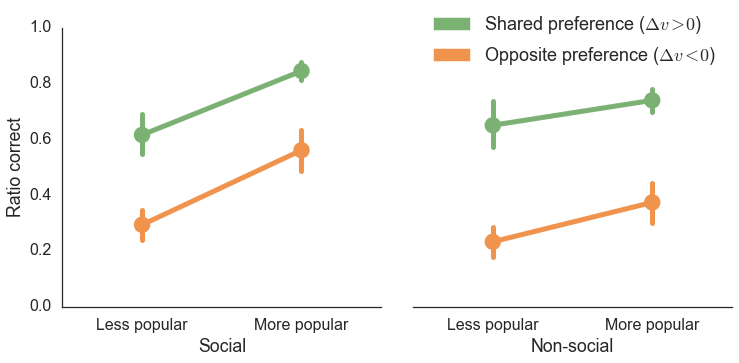

In [32]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

clrs=[sns.xkcd_rgb['faded orange'],sns.xkcd_rgb['faded green']]
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=data_wpref[data_wpref.pair_rep==1], units='participant',palette=clrs, saturation=1, ci=68)
plt.xticks((0,1),('Less popular','More popular'))
plt.xlabel('Social')
plt.ylim(0,1)
plt.legend(labels=(' ',' '), loc=2)
plt.ylabel(('Ratio correct'))
leg = ax1.get_legend()
leg.legendHandles[0].set_color('white')
leg.legendHandles[1].set_color('white')


ax2 = plt.subplot(122, sharey=ax1)
sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=control_data_wpref[control_data_wpref.pair_rep==1], units='participant', palette=clrs, saturation=1, ci=68)
plt.xticks((0,1),('Less popular','More popular'))
plt.xlabel('Non-social')
plt.ylim(0,1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yaxis(), visible=False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Opposite preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
plt.legend(bbox_to_anchor=(1,0.8),handles=[con_patch, in_patch], loc=4, fontsize=18)
sns.despine()
ax2.spines['left'].set_visible(False)
plt.subplots_adjust(wspace=0.1)
plt.savefig('../figures/fig3-first_trials_prefcong.eps', bbox_inches='tight')

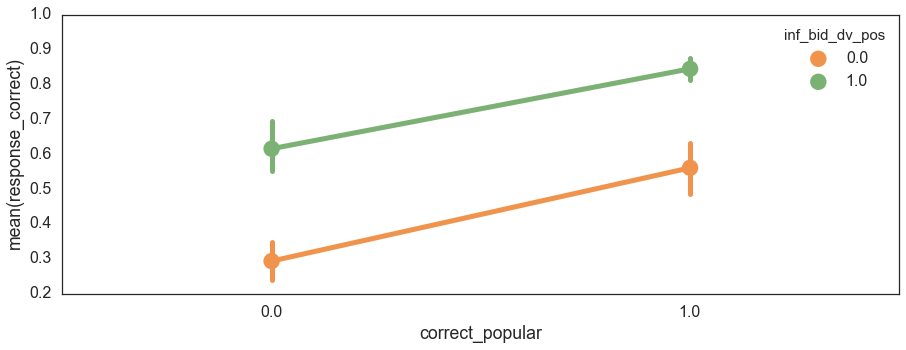

In [424]:
social_line_data = sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=data_wpref[data_wpref.pair_rep==1], units='participant',palette=clrs, saturation=1, ci=68).get_lines()


In [425]:
for i in range(len(social_line_data)):
    print social_line_data[i].get_data()

(array([ 0.,  1.]), array([ 0.29323308,  0.56060606]))
(array([ 0.,  0.]), array([ 0.23880597,  0.34886218]))
(array([ 1.,  1.]), array([ 0.48484848,  0.63157895]))
(array([ 0.,  1.]), array([ 0.61538462,  0.84452297]))
(array([ 0.,  0.]), array([ 0.55156422,  0.69512195]))
(array([ 1.,  1.]), array([ 0.81202313,  0.87593985]))


(array([ 0.,  1.]), array([ 0.23239437,  0.37349398]))
(array([ 0.,  0.]), array([ 0.17448416,  0.29007634]))
(array([ 1.,  1.]), array([ 0.29983505,  0.44569918]))
(array([ 0.,  1.]), array([ 0.65      ,  0.73929961]))
(array([ 0.,  0.]), array([ 0.56708458,  0.73214286]))
(array([ 1.,  1.]), array([ 0.69954298,  0.78180952]))


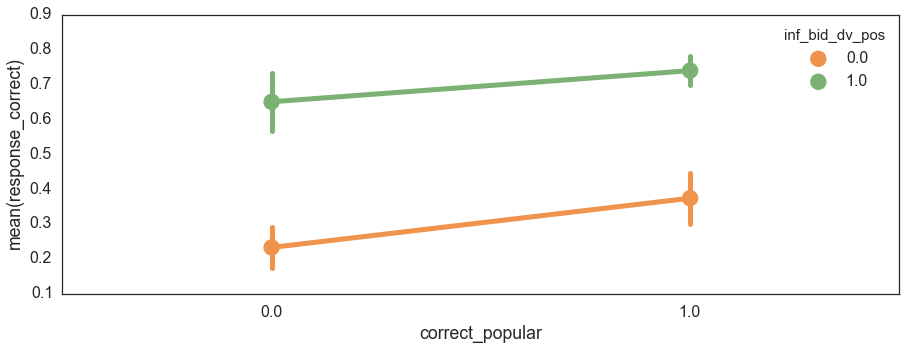

In [427]:
non_social_line_data = sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=control_data_wpref[control_data_wpref.pair_rep==1], units='participant',palette=clrs, saturation=1, ci=68).get_lines()
for i in range(len(non_social_line_data)):
    print non_social_line_data[i].get_data()

In [428]:
print "NON-SOCIAL"
print "Incong, unpopular bar: ", (0.29007634 - 0.17448416), " around 0.23239437"
print "Incong, popular bar: ", (0.44569918 - 0.29983505), " around 0.37349398"
print "Cong, unpopular bar: ", (0.73214286 - 0.56708458), " around 0.65"
print "Cong, popular bar: ", (0.78180952 - 0.69954298), " around 0.73929961"

NON-SOCIAL
Incong, unpopular bar:  0.11559218  around 0.23239437
Incong, popular bar:  0.14586413  around 0.37349398
Cong, unpopular bar:  0.16505828  around 0.65
Cong, popular bar:  0.08226654  around 0.73929961


In [426]:
print "SOCIAL"
print "Incong, unpopular bar: ", (0.34886218 - 0.23880597), " around 0.29323308"
print "Incong, popular bar: ", (0.63157895 - 0.48484848), " around 0.56060606"
print "Cong, unpopular bar: ", (0.69512195 - 0.55156422), " around 0.61538462"
print "Cong, popular bar: ", (0.87593985 - 0.81202313), " around 0.84452297"

SOCIAL
Incong, unpopular bar:  0.11005621  around 0.29323308
Incong, popular bar:  0.14673047  around 0.56060606
Cong, unpopular bar:  0.14355773  around 0.61538462
Cong, popular bar:  0.06391672  around 0.84452297


In [429]:
#Half of the largest and smallest error bar range
print (0.06391672 / 2.0), " to ", (0.16505828 / 2.0)

0.03195836  to  0.08252914


In [421]:
data_wpref[data_wpref.pair_rep==1].inf_bid_dv_pos.value_counts()

1    361
0    222
Name: inf_bid_dv_pos, dtype: int64

In [407]:
data_wpref[data_wpref.pair_rep==1].correct_popular.value_counts()

1    372
0    223
Name: correct_popular, dtype: int64

In [422]:
control_data_wpref[control_data_wpref.pair_rep==1].inf_bid_dv_pos.value_counts()

1    317
0    249
Name: inf_bid_dv_pos, dtype: int64

In [423]:
control_data_wpref[control_data_wpref.pair_rep==1].correct_popular.value_counts()

1    365
0    211
Name: correct_popular, dtype: int64

In [420]:
data_wpref[(data_wpref.pair_rep==1)&(data_wpref.correct_popular.isnull())][['participant','img_correct']]

,participant,img_correct
1830,E12,10-bounty_redo.png
2430,E13,10-bounty_redo.png
2730,E13,35-raisins.png
2970,E13,7-olives.png
3840,E15,35-raisins.png
4140,E15,7-olives.png
6570,E19,7-olives.png
6870,E2,35-raisins.png
7830,E21,10-bounty_redo.png
8970,E22,7-olives.png


###Supplementary Figure 1: Performance on first trials for each item pair, separated by preference congruence and item popularity

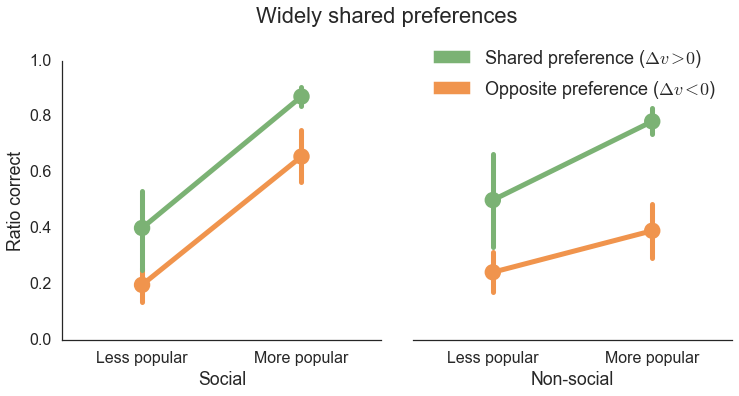

In [65]:
# UNCONTROVERSIAL
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

clrs=[sns.xkcd_rgb['faded orange'],sns.xkcd_rgb['faded green']]
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=data_wpref[(data_wpref.pair_rep==1)&(data_wpref.correct_controversial==0)], units='participant',palette=clrs, saturation=1, ci=68)
plt.xticks((0,1),('Less popular','More popular'))
plt.xlabel('Social')
plt.ylim(0,1)
plt.legend(labels=(' ',' '), loc=2)
plt.ylabel(('Ratio correct'))
leg = ax1.get_legend()
leg.legendHandles[0].set_color('white')
leg.legendHandles[1].set_color('white')


ax2 = plt.subplot(122, sharey=ax1)
sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=control_data_wpref[(control_data_wpref.pair_rep==1)&(control_data_wpref.correct_controversial==0)], units='participant', palette=clrs, saturation=1, ci=68)
plt.xticks((0,1),('Less popular','More popular'))
plt.xlabel('Non-social')
plt.ylim(0,1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yaxis(), visible=False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Opposite preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
plt.legend(bbox_to_anchor=(1,0.8),handles=[con_patch, in_patch], loc=4, fontsize=18)
sns.despine()
ax2.spines['left'].set_visible(False)
plt.subplots_adjust(wspace=0.1)

plt.suptitle('Widely shared preferences', size=22, y=1.05)

plt.savefig('../figures/supp-fig1a-first_trials_prefcong_uncontroversial.pdf', bbox_inches='tight')

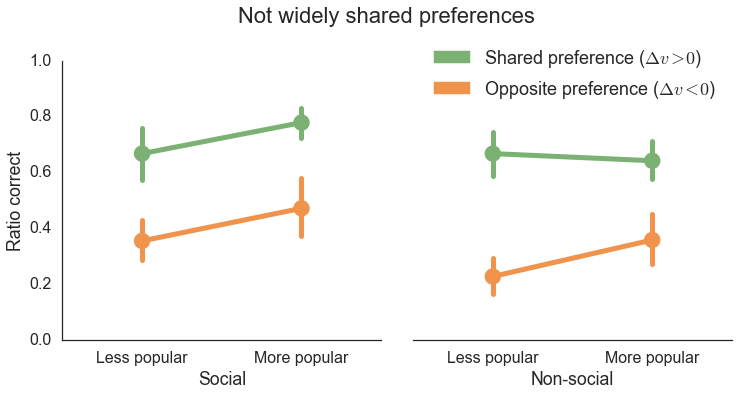

In [66]:
# CONTROVERSIAL
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

clrs=[sns.xkcd_rgb['faded orange'],sns.xkcd_rgb['faded green']]
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=data_wpref[(data_wpref.pair_rep==1)&(data_wpref.correct_controversial==1)], units='participant',palette=clrs, saturation=1, ci=68)
plt.xticks((0,1),('Less popular','More popular'))
plt.xlabel('Social')
plt.ylim(0,1)
plt.legend(labels=(' ',' '), loc=2)
plt.ylabel(('Ratio correct'))
leg = ax1.get_legend()
leg.legendHandles[0].set_color('white')
leg.legendHandles[1].set_color('white')


ax2 = plt.subplot(122, sharey=ax1)
sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=control_data_wpref[(control_data_wpref.pair_rep==1)&(control_data_wpref.correct_controversial==1)], units='participant', palette=clrs, saturation=1, ci=68)
plt.xticks((0,1),('Less popular','More popular'))
plt.xlabel('Non-social')
plt.ylim(0,1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yaxis(), visible=False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Opposite preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
plt.legend(bbox_to_anchor=(1,0.8),handles=[con_patch, in_patch], loc=4, fontsize=18)
sns.despine()
ax2.spines['left'].set_visible(False)
plt.subplots_adjust(wspace=0.1)

plt.suptitle('Not widely shared preferences', size=22, y=1.05)

plt.savefig('../figures/supp-fig1b-first_trials_prefcong_controversial.pdf', bbox_inches='tight')

In [434]:
data_wpref[(data_wpref.pair_rep==1)&(data_wpref.correct_controversial==0)].inf_bid_dv_pos.value_counts()

1    217
0     83
Name: inf_bid_dv_pos, dtype: int64

In [435]:
control_data_wpref[(control_data_wpref.pair_rep==1)&(control_data_wpref.correct_controversial==0)].inf_bid_dv_pos.value_counts()

1    185
0     99
Name: inf_bid_dv_pos, dtype: int64

In [433]:
data_wpref[(data_wpref.pair_rep==1)&(data_wpref.correct_controversial==1)].inf_bid_dv_pos.value_counts()

1    144
0    139
Name: inf_bid_dv_pos, dtype: int64

In [436]:
control_data_wpref[(control_data_wpref.pair_rep==1)&(control_data_wpref.correct_controversial==1)].inf_bid_dv_pos.value_counts()

0    150
1    132
Name: inf_bid_dv_pos, dtype: int64

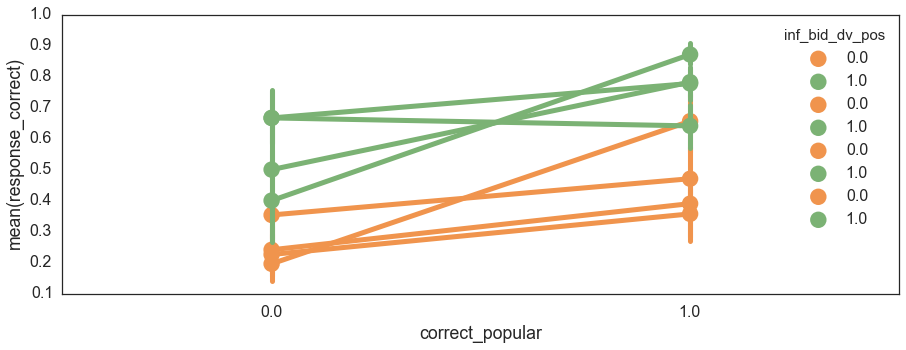

In [437]:
# Calculate error bar ranges
notwide_social_lines = sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=data_wpref[(data_wpref.pair_rep==1)&(data_wpref.correct_controversial==1)], units='participant',palette=clrs, saturation=1, ci=68).get_lines()
notwide_non_social_lines = sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=control_data_wpref[(control_data_wpref.pair_rep==1)&(control_data_wpref.correct_controversial==1)], units='participant', palette=clrs, saturation=1, ci=68).get_lines()
wide_social_lines = sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=data_wpref[(data_wpref.pair_rep==1)&(data_wpref.correct_controversial==0)], units='participant',palette=clrs, saturation=1, ci=68).get_lines()
wide_non_social_lines = sns.pointplot(x='correct_popular',y='response_correct',hue='inf_bid_dv_pos',data=control_data_wpref[(control_data_wpref.pair_rep==1)&(control_data_wpref.correct_controversial==0)], units='participant', palette=clrs, saturation=1, ci=68).get_lines()

In [440]:
for i in range(len(notwide_social_lines)):
    print notwide_social_lines[i].get_data()

(array([ 0.,  1.]), array([ 0.35365854,  0.47058824]))
(array([ 0.,  0.]), array([ 0.28040976,  0.42235897]))
(array([ 1.,  1.]), array([ 0.35483871,  0.57142857]))
(array([ 0.,  1.]), array([ 0.66666667,  0.77777778]))
(array([ 0.,  0.]), array([ 0.58612808,  0.75443893]))
(array([ 1.,  1.]), array([ 0.72368421,  0.83119387]))


In [441]:
for i in range(len(notwide_non_social_lines)):
    print notwide_non_social_lines[i].get_data()

(array([ 0.,  1.]), array([ 0.35365854,  0.47058824]))
(array([ 0.,  0.]), array([ 0.28040976,  0.42235897]))
(array([ 1.,  1.]), array([ 0.35483871,  0.57142857]))
(array([ 0.,  1.]), array([ 0.66666667,  0.77777778]))
(array([ 0.,  0.]), array([ 0.58612808,  0.75443893]))
(array([ 1.,  1.]), array([ 0.72368421,  0.83119387]))
(array([ 0.,  1.]), array([ 0.22619048,  0.35714286]))
(array([ 0.,  0.]), array([ 0.15579798,  0.29213483]))
(array([ 1.,  1.]), array([ 0.26829268,  0.43589744]))
(array([ 0.,  1.]), array([ 0.66666667,  0.64102564]))
(array([ 0.,  0.]), array([ 0.58181818,  0.7551746 ]))
(array([ 1.,  1.]), array([ 0.57116279,  0.70930233]))


In [442]:
for i in range(len(wide_social_lines)):
    print wide_social_lines[i].get_data()

(array([ 0.,  1.]), array([ 0.35365854,  0.47058824]))
(array([ 0.,  0.]), array([ 0.28040976,  0.42235897]))
(array([ 1.,  1.]), array([ 0.35483871,  0.57142857]))
(array([ 0.,  1.]), array([ 0.66666667,  0.77777778]))
(array([ 0.,  0.]), array([ 0.58612808,  0.75443893]))
(array([ 1.,  1.]), array([ 0.72368421,  0.83119387]))
(array([ 0.,  1.]), array([ 0.22619048,  0.35714286]))
(array([ 0.,  0.]), array([ 0.15579798,  0.29213483]))
(array([ 1.,  1.]), array([ 0.26829268,  0.43589744]))
(array([ 0.,  1.]), array([ 0.66666667,  0.64102564]))
(array([ 0.,  0.]), array([ 0.58181818,  0.7551746 ]))
(array([ 1.,  1.]), array([ 0.57116279,  0.70930233]))
(array([ 0.,  1.]), array([ 0.19607843,  0.65625   ]))
(array([ 0.,  0.]), array([ 0.14      ,  0.25531915]))
(array([ 1.,  1.]), array([ 0.55555556,  0.74285714]))
(array([ 0.,  1.]), array([ 0.4       ,  0.87128713]))
(array([ 0.,  0.]), array([ 0.26666667,  0.5625    ]))
(array([ 1.,  1.]), array([ 0.83932162,  0.90783828]))


In [443]:
for i in range(len(wide_non_social_lines)):
    print wide_non_social_lines[i].get_data()

(array([ 0.,  1.]), array([ 0.35365854,  0.47058824]))
(array([ 0.,  0.]), array([ 0.28040976,  0.42235897]))
(array([ 1.,  1.]), array([ 0.35483871,  0.57142857]))
(array([ 0.,  1.]), array([ 0.66666667,  0.77777778]))
(array([ 0.,  0.]), array([ 0.58612808,  0.75443893]))
(array([ 1.,  1.]), array([ 0.72368421,  0.83119387]))
(array([ 0.,  1.]), array([ 0.22619048,  0.35714286]))
(array([ 0.,  0.]), array([ 0.15579798,  0.29213483]))
(array([ 1.,  1.]), array([ 0.26829268,  0.43589744]))
(array([ 0.,  1.]), array([ 0.66666667,  0.64102564]))
(array([ 0.,  0.]), array([ 0.58181818,  0.7551746 ]))
(array([ 1.,  1.]), array([ 0.57116279,  0.70930233]))
(array([ 0.,  1.]), array([ 0.19607843,  0.65625   ]))
(array([ 0.,  0.]), array([ 0.14      ,  0.25531915]))
(array([ 1.,  1.]), array([ 0.55555556,  0.74285714]))
(array([ 0.,  1.]), array([ 0.4       ,  0.87128713]))
(array([ 0.,  0.]), array([ 0.26666667,  0.5625    ]))
(array([ 1.,  1.]), array([ 0.83932162,  0.90783828]))
(array([ 0

In [444]:
error_bars = np.array([(.422-.280), (.571-.355), (.754-.586), (.831-.724), (.292-.156), (.436-.268), (.755-.581), (.709-.571),
                      (.255-.14),(.743-.556),(.563-.267),(.908-.839),(.317-.167),(.488-.282),(.667-.334),(.825-.734)])

In [448]:
error_bars.max() / 2.0

0.16650000000000001

In [447]:
error_bars.min() / 2.0

0.034500000000000031

###Supplementary Table 19: Item pairs and preferences

Mean bid per item:

In [354]:
data_combined.groupby('bdm_img').bdm_bid1_response.mean()

bdm_img
1-treacle_cookies.png                1.375246
10-bounty_redo.png                   0.747377
13-mccoys_steak_crisps.png           0.814262
16-skips_prawn.png                   0.714918
17-jacobs_mini_cheddars_redo.png     0.959016
18-mms.png                           1.313115
19-caramello_redo.png                0.858525
2-steamed_puddings.png               0.886721
20-fruit_pastilles.png               0.632131
21-nakd_banana_crunch.png            0.806721
22-daim.png                          0.843770
23-crunchie_redo.png                 0.804098
25-kitkat.png                        0.952623
26-walkers_smoky_bacon.png           0.730164
27-hartleys_raspberries_jelly.png    0.560656
29-beans.png                         0.647869
3-ellas_strawberries_apples.png      0.597869
30-spaghetti_hoops.png               0.474426
31-hobnobs.png                       1.383115
33-ambrosia_rice.png                 0.594590
34-hula_hoops_bbq_beef_redo.png      0.672951
35-raisins.png            

In [ ]:
data_combined.groupby(['bdm_img').(bdm)

In [222]:
np.array(data.columns)

array(['bdm_img', 'choice_left', 'choice_right', 'img_correct', 'img_left',
       'img_wrong', 'img_right', 'bdm_loop1_thisRepN',
       'bdm_loop1_thisTrialN', 'bdm_loop1_thisN', 'bdm_loop1_thisIndex',
       'binary_thisRepN', 'binary_thisTrialN', 'binary_thisN',
       'binary_thisIndex', 'practice_loop_thisRepN',
       'practice_loop_thisTrialN', 'practice_loop_thisN',
       'practice_loop_thisIndex', 'block_loop_thisRepN',
       'block_loop_thisTrialN', 'block_loop_thisN', 'block_loop_thisIndex',
       'trial_loop_thisRepN', 'trial_loop_thisTrialN', 'trial_loop_thisN',
       'trial_loop_thisIndex', 'instr_main_resp_keys',
       'instr_main_resp_rt', 'instr_bdm_resp_keys',
       'partnered_pilot_participant', 'instr_bdm_resp_rt',
       'bdm_bid1_response', 'bdm_bid1_rt', 'bdm_marker_start',
       'instr_choice_resp_keys', 'instr_choice_resp_rt',
       'key_resp_choice_keys', 'key_resp_choice_rt',
       'confidence_rating1_response', 'confidence_rating1_rt',
       'conf

###Supplementary Table 18: First trial performance

First, we see whether participants in the social group performed significantly better than participants in the control group on the first trial, controlling for their preferences.

In [349]:
# Combine social and control data sets
tojoin = [data_wpref,control_data_wpref]
data_combined_wpref = pd.concat(tojoin)

In [198]:
# Create a dummy variable for "social" group (1=social, 0=control)
data_combined_wpref.loc[(data_combined_wpref.participant.str[0]=='E'),'social_group'] = 1
data_combined_wpref.loc[(data_combined_wpref.participant.str[0]=='C'),'social_group'] = 0

In [200]:
#data_combined_wpref_first = data_combined_wpref[(data_combined_wpref['pair_rep']==1)&(data_combined_wpref['inf_bid_dv']!=0)]
data_combined_wpref_first = data_combined_wpref[(data_combined_wpref['pair_rep']==1)]

%Rpush data_combined_wpref_first
%Rpush data_wpref
%Rpush control_data_wpref

Is first trial performance better in the social group than in the non-social control group?

In [201]:
%%R
first_correct <- glmer(response_correct ~ 1 + inf_bid_dv +(1|participant), data_combined_wpref_first, binomial)
first_correct_group <- glmer(response_correct ~ 1 + inf_bid_dv + social_group + (1|participant), data_combined_wpref_first, binomial)
print(summary(first_correct_group))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + inf_bid_dv + social_group + (1 | participant)
   Data: data_combined_wpref_first

     AIC      BIC   logLik deviance df.resid 
  1397.8   1418.2   -694.9   1389.8     1216 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.7845 -0.8478  0.3879  0.7347  3.8356 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 4e-14    2e-07   
Number of obs: 1220, groups:  participant, 61

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.001162   0.092036  -0.013  0.98993    
inf_bid_dv    1.544532   0.115514  13.371  < 2e-16 ***
social_group  0.381328   0.129884   2.936  0.00333 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) inf_b_
inf_bid_dv  -0.097       
social_grop -0.705  0.026


Next, we see whether the decision, on the first trial, to choose an item incongruent with the participant's preference is predicted by the popularity of that item.

In [202]:
#data_wpref_first = data_wpref[(data_wpref['pair_rep']==1)&(data_wpref['inf_bid_dv']!=0)]
#control_data_wpref_first = control_data_wpref[(control_data_wpref['pair_rep']==1)&(control_data_wpref['inf_bid_dv']!=0)]
data_wpref_first = data_wpref[(data_wpref['pair_rep']==1)]
control_data_wpref_first = control_data_wpref[(control_data_wpref['pair_rep']==1)]
%Rpush data_wpref_first
%Rpush control_data_wpref_first


Is the coefficient for bid congruence different for the social versus control group?

In [77]:
data_wpref_first = data_wpref[(data_wpref['pair_rep']==1)]
control_data_wpref_first = control_data_wpref[(control_data_wpref['pair_rep']==1)]
data_combined_wpref_first = data_combined_wpref[(data_combined_wpref['pair_rep']==1)]

%Rpush data_wpref_first
%Rpush control_data_wpref_first
%Rpush data_combined_wpref_first

In [203]:
%%R
social_wpref <- glmer(response_correct ~ 1 + inf_bid_dv +(1|participant), data_wpref_first, binomial)
control_wpref <- glmer(response_correct ~ 1 + inf_bid_dv +(1|participant), control_data_wpref_first, binomial)
combined_wpref <- glmer(response_correct ~ 1 + inf_bid_dv + social_group + social_group*inf_bid_dv + (1|participant), data_combined_wpref_first, binomial)
print(summary(social_wpref))
print(summary(control_wpref))
print(summary(combined_wpref))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + inf_bid_dv + (1 | participant)
   Data: data_wpref_first

     AIC      BIC   logLik deviance df.resid 
   690.3    703.6   -342.2    684.3      617 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8773 -0.8193  0.4004  0.6938  2.9109 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.02576  0.1605  
Number of obs: 620, groups:  participant, 31

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.37849    0.09813   3.857 0.000115 ***
inf_bid_dv   1.64588    0.17370   9.476  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
inf_bid_dv -0.067
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp

Does popularity improve the fit for the SOCIAL group?

In [699]:
%%R
against_preference_null <- glmer(response_correct ~ 1 + inf_bid_dv +(1|participant), data_wpref_first, binomial)
against_preference_popularity <- glmer(response_correct ~ 1 + inf_bid_dv + ratio_prefer_correct +(1|participant), data_wpref_first, binomial)
print(anova(against_preference_popularity,against_preference_null))
print(summary(against_preference_popularity))

Data: data_wpref_first
Models:
against_preference_null: response_correct ~ 1 + inf_bid_dv + (1 | participant)
against_preference_popularity: response_correct ~ 1 + inf_bid_dv + ratio_prefer_correct + (1 | 
against_preference_popularity:     participant)
                              Df    AIC    BIC  logLik deviance  Chisq Chi Df
against_preference_null        3 641.21 654.32 -317.61   635.21              
against_preference_popularity  4 604.95 622.42 -298.48   596.95 38.263      1
                              Pr(>Chisq)    
against_preference_null                     
against_preference_popularity  6.184e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + inf_bid_dv + ratio_prefer_correct + (1 |  
    participant)
   Data: data_wpref_first

     AIC      BIC   logLik deviance df.resid 
   605.0    622.4   -2

Does item popularity improve the fit for the CONTROL group?

In [698]:
%%R
against_preference_null <- glmer(response_correct ~ 1 + inf_bid_dv +(1|participant), control_data_wpref_first, binomial)
against_preference_popularity <- glmer(response_correct ~ 1 + inf_bid_dv + ratio_prefer_correct +(1|participant), control_data_wpref_first, binomial)
print(anova(against_preference_popularity,against_preference_null))
print(summary(against_preference_popularity))

Data: control_data_wpref_first
Models:
against_preference_null: response_correct ~ 1 + inf_bid_dv + (1 | participant)
against_preference_popularity: response_correct ~ 1 + inf_bid_dv + ratio_prefer_correct + (1 | 
against_preference_popularity:     participant)
                              Df    AIC    BIC  logLik deviance  Chisq Chi Df
against_preference_null        3 663.57 676.59 -328.78   657.57              
against_preference_popularity  4 657.44 674.80 -324.72   649.44 8.1248      1
                              Pr(>Chisq)   
against_preference_null                    
against_preference_popularity   0.004366 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + inf_bid_dv + ratio_prefer_correct + (1 |  
    participant)
   Data: control_data_wpref_first

     AIC      BIC   logLik deviance df.resid 
   657.4 

Does item popularity improve first trial performance more for the social group than for the non-social control group?

In [204]:
%%R
first_correct <- glmer(response_correct ~ 1 + inf_bid_dv +social_group+ratio_prefer_correct+(1|participant), data_combined_wpref_first, binomial)
first_correct_group <- glmer(response_correct ~ 1 + inf_bid_dv + social_group +ratio_prefer_correct+ratio_prefer_correct*social_group+(1|participant), data_combined_wpref_first, binomial)
print(anova(first_correct,first_correct_group))
print(summary(first_correct_group))

Data: data_combined_wpref_first
Models:
first_correct: response_correct ~ 1 + inf_bid_dv + social_group + ratio_prefer_correct + 
first_correct:     (1 | participant)
first_correct_group: response_correct ~ 1 + inf_bid_dv + social_group + ratio_prefer_correct + 
first_correct_group:     ratio_prefer_correct * social_group + (1 | participant)
                    Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
first_correct        5 1349.0 1374.5 -669.49   1339.0                         
first_correct_group  6 1345.3 1375.9 -666.64   1333.3 5.6909      1    0.01705
                     
first_correct        
first_correct_group *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response_correct ~ 1 + inf_bid_dv + social_group + ratio_prefer_correct +  
    ratio_prefer_correct * social_group + (1 | participant)
   Data: data_com

Create a dummy variable indicating whether an item is popular (more than 50% prefer) or unpopular (less than 50% prefer).

In [704]:
# CORRECT ITEM
# Social group
data_wpref.loc[(data_wpref.ratio_prefer_correct>0.5),'popular_correct'] = 1
data_wpref.loc[(data_wpref.ratio_prefer_correct<0.5),'popular_correct'] = 0

# Control group
control_data_wpref.loc[(control_data_wpref.ratio_prefer_correct>0.5),'popular_correct'] = 1
control_data_wpref.loc[(control_data_wpref.ratio_prefer_correct<0.5),'popular_correct'] = 0

# Combined data
data_combined_wpref.loc[(data_combined_wpref.ratio_prefer_correct>0.5),'popular_correct'] = 1
data_combined_wpref.loc[(data_combined_wpref.ratio_prefer_correct<0.5),'popular_correct'] = 0

# PARTICIPANT'S PREFERRED ITEM
# Social group
data_wpref.loc[(data_wpref.ratio_prefer_preference>0.5),'popular_preferred'] = 1
data_wpref.loc[(data_wpref.ratio_prefer_preference<0.5),'popular_preferred'] = 0

# Control group
control_data_wpref.loc[(control_data_wpref.ratio_prefer_preference>0.5),'popular_preferred'] = 1
control_data_wpref.loc[(control_data_wpref.ratio_prefer_preference<0.5),'popular_preferred'] = 0

# Combined data
data_combined_wpref.loc[(data_combined_wpref.ratio_prefer_preference>0.5),'popular_preferred'] = 1
data_combined_wpref.loc[(data_combined_wpref.ratio_prefer_preference<0.5),'popular_preferred'] = 0

In [705]:
# Median ratio who preferred the participant's preferred item
(data_combined_wpref.groupby(['img_correct']).ratio_prefer_preference.mean()).median()

0.6166666666666664

Look at the probability of choosing the preferred item on the first trial, broken out by social/control group and popular/unpopular item.

In [706]:
data_combined_wpref.groupby(['social_group','popular_preferred']).response_matches_preference_bid.mean()

social_group  popular_preferred
0             0                    0.379293
              1                    0.689855
1             0                    0.432807
              1                    0.720865
Name: response_matches_preference_bid, dtype: float64

In [736]:
inf_bid_dv_list = pd.DataFrame(data_wpref.groupby(['participant','img_correct']).inf_bid_dv.value_counts())
inf_bid_dv_list.reset_index(level=['participant','img_correct','inf_bid_dv'], inplace=True)
inf_bid_dv_list.head()

,participant,img_correct,inf_bid_dv,0
0,E1,1-treacle_cookies.png,0.30,30
1,E1,10-bounty_redo.png,0.18,30
2,E1,13-mccoys_steak_crisps.png,-0.22,30
3,E1,16-skips_prawn.png,-0.70,30
4,E1,17-jacobs_mini_cheddars_redo.png,-0.70,30


###Correlation between bid preference and number of other participants bidding more for the preferred item

In [355]:
#SOCIAL GROUP
inf_bid_dv_list = pd.DataFrame(data_wpref.groupby(['participant','img_correct']).inf_bid_dv.value_counts())
inf_bid_dv_list.reset_index(level=['participant','img_correct','inf_bid_dv'], inplace=True)
ratio_prefer_correct_list = pd.DataFrame(data_wpref.groupby(['participant','img_correct']).ratio_prefer_correct.value_counts())
ratio_prefer_correct_list.reset_index(level=['participant','img_correct','ratio_prefer_correct'], inplace=True)

#inf_bid_dv_list['inf_bid_dv'].head()
ratio_prefer_correct_list['ratio_prefer_correct'].head()
corr_list = pd.merge(inf_bid_dv_list,ratio_prefer_correct_list,how='outer',left_on=['participant','img_correct'],right_on=['participant','img_correct'])

print 'SOCIAL GROUP'
print 'Correlation between inf_bid_dv and ratio_prefer_correct: ',ss.stats.pearsonr(corr_list.inf_bid_dv, corr_list.ratio_prefer_correct)
print 'n= ',len(corr_list)

SOCIAL GROUP
Correlation between inf_bid_dv and ratio_prefer_correct:  (0.47153474157401964, 1.2120239057029928e-35)
n=  620


In [356]:
#CONTROL GROUP
inf_bid_dv_list = pd.DataFrame(control_data_wpref.groupby(['participant','img_correct']).inf_bid_dv.value_counts())
inf_bid_dv_list.reset_index(level=['participant','img_correct','inf_bid_dv'], inplace=True)
ratio_prefer_correct_list = pd.DataFrame(control_data_wpref.groupby(['participant','img_correct']).ratio_prefer_correct.value_counts())
ratio_prefer_correct_list.reset_index(level=['participant','img_correct','ratio_prefer_correct'], inplace=True)

#inf_bid_dv_list['inf_bid_dv'].head()
ratio_prefer_correct_list['ratio_prefer_correct'].head()
corr_list = pd.merge(inf_bid_dv_list,ratio_prefer_correct_list,how='outer',left_on=['participant','img_correct'],right_on=['participant','img_correct'])

print 'NON-SOCIAL GROUP'
print 'Correlation between inf_bid_dv and ratio_prefer_correct: ',ss.stats.pearsonr(corr_list.inf_bid_dv, corr_list.ratio_prefer_correct)
print 'n= ',len(corr_list)

NON-SOCIAL GROUP
Correlation between inf_bid_dv and ratio_prefer_correct:  (0.48730521925311049, 4.1567436299724915e-37)
n=  600


In [357]:
#BOTH GROUPS
inf_bid_dv_list = pd.DataFrame(data_combined_wpref.groupby(['participant','img_correct']).inf_bid_dv.value_counts())
inf_bid_dv_list.reset_index(level=['participant','img_correct','inf_bid_dv'], inplace=True)
ratio_prefer_correct_list = pd.DataFrame(data_combined_wpref.groupby(['participant','img_correct']).ratio_prefer_correct.value_counts())
ratio_prefer_correct_list.reset_index(level=['participant','img_correct','ratio_prefer_correct'], inplace=True)

#inf_bid_dv_list['inf_bid_dv'].head()
ratio_prefer_correct_list['ratio_prefer_correct'].head()
corr_list = pd.merge(inf_bid_dv_list,ratio_prefer_correct_list,how='outer',left_on=['participant','img_correct'],right_on=['participant','img_correct'])

print 'NON-SOCIAL GROUP'
print 'Correlation between inf_bid_dv and ratio_prefer_correct: ',ss.stats.pearsonr(corr_list.inf_bid_dv, corr_list.ratio_prefer_correct)
print 'n= ',len(corr_list)

NON-SOCIAL GROUP
Correlation between inf_bid_dv and ratio_prefer_correct:  (0.47818126100318598, 1.0277472917767827e-70)
n=  1220


Next we use Fisher's z transformation to test whether these correlations are significantly different.

In [752]:
%%R 
fisher.z<- function (r1,r2,n1,n2) (atanh(r1) - atanh(r2)) / ((1/(n1-3))+(1/(n2-3)))^0.5
r_social <- 0.47153474157401964
r_control <- 0.48730521925311049
n_social <- 620
n_control <- 600
zstat <- fisher.z(r1=r_social, r2=r_control, n1=n_social, n2=n_control)
pval <- 2*(1-pnorm(abs(zstat)))
print(zstat)
print(pval)

[1] -0.3567072
[1] 0.721311


The choice on the first trial of whether to go against a participant's preference is both predicted by the strength of that preference, as well as the popularity of that preference.

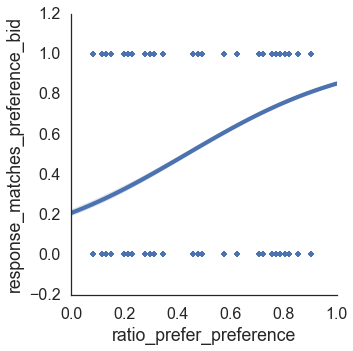

In [570]:
sns.lmplot(x='ratio_prefer_preference', y='response_matches_preference_bid',data=data_wpref, logistic=True)

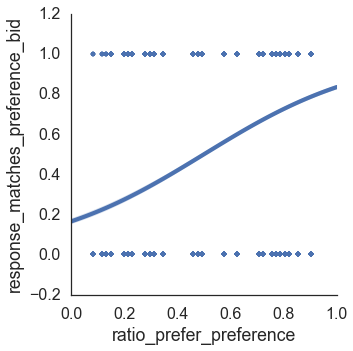

In [571]:
sns.lmplot(x='ratio_prefer_preference', y='response_matches_preference_bid',data=control_data_wpref, logistic=True)

In [90]:
sns.regplot?

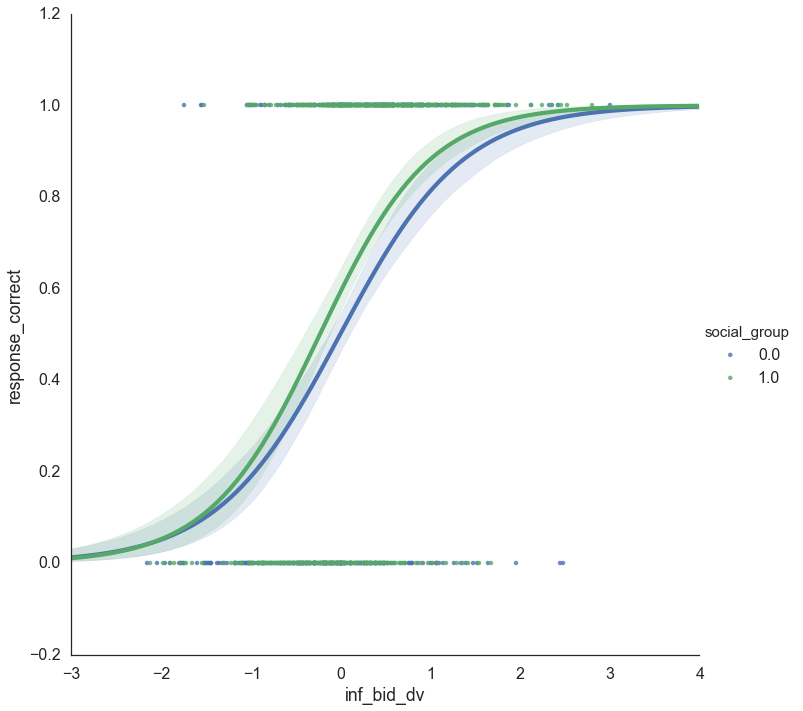

In [95]:
#sns.lmplot(x='inf_bid_dv', y='response_correct',data=control_data_wpref_first, logistic=True)
sns.lmplot(x='inf_bid_dv', y='response_correct',data=data_combined_wpref_first, logistic=True, hue='social_group', size=10)

###Supplementary Table 20: First trial response times

In [205]:
data_wpref_first = data_wpref[(data_wpref['pair_rep']==1)]
control_data_wpref_first = control_data_wpref[(control_data_wpref['pair_rep']==1)]
data_combined_wpref_first = data_combined_wpref[(data_combined_wpref['pair_rep']==1)]

%Rpush data_wpref_first
%Rpush control_data_wpref_first
%Rpush data_combined_wpref_first

In [206]:
%%R
first_rts_null <- glmer(infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + (1|participant), data_combined_wpref_first)
first_rts_wgroup <- glmer(infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + social_group + (1|participant), data_combined_wpref_first)
print(summary(first_rts_wgroup))
print(anova(first_rts_null, first_rts_wgroup))

Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + social_group +  
    (1 | participant)
   Data: data_combined_wpref_first

REML criterion at convergence: 3989.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2931 -0.6238 -0.2168  0.4083  5.6619 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.2527   0.5027  
 Residual                1.4203   1.1918  
Number of obs: 1220, groups:  participant, 61

Fixed effects:
                  Estimate Std. Error t value
(Intercept)         0.9981     0.1054   9.469
inf_bid_dv_chosen  -0.2965     0.0540  -5.492
social_group        0.6476     0.1457   4.444

Correlation of Fixed Effects:
            (Intr) inf___
inf_bd_dv_c -0.170       
social_grop -0.701 -0.006
Data: data_combined_wpref_first
Models:
first_rts_null: infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + (1 | participant)
first_rts_wgroup: infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen +

Were RTs different between groups in all but the first trials?

In [51]:
data_combined_wpref_nonfirst = data_combined_wpref[(data_combined_wpref['pair_rep']>1)]
%Rpush data_combined_wpref_nonfirst

In [56]:
%%R
first_rts_null <- glmer(infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + (1|participant), data_combined_wpref_nonfirst)
first_rts_wgroup <- glmer(infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + social_group + (1|participant), data_combined_wpref_nonfirst)
print(summary(first_rts_wgroup))
print(anova(first_rts_null, first_rts_wgroup))

Linear mixed model fit by REML ['lmerMod']
Formula: infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + social_group +  
    (1 | participant)
   Data: data_combined_wpref_nonfirst

REML criterion at convergence: 97208

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5427 -0.5755 -0.2756  0.2264 16.4654 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.0000   0.0000  
 Residual                0.9134   0.9557  
Number of obs: 35375, groups:  participant, 61

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       -0.018527   0.007298  -2.538
inf_bid_dv_chosen -0.098504   0.006900 -14.275
social_group      -0.014605   0.010178  -1.435

Correlation of Fixed Effects:
            (Intr) inf___
inf_bd_dv_c -0.120       
social_grop -0.700 -0.052
Data: data_combined_wpref_nonfirst
Models:
first_rts_null: infer_resp_rt_zscore ~ 1 + inf_bid_dv_chosen + (1 | participant)
first_rts_wgroup: infer_resp_rt_zscore ~ 1 + inf_bid_d

In [226]:
17399+17976

35375

##Supplementary Figure 6: Drift cartoons

            q  resp
1   0.7032391 upper
2   0.6239617 lower
3   1.2966917 upper
4   1.4646370 lower
5   0.5734281 upper
6   0.5467829 upper
7   0.5631137 lower
8   0.5323563 lower
9   0.6144888 upper
10  1.0944973 lower
11  2.0175353 upper
12  0.8945043 upper
13  1.2869763 upper
14  2.4544433 upper
15  0.3786762 upper
16  1.1986343 upper
17  1.6872653 upper
18  3.6907480 upper
19  1.3279859 lower
20  1.5058778 upper
21  1.4799868 upper
22  0.6976883 upper
23  0.6907632 upper
24  1.6477735 upper
25  4.9768744 upper
26  1.7386346 lower
27  2.1322330 upper
28  1.0897092 upper
29  0.8103362 lower
30  1.4952073 lower
31  1.2605417 upper
32  0.7804096 upper
33  0.8422831 upper
34  1.7672251 upper
35  0.9326956 upper
36  0.9193803 upper
37  0.6111799 upper
38  0.7776594 upper
39  2.1377299 upper
40  0.5004175 lower
41  0.7151680 upper
42  1.1658369 upper
43  1.2774209 upper
44  2.0079898 upper
45  0.9441132 upper
46  0.6702701 upper
47  2.1164071 upper
48  2.1675155 upper
49  1.5240271 lower


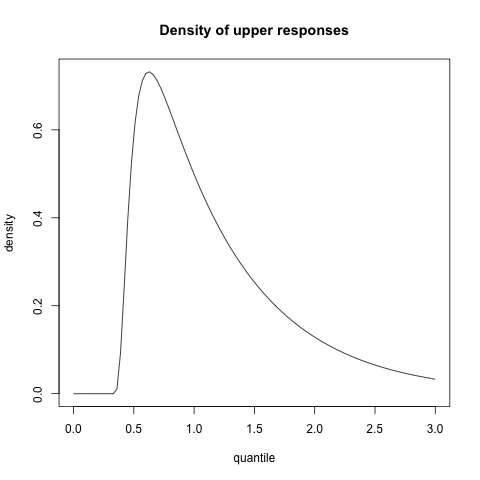

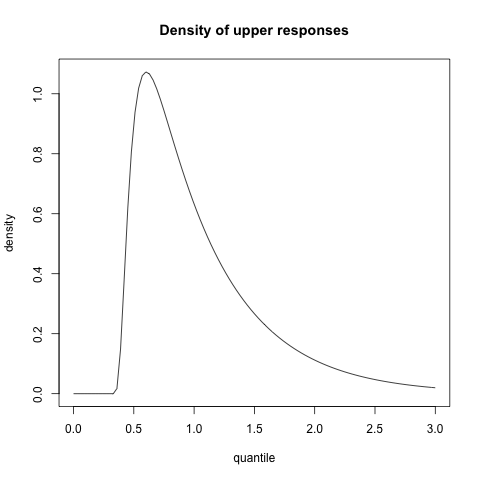

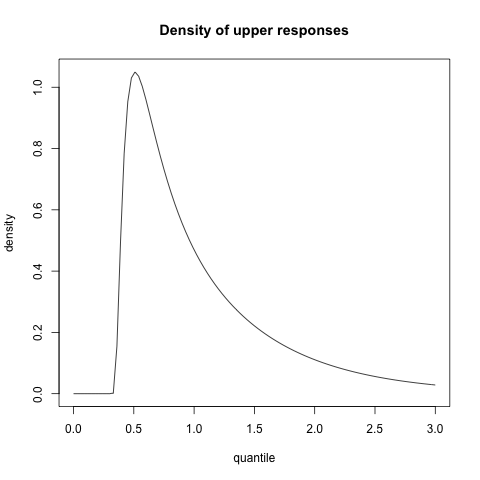

In [74]:
%%R
library(RWiener)
curve(dwiener(x, 2, .3, .5, .5, rep("upper", length(x))), xlim=c(0,3), main="Density of upper responses", ylab="density", xlab="quantile")
curve(dwiener(x, 2, .3, .5, 1, rep("upper", length(x))), xlim=c(0,3), main="Density of upper responses", ylab="density", xlab="quantile")
curve(dwiener(x, 2, .3, .6, .5, rep("upper", length(x))), xlim=c(0,3), main="Density of upper responses", ylab="density", xlab="quantile")
rwiener(n=100, alpha=2, tau=.3, beta=.5, delta=.5)

In [75]:
%%R
drift1 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=.5)
drift2 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=1)
drift3 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=1.5)
drift4 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=2)
drift5 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=2.5)
drift6 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=3.0)

In [76]:
%R -o drift1 -o drift2 -o drift3 -o drift4 -o drift5 -o drift6

In [77]:
drift1.resp.value_counts()

1    771
2    229
Name: resp, dtype: int64

In [78]:
drift1_q = drift1[drift1.resp==1]['q']
drift2_q = drift2[drift2.resp==1]['q']
drift3_q = drift3[drift3.resp==1]['q']
drift4_q = drift4[drift4.resp==1]['q']
drift5_q = drift5[drift5.resp==1]['q']
drift6_q = drift6[drift6.resp==1]['q']

In [80]:
%%R
bias1 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=.5)
bias2 <- rwiener(n=1000, alpha=2, tau=.3, beta=.6, delta=.5)
bias3 <- rwiener(n=1000, alpha=2, tau=.3, beta=.7, delta=.5)
bias4 <- rwiener(n=1000, alpha=2, tau=.3, beta=.8, delta=.5)
bias5 <- rwiener(n=1000, alpha=2, tau=.3, beta=.9, delta=.5)

In [81]:
%R -o bias1 -o bias2 -o bias3 -o bias4 -o bias5

In [82]:
bias1_q = bias1[bias1.resp==1]['q']
bias2_q = bias2[bias2.resp==1]['q']
bias3_q = bias3[bias3.resp==1]['q']
bias4_q = bias4[bias4.resp==1]['q']
bias5_q = bias5[bias5.resp==1]['q']

In [84]:
%%R
threshold1 <- rwiener(n=1000, alpha=.5, tau=.3, beta=.5, delta=.5)
threshold2 <- rwiener(n=1000, alpha=1, tau=.3, beta=.5, delta=.5)
threshold3 <- rwiener(n=1000, alpha=1.5, tau=.3, beta=.5, delta=.5)
threshold4 <- rwiener(n=1000, alpha=2, tau=.3, beta=.5, delta=.5)
threshold5 <- rwiener(n=1000, alpha=2.5, tau=.3, beta=.5, delta=.5)

In [85]:
%R -o threshold1 -o threshold2 -o threshold3 -o threshold4 -o threshold5

In [86]:
threshold1_q = threshold1[threshold1.resp==1]['q']
threshold2_q = threshold2[threshold2.resp==1]['q']
threshold3_q = threshold3[threshold3.resp==1]['q']
threshold4_q = threshold4[threshold4.resp==1]['q']
threshold5_q = threshold5[threshold5.resp==1]['q']

In [88]:
%%R
test_drift1 <- rwiener(n=10000, alpha=2, tau=.3, beta=.5, delta=.5)
test_drift2 <- rwiener(n=10000, alpha=2, tau=.3, beta=.5, delta=1)
test_bias1 <- rwiener(n=10000, alpha=2, tau=.3, beta=.5, delta=1.5)
test_bias2 <- rwiener(n=10000, alpha=2, tau=.3, beta=.5, delta=2)
test_threshold1 <- rwiener(n=10000, alpha=2, tau=.3, beta=.5, delta=2.5)
test_threshold2 <- rwiener(n=10000, alpha=2, tau=.3, beta=.5, delta=3.0)

In [89]:
%R -o test_drift1 -o test_drift2 -o test_bias1 -o test_bias2 -o test_threshold1 -o test_threshold2

In [90]:
test_drift1.resp.value_counts()

1    7323
2    2677
Name: resp, dtype: int64

In [91]:
test_drift2.resp.value_counts()

1    8783
2    1217
Name: resp, dtype: int64

In [92]:
%%R
test_bias2 <- rwiener(n=10000, alpha=2, tau=.3, beta=.71, delta=.5)

In [93]:
%R -o test_bias2

In [94]:
test_bias2.resp.value_counts()

1    8763
2    1237
Name: resp, dtype: int64

In [95]:
%%R
test_threshold2 <- rwiener(n=10000, alpha=3.9, tau=.3, beta=.5, delta=.5)

In [96]:
%R -o test_threshold2

In [97]:
test_threshold2.resp.value_counts()

1    8814
2    1186
Name: resp, dtype: int64

In [98]:
test_drift2_up = test_drift2[test_drift2.resp==1]['q']
test_bias2_up = test_bias2[test_bias2.resp==1]['q']
test_threshold2_up = test_threshold2[test_threshold2.resp==1]['q']
test_drift2_down = test_drift2[test_drift2.resp==2]['q']
test_bias2_down = test_bias2[test_bias2.resp==2]['q']
test_threshold2_down = test_threshold2[test_threshold2.resp==2]['q']

In [99]:
test_drift1_up = test_drift1[test_drift1.resp==1]['q']
test_drift1_down = test_drift1[test_drift1.resp==2]['q']

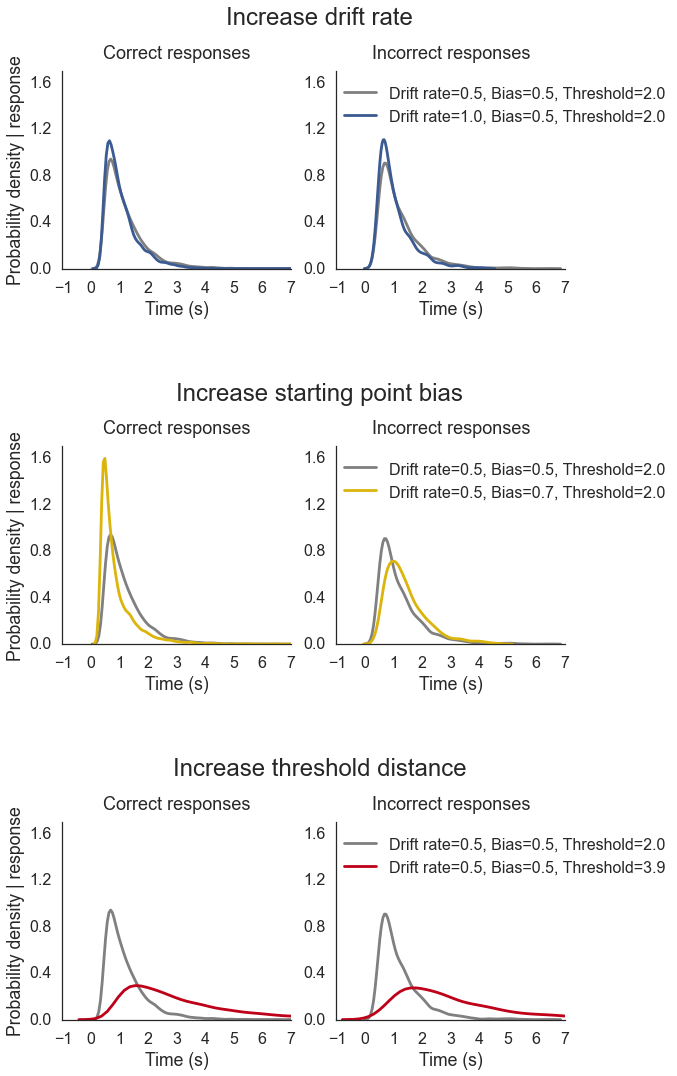

In [101]:
plt.figure(figsize=(9,17))
ax1 = plt.subplot(321)
sns.kdeplot(test_drift1_up, label='Drift rate=0.5, Bias=0.5, Threshold=2.0', legend=False, color='grey')
sns.kdeplot(test_drift2_up, label='Drift rate=1.0, Bias=0.5, Threshold=2.0', legend=False, color=sns.xkcd_rgb['denim blue'])
#sns.kdeplot(test_bias2_up, label='Drift=0.5, Bias=0.7, Threshold=2.0', legend=False)
#sns.kdeplot(test_threshold2_up, label='Drift=0.5, Bias=0.5, Threshold=3.9', legend=False)
plt.xlim(-1,7)
plt.ylim(0,1.7)
plt.ylabel('Probability density | response')
plt.xlabel('Time (s)')
plt.title('Correct responses', size=18, y=1.04)
plt.yticks([0,0.4,0.8,1.2,1.6])
ax1.text(8, 2.1, 'Increase drift rate', size=24, horizontalalignment='center')

ax2 = plt.subplot(322)
sns.kdeplot(test_drift1_down, label='Drift rate=0.5, Bias=0.5, Threshold=2.0', color='grey')
sns.kdeplot(test_drift2_down, label='Drift rate=1.0, Bias=0.5, Threshold=2.0', color=sns.xkcd_rgb['denim blue'])
plt.xlim(-1,7)
plt.ylim(0,1.7)
plt.legend(bbox_to_anchor=(1.5,1))
plt.xlabel('Time (s)')
plt.yticks([0,0.4,0.8,1.2,1.6])
plt.title('Incorrect responses', size=18, y=1.04)


ax3 = plt.subplot(323)
sns.kdeplot(test_drift1_up, label='Drift rate=0.5, Bias=0.5, Threshold=2.0', legend=False, color='grey')
sns.kdeplot(test_bias2_up, label='Drift rate=0.5, Bias=0.7, Threshold=2.0', legend=False, color=sns.xkcd_rgb['gold'])
plt.xlim(-1,7)
plt.ylim(0,1.7)
plt.ylabel('Probability density | response')
plt.xlabel('Time (s)')
plt.yticks([0,0.4,0.8,1.2,1.6])
plt.title('Correct responses', size=18, y=1.04)
ax3.text(8, 2.1, 'Increase starting point bias', size=24, horizontalalignment='center')


ax4 = plt.subplot(324)
sns.kdeplot(test_drift1_down, label='Drift rate=0.5, Bias=0.5, Threshold=2.0', color='grey')
sns.kdeplot(test_bias2_down, label='Drift rate=0.5, Bias=0.7, Threshold=2.0', color=sns.xkcd_rgb['gold'])
plt.xlim(-1,7)
plt.ylim(0,1.7)
plt.legend(bbox_to_anchor=(1.5,1))
plt.xlabel('Time (s)')
plt.yticks([0,0.4,0.8,1.2,1.6])
plt.title('Incorrect responses', size=18, y=1.04)

ax5 = plt.subplot(325)
sns.kdeplot(test_drift1_up, label='Drift rate=0.5, Bias=0.5, Threshold=2.0', legend=False, color='grey')
sns.kdeplot(test_threshold2_up, label='Drift rate=0.5, Bias=0.5, Threshold=3.9', legend=False, color=sns.xkcd_rgb['scarlet'])
plt.xlim(-1,7)
plt.ylim(0,1.7)
plt.ylabel('Probability density | response')
plt.xlabel('Time (s)')
plt.yticks([0,0.4,0.8,1.2,1.6])
plt.title('Correct responses', size=18, y=1.04)
ax5.text(8, 2.1, 'Increase threshold distance', size=24, horizontalalignment='center')


ax6 = plt.subplot(326)
sns.kdeplot(test_drift1_down, label='Drift rate=0.5, Bias=0.5, Threshold=2.0', color='grey')
sns.kdeplot(test_threshold2_down, label='Drift rate=0.5, Bias=0.5, Threshold=3.9', color=sns.xkcd_rgb['scarlet'])
plt.xlim(-1,7)
plt.ylim(0,1.7)
plt.legend(bbox_to_anchor=(1.5,1))
plt.xlabel('Time (s)')
plt.yticks([0,0.4,0.8,1.2,1.6])
plt.title('Incorrect responses', size=18, y=1.04)

plt.subplots_adjust(hspace=0.9)

sns.despine()

plt.savefig('../figures/supp-fig6-DDM_demo_expanded.pdf', bbox_inches='tight')

##Drift Models

We test four alternative drift diffusion models (all Bayesian):

1) <b>Null.</b> A null model, with unbiased learning and unbiased drift process;<br>
2) <b>Choice.</b> Preference acts only on the a priori bias term;<br>
3) <b>Priors.</b> Preference acts only on the learning value starting points, which affect only the drift rate;<br>
4) <b>Dual.</b> Preference acts only on the drift rate via a constant augmentation of the selected learned value.<br>
5) <b>Dual w/Item popularity.</b> Item popularity is added as a factor into the prior.<br>

###Model Comparison (Social experiment, Bayesian)

NOTE: The fit objects loaded here are too big for GitHub and Figshare but are available on request (tor.tarantola@gmail.com). You can also run the model yourself using the scripts in the "stan" folder, though the results may be slightly different due to the stochastic nature of the sampling algorithm. To run these analyses, save the fit objects in this folder in your cloned repository:

"analysis_code/stan/pickles"

<b>Null model (Bayesian)</b>

In [8]:
# Null Drift Model (Bayesian)

#Load Stan model and fit
model_null_bayesian_noeye = pickle.load(open('stan/pickles/model_null_bayesian_noeye.pkl', 'rb'))
fit_null_bayesian_noeye = pickle.load(open('stan/pickles/fit_null_bayesian_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_null_bayesian_noeye = pd.DataFrame(fit_null_bayesian_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_null_bayesian_noeye).any(0).nonzero()[0]
LL_null_bayesian_noeye.drop(LL_null_bayesian_noeye.columns[null_index], axis=1, inplace=True)

LL_null_bayesian_noeye_mean = LL_null_bayesian_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_null_bayesian_noeye_mean))[0]
LL_null_bayesian_noeye.drop(LL_null_bayesian_noeye.columns[inf_index], axis=1, inplace=True)
LL_null_bayesian_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_null_bayesian_noeye = com.convert_to_r_matrix(LL_null_bayesian_noeye)

# Push to R
%Rpush R_LL_null_bayesian_noeye

In [10]:
%%R
library("rstan")
library("loo")
loo_null_bayesian_noeye <- loo(R_LL_null_bayesian_noeye)
print(loo_null_bayesian_noeye)

Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -8344.3 240.7
p_loo       291.3 108.9
looic     16688.7 481.3


<b>Influenced choice (Bayesian)</b>

In [24]:
#Load Stan model and fit
model_choice_bayesian_noeye = pickle.load(open('stan/pickles/model_choice_bayesian_noeye.pkl', 'rb'))
fit_choice_bayesian_noeye = pickle.load(open('stan/pickles/fit_choice_bayesian_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_choice_bayesian_noeye = pd.DataFrame(fit_choice_bayesian_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_choice_bayesian_noeye).any(0).nonzero()[0]
LL_choice_bayesian_noeye.drop(LL_choice_bayesian_noeye.columns[null_index], axis=1, inplace=True)

LL_choice_bayesian_noeye_mean = LL_choice_bayesian_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_choice_bayesian_noeye_mean))[0]
LL_choice_bayesian_noeye.drop(LL_choice_bayesian_noeye.columns[inf_index], axis=1, inplace=True)
LL_choice_bayesian_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_choice_bayesian_noeye = com.convert_to_r_matrix(LL_choice_bayesian_noeye)

# Push to R
%Rpush R_LL_choice_bayesian_noeye

In [25]:
%%R
library("rstan")
library("loo")
loo_choice_bayesian_noeye <- loo(R_LL_choice_bayesian_noeye)
print(loo_choice_bayesian_noeye)

Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -8159.9 242.6
p_loo       328.2 113.8
looic     16319.8 485.3


<b>Influenced prior (Bayesian)</b>

In [19]:
#Load Stan model and fit
model_prior_bayesian_noeye = pickle.load(open('stan/pickles/model_prior_bayesian_noeye.pkl', 'rb'))
fit_prior_bayesian_noeye = pickle.load(open('stan/pickles/fit_prior_bayesian_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_prior_bayesian_noeye = pd.DataFrame(fit_prior_bayesian_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_prior_bayesian_noeye).any(0).nonzero()[0]
LL_prior_bayesian_noeye.drop(LL_prior_bayesian_noeye.columns[null_index], axis=1, inplace=True)

LL_prior_bayesian_noeye_mean = LL_prior_bayesian_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_prior_bayesian_noeye_mean))[0]
LL_prior_bayesian_noeye.drop(LL_prior_bayesian_noeye.columns[inf_index], axis=1, inplace=True)
LL_prior_bayesian_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_prior_bayesian_noeye = com.convert_to_r_matrix(LL_prior_bayesian_noeye)

# Push to R
%Rpush R_LL_prior_bayesian_noeye

In [21]:
%%R
library("rstan")
library("loo")
loo_prior_bayesian_noeye <- loo(R_LL_prior_bayesian_noeye)
print(loo_prior_bayesian_noeye)

Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -8234.5 243.7
p_loo       346.3 114.1
looic     16469.0 487.3


<b>Dual influence (Bayesian)</b>

In [22]:
#Load Stan model and fit
model_dual_bayesian_noeye = pickle.load(open('stan/pickles/model_dual_bayesian_noeye.pkl', 'rb'))
fit_dual_bayesian_noeye = pickle.load(open('stan/pickles/fit_dual_bayesian_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_bayesian_noeye = pd.DataFrame(fit_dual_bayesian_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_bayesian_noeye).any(0).nonzero()[0]
LL_dual_bayesian_noeye.drop(LL_dual_bayesian_noeye.columns[null_index], axis=1, inplace=True)

LL_dual_bayesian_noeye_mean = LL_dual_bayesian_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_bayesian_noeye_mean))[0]
LL_dual_bayesian_noeye.drop(LL_dual_bayesian_noeye.columns[inf_index], axis=1, inplace=True)
LL_dual_bayesian_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_bayesian_noeye = com.convert_to_r_matrix(LL_dual_bayesian_noeye)

# Push to R
%Rpush R_LL_dual_bayesian_noeye

In [23]:
%%R
library("rstan")
library("loo")
loo_dual_bayesian_noeye <- loo(R_LL_dual_bayesian_noeye)
print(loo_dual_bayesian_noeye)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: rstan (Version 2.9.0-3, packaged: 2016-02-11 15:54:41 UTC, GitRev: 05c3d0058b6a)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is loo version 0.1.6

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -8077.8 240.0
p_loo       364.6 108.1
looic     16155.7 480.0


Compare two models with best ELPDs, the "influenced choice" and "dual influence" models:

In [26]:
%%R
loo_diff <- compare(loo_choice_bayesian_noeye, loo_dual_bayesian_noeye)
print(loo_diff)

elpd_diff        se 
     82.1      19.4 


The dual influence model is significantly more predictive.<br>
Next, we add a "popularity" parameter to the most predictive model, the dual influence model.

<b>Dual influence w/popularity (Bayesian)</b>

In [19]:
#Load Stan model and fit
model_dual_insight_bayesian_noeye = pickle.load(open('stan/pickles/model_dual_insight_bayesian_noeye.pkl', 'rb'))
fit_dual_insight_bayesian_noeye = pickle.load(open('stan/pickles/fit_dual_insight_bayesian_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_bayesian_noeye = pd.DataFrame(fit_dual_insight_bayesian_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_bayesian_noeye).any(0).nonzero()[0]
LL_dual_insight_bayesian_noeye.drop(LL_dual_insight_bayesian_noeye.columns[null_index], axis=1, inplace=True)

LL_dual_insight_bayesian_noeye_mean = LL_dual_insight_bayesian_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_bayesian_noeye_mean))[0]
LL_dual_insight_bayesian_noeye.drop(LL_dual_insight_bayesian_noeye.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_bayesian_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_insight_bayesian_noeye = com.convert_to_r_matrix(LL_dual_insight_bayesian_noeye)

# Push to R
%Rpush R_LL_dual_insight_bayesian_noeye

In [20]:
%%R
library("rstan")
library("loo")
loo_dual_insight_bayesian_noeye <- loo(R_LL_dual_insight_bayesian_noeye)
print(loo_dual_insight_bayesian_noeye)

Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -8018.3 241.1
p_loo       406.9 110.3
looic     16036.6 482.1


Does adding insight improve the predictiveness of the model?

In [21]:
%%R
loo_diff <- compare(loo_dual_insight_bayesian_noeye, loo_dual_bayesian_noeye)
print(loo_diff)

elpd_diff        se 
    -59.6      15.4 


Yes, it does.

###Model comparison (social, Rescorla-Wagner)

<b>Null Model (RW, social)</b>

In [9]:
# Null Drift Model (RW)

#Load Stan model and fit
model_null_rw_noeye = pickle.load(open('stan/pickles/model_null_rw_noeye.pkl', 'rb'))
fit_null_rw_noeye = pickle.load(open('stan/pickles/fit_null_rw_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_null_rw_noeye = pd.DataFrame(fit_null_rw_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_null_rw_noeye).any(0).nonzero()[0]
LL_null_rw_noeye.drop(LL_null_rw_noeye.columns[null_index], axis=1, inplace=True)

LL_null_rw_noeye_mean = LL_null_rw_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_null_rw_noeye_mean))[0]
LL_null_rw_noeye.drop(LL_null_rw_noeye.columns[inf_index], axis=1, inplace=True)
LL_null_rw_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_null_rw_noeye = com.convert_to_r_matrix(LL_null_rw_noeye)

# Push to R
%Rpush R_LL_null_rw_noeye

In [10]:
%%R
library("rstan")
library("loo")
loo_null_rw_noeye <- loo(R_LL_null_rw_noeye)
print(loo_null_rw_noeye)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: rstan (Version 2.9.0-3, packaged: 2016-02-11 15:54:41 UTC, GitRev: 05c3d0058b6a)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is loo version 0.1.6

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -7816.6 227.9
p_loo       338.4 113.2
looic     15633.1 455.7


<b>Influenced choice (RW, social)</b>

In [11]:
# Influenced choice Drift Model (RW)

#Load Stan model and fit
model_choice_rw_noeye = pickle.load(open('stan/pickles/model_choice_rw_noeye.pkl', 'rb'))
fit_choice_rw_noeye = pickle.load(open('stan/pickles/fit_choice_rw_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_choice_rw_noeye = pd.DataFrame(fit_choice_rw_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_choice_rw_noeye).any(0).nonzero()[0]
LL_choice_rw_noeye.drop(LL_choice_rw_noeye.columns[null_index], axis=1, inplace=True)

LL_choice_rw_noeye_mean = LL_choice_rw_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_choice_rw_noeye_mean))[0]
LL_choice_rw_noeye.drop(LL_choice_rw_noeye.columns[inf_index], axis=1, inplace=True)
LL_choice_rw_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_choice_rw_noeye = com.convert_to_r_matrix(LL_choice_rw_noeye)

# Push to R
%Rpush R_LL_choice_rw_noeye

In [12]:
%%R
library("rstan")
library("loo")
loo_choice_rw_noeye <- loo(R_LL_choice_rw_noeye)
print(loo_choice_rw_noeye)

Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -7596.3 230.1
p_loo       376.9 116.1
looic     15192.7 460.3


<b>Influenced prior (RW, social)</b>

In [8]:
# Influenced prior Drift Model (RW)

#Load Stan model and fit
model_prior_rw_noeye = pickle.load(open('stan/pickles/model_prior_rw_noeye.pkl', 'rb'))
fit_prior_rw_noeye = pickle.load(open('stan/pickles/fit_prior_rw_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_prior_rw_noeye = pd.DataFrame(fit_prior_rw_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_prior_rw_noeye).any(0).nonzero()[0]
LL_prior_rw_noeye.drop(LL_prior_rw_noeye.columns[null_index], axis=1, inplace=True)

LL_prior_rw_noeye_mean = LL_prior_rw_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_prior_rw_noeye_mean))[0]
LL_prior_rw_noeye.drop(LL_prior_rw_noeye.columns[inf_index], axis=1, inplace=True)
LL_prior_rw_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_prior_rw_noeye = com.convert_to_r_matrix(LL_prior_rw_noeye)

# Push to R
%Rpush R_LL_prior_rw_noeye

In [9]:
%%R
library("rstan")
library("loo")
loo_prior_rw_noeye <- loo(R_LL_prior_rw_noeye)
print(loo_prior_rw_noeye)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: rstan (Version 2.9.0-3, packaged: 2016-02-11 15:54:41 UTC, GitRev: 05c3d0058b6a)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is loo version 0.1.6

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -7531.0 219.5
p_loo       338.8  93.9
looic     15061.9 439.1


<b>Dual influence (RW, social)</b>

In [10]:
# Dual influence Drift Model (RW)

#Load Stan model and fit
model_dual_rw_noeye = pickle.load(open('stan/pickles/model_dual_rw_noeye.pkl', 'rb'))
fit_dual_rw_noeye = pickle.load(open('stan/pickles/fit_dual_rw_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_rw_noeye = pd.DataFrame(fit_dual_rw_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_rw_noeye).any(0).nonzero()[0]
LL_dual_rw_noeye.drop(LL_dual_rw_noeye.columns[null_index], axis=1, inplace=True)

LL_dual_rw_noeye_mean = LL_dual_rw_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_rw_noeye_mean))[0]
LL_dual_rw_noeye.drop(LL_dual_rw_noeye.columns[inf_index], axis=1, inplace=True)
LL_dual_rw_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_rw_noeye = com.convert_to_r_matrix(LL_dual_rw_noeye)

# Push to R
%Rpush R_LL_dual_rw_noeye

In [11]:
%%R
library("rstan")
library("loo")
loo_dual_rw_noeye <- loo(R_LL_dual_rw_noeye)
print(loo_dual_rw_noeye)

Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -7474.2 227.5
p_loo       387.6 110.0
looic     14948.4 455.1


<b>Dual influence w/popularity (RW, social)</b>

In [14]:
# Dual influence w/insight Drift Model (RW)

#Load Stan model and fit
model_dual_insight_rw_noeye = pickle.load(open('stan/pickles/model_dual_insight_rw_noeye.pkl', 'rb'))
fit_dual_insight_rw_noeye = pickle.load(open('stan/pickles/fit_dual_insight_rw_noeye.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_rw_noeye = pd.DataFrame(fit_dual_insight_rw_noeye['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_rw_noeye).any(0).nonzero()[0]
LL_dual_insight_rw_noeye.drop(LL_dual_insight_rw_noeye.columns[null_index], axis=1, inplace=True)

LL_dual_insight_rw_noeye_mean = LL_dual_insight_rw_noeye.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_rw_noeye_mean))[0]
LL_dual_insight_rw_noeye.drop(LL_dual_insight_rw_noeye.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_rw_noeye.columns = range((18600 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_insight_rw_noeye = com.convert_to_r_matrix(LL_dual_insight_rw_noeye)

# Push to R
%Rpush R_LL_dual_insight_rw_noeye

In [15]:
%%R
library("rstan")
library("loo")
loo_dual_insight_rw_noeye <- loo(R_LL_dual_insight_rw_noeye)
print(loo_dual_insight_rw_noeye)

Computed from 4000 by 18571 log-likelihood matrix

         Estimate    SE
elpd_loo  -7352.9 219.8
p_loo       381.8  95.2
looic     14705.7 439.5


In [13]:
%%R
loo_diff <- compare(loo_dual_rw_noeye, loo_prior_rw_noeye)
print(loo_diff)

elpd_diff        se 
    -56.8      21.2 


In [16]:
%%R
loo_diff <- compare(loo_dual_insight_rw_noeye, loo_dual_rw_noeye)
print(loo_diff)

elpd_diff        se 
   -121.3      20.0 


###Model comparison (non-social experiment)

Now we do the same model comparisons for the non-social experiment group.

<b>Null Model (Bayesian)</b>

In [15]:
# Null Drift Model (Bayesian)

#Load Stan model and fit
model_null_bayesian_noeye_non_social = pickle.load(open('stan/pickles/model_null_bayesian_noeye_non_social.pkl', 'rb'))
fit_null_bayesian_noeye_non_social = pickle.load(open('stan/pickles/fit_null_bayesian_noeye_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_null_bayesian_noeye_non_social = pd.DataFrame(fit_null_bayesian_noeye_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_null_bayesian_noeye_non_social).any(0).nonzero()[0]
LL_null_bayesian_noeye_non_social.drop(LL_null_bayesian_noeye_non_social.columns[null_index], axis=1, inplace=True)

LL_null_bayesian_noeye_non_social_mean = LL_null_bayesian_noeye_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_null_bayesian_noeye_non_social_mean))[0]
LL_null_bayesian_noeye_non_social.drop(LL_null_bayesian_noeye_non_social.columns[inf_index], axis=1, inplace=True)
LL_null_bayesian_noeye_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_null_bayesian_noeye_non_social = com.convert_to_r_matrix(LL_null_bayesian_noeye_non_social)

# Push to R
%Rpush R_LL_null_bayesian_noeye_non_social

In [16]:
%%R
library("rstan")
library("loo")
loo_null_bayesian_noeye_non_social <- loo(R_LL_null_bayesian_noeye_non_social)
print(loo_null_bayesian_noeye_non_social)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: rstan (Version 2.9.0-3, packaged: 2016-02-11 15:54:41 UTC, GitRev: 05c3d0058b6a)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is loo version 0.1.6

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Computed from 4000 by 17995 log-likelihood matrix

         Estimate    SE
elpd_loo -11488.8 195.8
p_loo       135.8  15.3
looic     22977.6 391.7


<b>Influenced choice (Bayesian)</b>

In [3]:
# Influenced Choice Model (Bayesian)

#Load Stan model and fit
model_choice_bayesian_noeye_non_social = pickle.load(open('stan/pickles/model_choice_bayesian_noeye_non_social.pkl', 'rb'))
fit_choice_bayesian_noeye_non_social = pickle.load(open('stan/pickles/fit_choice_bayesian_noeye_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_choice_bayesian_noeye_non_social = pd.DataFrame(fit_choice_bayesian_noeye_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_choice_bayesian_noeye_non_social).any(0).nonzero()[0]
LL_choice_bayesian_noeye_non_social.drop(LL_choice_bayesian_noeye_non_social.columns[null_index], axis=1, inplace=True)

LL_choice_bayesian_noeye_non_social_mean = LL_choice_bayesian_noeye_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_choice_bayesian_noeye_non_social_mean))[0]
LL_choice_bayesian_noeye_non_social.drop(LL_choice_bayesian_noeye_non_social.columns[inf_index], axis=1, inplace=True)
LL_choice_bayesian_noeye_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_choice_bayesian_noeye_non_social = com.convert_to_r_matrix(LL_choice_bayesian_noeye_non_social)

# Push to R
%Rpush R_LL_choice_bayesian_noeye_non_social

In [4]:
%%R
library("rstan")
library("loo")
loo_choice_bayesian_noeye_non_social <- loo(R_LL_choice_bayesian_noeye_non_social)
print(loo_choice_bayesian_noeye_non_social)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: rstan (Version 2.9.0-3, packaged: 2016-02-11 15:54:41 UTC, GitRev: 05c3d0058b6a)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is loo version 0.1.6

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Computed from 4000 by 17995 log-likelihood matrix

         Estimate    SE
elpd_loo -11259.7 195.6
p_loo       159.0  15.5
looic     22519.4 391.1


<b>Influenced prior (Bayesian)</b>

In [5]:
# Influenced Prior Model (Bayesian)

#Load Stan model and fit
model_prior_bayesian_noeye_non_social = pickle.load(open('stan/pickles/model_prior_bayesian_noeye_non_social.pkl', 'rb'))
fit_prior_bayesian_noeye_non_social = pickle.load(open('stan/pickles/fit_prior_bayesian_noeye_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_prior_bayesian_noeye_non_social = pd.DataFrame(fit_prior_bayesian_noeye_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_prior_bayesian_noeye_non_social).any(0).nonzero()[0]
LL_prior_bayesian_noeye_non_social.drop(LL_prior_bayesian_noeye_non_social.columns[null_index], axis=1, inplace=True)

LL_prior_bayesian_noeye_non_social_mean = LL_prior_bayesian_noeye_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_prior_bayesian_noeye_non_social_mean))[0]
LL_prior_bayesian_noeye_non_social.drop(LL_prior_bayesian_noeye_non_social.columns[inf_index], axis=1, inplace=True)
LL_prior_bayesian_noeye_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_prior_bayesian_noeye_non_social = com.convert_to_r_matrix(LL_prior_bayesian_noeye_non_social)

# Push to R
%Rpush R_LL_prior_bayesian_noeye_non_social

In [6]:
%%R
library("rstan")
library("loo")
loo_prior_bayesian_noeye_non_social <- loo(R_LL_prior_bayesian_noeye_non_social)
print(loo_prior_bayesian_noeye_non_social)

Computed from 4000 by 17995 log-likelihood matrix

         Estimate    SE
elpd_loo -11326.4 196.4
p_loo       189.5  15.9
looic     22652.8 392.8


<b>Dual influence (Bayesian)</b>

In [21]:
# Dual Influence Model (Bayesian)

#Load Stan model and fit
model_dual_bayesian_noeye_non_social = pickle.load(open('stan/pickles/model_dual_bayesian_noeye_non_social.pkl', 'rb'))
fit_dual_bayesian_noeye_non_social = pickle.load(open('stan/pickles/fit_dual_bayesian_noeye_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_bayesian_noeye_non_social = pd.DataFrame(fit_dual_bayesian_noeye_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_bayesian_noeye_non_social).any(0).nonzero()[0]
LL_dual_bayesian_noeye_non_social.drop(LL_dual_bayesian_noeye_non_social.columns[null_index], axis=1, inplace=True)

LL_dual_bayesian_noeye_non_social_mean = LL_dual_bayesian_noeye_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_bayesian_noeye_non_social_mean))[0]
LL_dual_bayesian_noeye_non_social.drop(LL_dual_bayesian_noeye_non_social.columns[inf_index], axis=1, inplace=True)
LL_dual_bayesian_noeye_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_bayesian_noeye_non_social = com.convert_to_r_matrix(LL_dual_bayesian_noeye_non_social)

# Push to R
%Rpush R_LL_dual_bayesian_noeye_non_social

In [22]:
%%R
library("rstan")
library("loo")
loo_dual_bayesian_noeye_non_social <- loo(R_LL_dual_bayesian_noeye_non_social)
print(loo_dual_bayesian_noeye_non_social)

Computed from 4000 by 17995 log-likelihood matrix

         Estimate    SE
elpd_loo -11141.8 195.9
p_loo       207.1  15.0
looic     22283.5 391.9


Is the dual influence model significantly more predictive than the second-best, influenced choice model?

In [23]:
%%R
loo_diff <- compare(loo_choice_bayesian_noeye_non_social, loo_dual_bayesian_noeye_non_social)
print(loo_diff)

elpd_diff        se 
    117.2      20.4 


<b>Dual influence w/popularity (Bayesian)</b>

In [24]:
# Influenced Dual Influence w/Insight Model (Bayesian)

#Load Stan model and fit
model_dual_insight_bayesian_noeye_non_social = pickle.load(open('stan/pickles/model_dual_insight_bayesian_noeye_non_social.pkl', 'rb'))
fit_dual_insight_bayesian_noeye_non_social = pickle.load(open('stan/pickles/fit_dual_insight_bayesian_noeye_non_social.pkl', 'rb'))

# Load log-likelihood matrix for response data from Stan fit generated quantitites
LL_dual_insight_bayesian_noeye_non_social = pd.DataFrame(fit_dual_insight_bayesian_noeye_non_social['log_lik_rt'])

# Drop trials with no RT data (i.e. NaN and -inf likelihoods)
null_index = pd.isnull(LL_dual_insight_bayesian_noeye_non_social).any(0).nonzero()[0]
LL_dual_insight_bayesian_noeye_non_social.drop(LL_dual_insight_bayesian_noeye_non_social.columns[null_index], axis=1, inplace=True)

LL_dual_insight_bayesian_noeye_non_social_mean = LL_dual_insight_bayesian_noeye_non_social.mean(axis=0)
inf_index = np.where(np.isinf(LL_dual_insight_bayesian_noeye_non_social_mean))[0]
LL_dual_insight_bayesian_noeye_non_social.drop(LL_dual_insight_bayesian_noeye_non_social.columns[inf_index], axis=1, inplace=True)
LL_dual_insight_bayesian_noeye_non_social.columns = range((18000 - len(null_index) - len(inf_index)))

# Convert to R matrix
R_LL_dual_insight_bayesian_noeye_non_social = com.convert_to_r_matrix(LL_dual_insight_bayesian_noeye_non_social)

# Push to R
%Rpush R_LL_dual_insight_bayesian_noeye_non_social

In [25]:
%%R
library("rstan")
library("loo")
loo_dual_insight_bayesian_noeye_non_social <- loo(R_LL_dual_insight_bayesian_noeye_non_social)
print(loo_dual_insight_bayesian_noeye_non_social)

Computed from 4000 by 17995 log-likelihood matrix

         Estimate    SE
elpd_loo -11124.3 196.3
p_loo       256.8  15.7
looic     22248.6 392.6


Does item popularity improve the dual influence model in the non-social group?

In [26]:
%%R
loo_diff <- compare(loo_dual_bayesian_noeye_non_social, loo_dual_insight_bayesian_noeye_non_social)
print(loo_diff)

elpd_diff        se 
     17.5      10.8 


###Figure 6a: LOO comparisons

In [37]:
plt.subplot?

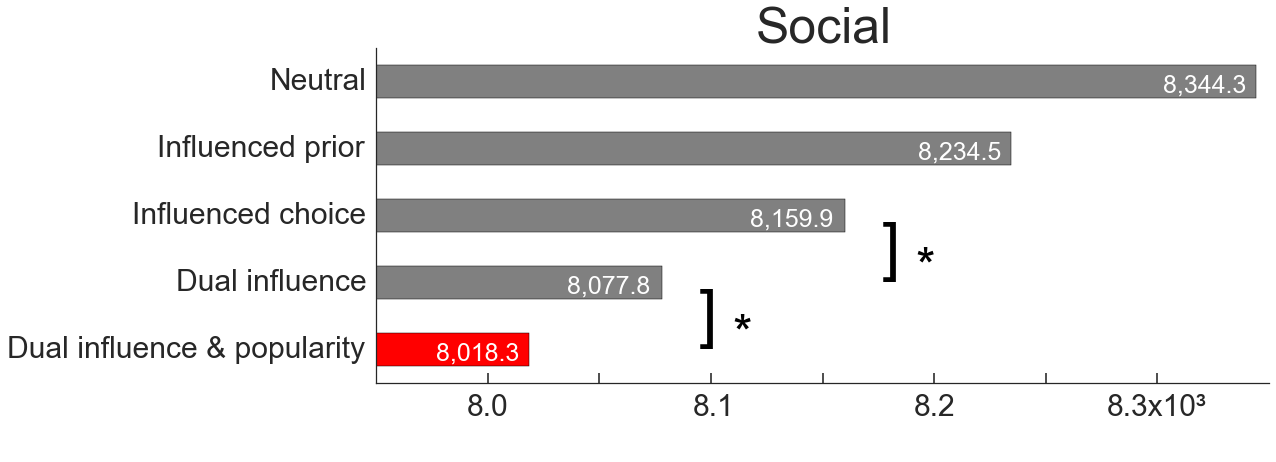

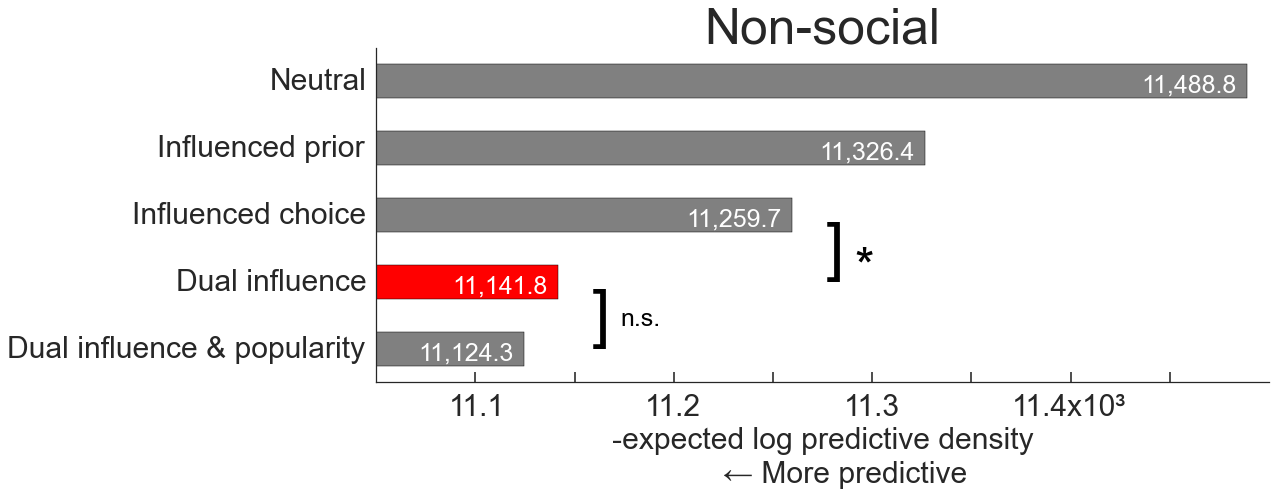

In [50]:
# Bayesian Social & Non-social panel
#fig, ax = pl.subplots(2,1,squeeze=False)
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (16.0, 6.0)

# Social
#ax1 = plt.subplot(211)
comparison_labels = ['Dual influence & popularity','Dual influence','Influenced choice','Influenced prior', 'Neutral']
comparison_elpds = [8018.3, 8077.8, 8159.9, 8234.5, 8344.3]
comparison_errors = [241.1, 240.0, 242.6, 243.7, 240.7]
xticklabels = ['8.0','','8.1','','8.2','',u'8.3x10\u00B3']
ax[0,0] = pd.DataFrame(comparison_elpds,index=comparison_labels).plot(kind='barh', legend=False, xlim=[7950,8350], fontsize=30, color=['red','grey','grey','grey','grey'])
ax[0,0].set_title(u'Social', size=50)
ax[0,0].set_xticks([8000,8050,8100,8150,8200,8250,8300])
ax[0,0].set_xticklabels(xticklabels)
#ax[0,0].set_xlabel(u'-expected log predictive density', size=30)
ax[0,0].xaxis.set_tick_params(size=10)
ax[0,0].xaxis.set_ticks_position('bottom')
ax[0,0].tick_params(axis='x', direction='in')
ax[0,0].text(8303,3.85,'8,344.3', size=25, color='white')
ax[0,0].text(8193,2.85,'8,234.5', size=25, color='white')
ax[0,0].text(8118,1.85,'8,159.9', size=25, color='white')

ax[0,0].text(8177.2,1.2,']', size=65, color='black')
ax[0,0].text(8192.2,1,'*', size=50, color='black')

ax[0,0].text(8036,0.85,'8,077.8', size=25, color='white')

ax[0,0].text(8095.1,0.2,']', size=65, color='black')
ax[0,0].text(8110.1,0,'*', size=50, color='black')

ax[0,0].text(7977,-0.15,'8,018.3', size=25, color='white')
ax[0,0].text(7977,-1.5,'--', size=25, color='white') # Add some space between plots

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

plt.savefig('../figures/fig6-loo_comparison_social.eps', bbox_inches='tight')

# Non-social
#ax2 = plt.subplot(212)
comparison_labels = ['Dual influence & popularity','Dual influence','Influenced choice','Influenced prior', 'Neutral']
comparison_elpds = [11124.3, 11141.8, 11259.7, 11326.4, 11488.8]
comparison_errors = [196.3, 195.9, 195.6, 196.4, 195.8]
xticklabels = ['11.1','','11.2','','11.3','',u'11.4x10\u00B3']
ax[1,0] = pd.DataFrame(comparison_elpds,index=comparison_labels).plot(kind='barh', legend=False, xlim=[11050,11500], fontsize=30, color=['grey','red','grey','grey','grey'])
ax[1,0].set_title(u'Non-social', size=50)
ax[1,0].set_xticks([11100,11150,11200,11250,11300,11350,11400,11450])
ax[1,0].set_xticklabels(xticklabels)
ax[1,0].set_xlabel(u'-expected log predictive density', size=30)
ax[1,0].text(11225, -2, u'\u2190 More predictive', size=30)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,0].xaxis.set_tick_params(size=10)
ax[1,0].xaxis.set_ticks_position('bottom')
ax[1,0].tick_params(axis='x', direction='in')
ax[1,0].text(11436.9,3.85,'11,488.8', size=25, color='white')
ax[1,0].text(11274.5,2.85,'11,326.4', size=25, color='white')
ax[1,0].text(11207.8,1.85,'11,259.7', size=25, color='white')

ax[1,0].text(11277,1.2,']', size=65, color='black')
ax[1,0].text(11292,1,'*', size=50, color='black')

ax[1,0].text(11089.9,0.85,'11,141.8', size=25, color='white')
ax[1,0].text(11072.4,-0.15,'11,124.3', size=25, color='white')

ax[1,0].text(11159,0.2,']', size=65, color='black')
ax[1,0].text(11174,0.35,u'n.s.', size=25, color='black')

# Save figure
plt.savefig('../figures/fig6-loo_comparison_non_social.svg', bbox_inches='tight')

##Supplementary Figure 2: LOO comparisons for Rescorla-Wagner-type models fitted to social group

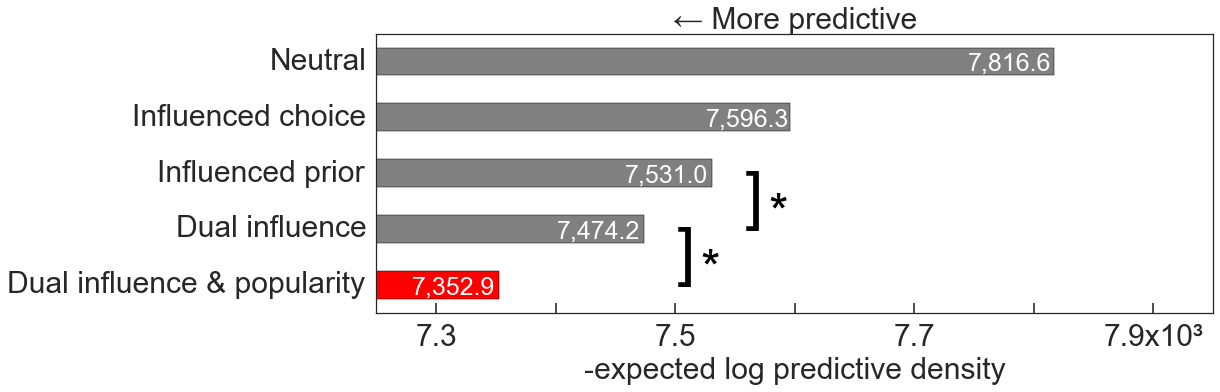

In [67]:
# Social, Rescorla-Wagner
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (15.0, 5.0) # Make the inline plot image bigger
comparison_labels = ['Dual influence & popularity','Dual influence','Influenced prior','Influenced choice', 'Neutral']
comparison_elpds = [7352.9, 7474.2, 7531.0, 7596.3, 7816.6]
comparison_errors = [219.8, 227.5, 219.5, 230.1, 227.9]
xticklabels = ['7.3','','7.5','','7.7','',u'7.9x10\u00B3']
ax = pd.DataFrame(comparison_elpds,index=comparison_labels).plot(kind='barh', legend=False, xlim=[7250,7950], fontsize=30, color=['red','grey','grey','grey','grey'])
ax.set_title(u'\u2190 More predictive', size=30)
ax.set_xticks([7300,7400,7500,7600,7700,7800,7900])
ax.set_xticklabels(xticklabels)
ax.set_xlabel(u'-expected log predictive density', size=30)
ax.xaxis.set_tick_params(size=10)
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', direction='in')
ax.text(7745.6,3.85,'7,816.6', size=25, color='white')
ax.text(7526.3,2.85,'7,596.3', size=25, color='white')
ax.text(7459,1.85,'7,531.0', size=25, color='white')

ax.text(7559,1.2,']', size=65, color='black')
ax.text(7579,1,'*', size=50, color='black')

ax.text(7402.2,0.85,'7,474.2', size=25, color='white')

ax.text(7502.2,0.2,']', size=65, color='black')
ax.text(7522.2,0,'*', size=50, color='black')

ax.text(7280.9,-0.15,'7,352.9', size=25, color='white')
plt.savefig('../figures/supp-fig2-loo_comparison_social_rw.pdf', bbox_inches='tight')

###Model Fit Visualization & Quantification

Next, we visualize and quantify the average performance predictions of our best-fitting model compared to the data.

In [51]:
model_dual_insight_bayesian_noeye = pickle.load(open('stan/pickles/model_dual_insight_bayesian_noeye.pkl', 'rb'))
fit_dual_insight_bayesian_noeye = pickle.load(open('stan/pickles/fit_dual_insight_bayesian_noeye.pkl', 'rb'))

model_dual_insight_bayesian_noeye_non_social = pickle.load(open('stan/pickles/model_dual_insight_bayesian_noeye_non_social.pkl', 'rb'))
fit_dual_insight_bayesian_noeye_non_social = pickle.load(open('stan/pickles/fit_dual_insight_bayesian_noeye_non_social.pkl', 'rb'))


####Response times

In [52]:
# What is the highest RT in the SOCIAL data set?
data_rt = data[data['practice_loop_thisRepN'].isnull() & data['pair_rep']>0].copy() # Only non-practice learning trials
data_rt.reset_index(inplace=True)
data_rt.infer_resp_rt.max()

10.566319740599999

In [53]:
# What is the highest RT in the NON-SOCIAL data set?
control_data_rt = control_data[control_data['practice_loop_thisRepN'].isnull() & control_data['pair_rep']>0].copy() # Only non-practice learning trials
control_data_rt.reset_index(inplace=True)
control_data_rt.infer_resp_rt.max()

15.516334394699999

In [54]:
# Calculate each participant's RT mean and standard deviation
for i in range(len(data_rt)):
    p = data_rt.loc[i,'participant']
    data_rt.loc[i,'infer_resp_rt_mean'] = data_rt[data_rt.participant==p].infer_resp_rt.mean()
    data_rt.loc[i,'infer_resp_rt_std'] = data_rt[data_rt.participant==p].infer_resp_rt.std()
    
for i in range(len(control_data_rt)):
    p = control_data_rt.loc[i,'participant']
    control_data_rt.loc[i,'infer_resp_rt_mean'] = control_data_rt[control_data_rt.participant==p].infer_resp_rt.mean()
    control_data_rt.loc[i,'infer_resp_rt_std'] = control_data_rt[control_data_rt.participant==p].infer_resp_rt.std()

We generate response time predictions from our model at 10ms resolution, from 0 to 10.57 seconds (or 1,057 values of 10ms). 

For each data point, we use the mean estimate for the four drift rate parameters to generate an array of RT probability density values from 0 to 10.57s in 10ms steps (using the combined PDF for both correct and incorrect responses). We use the RWiener function "dwiener" (Wabersich and Vandekerckhove, 2014, R Journal) to generate these values. 

With a PDF array for each data point, we can then create a mean PDF array based on different data groupings (e.g. shared preference versus different preference).

In [ ]:
%R library(lme4) 
%R library(RWiener)

# Social

#model = pickle.load(open('stan/revisions/pickles/model_dual_insight_bayesian_noeye', 'rb'))
#fit = pickle.load(open('stan/revisions/pickles/fit_dual_insight_bayesian_noeye', 'rb'))
model = model_dual_insight_bayesian_noeye
fit = fit_dual_insight_bayesian_noeye
%R time = seq(0,10.57, length.out=1058)
a_samples = fit['threshold_int']
a_means = np.mean(a_samples, axis=0) # CHECK! Mean threshold parameter estimate across samples
a_means = np.repeat(a_means,600)
ti_samples = fit['non_decision_time_int']
ti_means = np.mean(ti_samples, axis=0)
ti_means = np.repeat(ti_means,600)
v_samples = fit['v_store']
v_means = np.mean(v_samples, axis=0)
b_samples = fit['b_store']
b_means = np.mean(b_samples, axis=0)

pdfs = np.empty([18600,1058])
pdfs_correct = np.empty([18600,1058])
pdfs_wrong = np.empty([18600,1058])

for i in range(len(data_rt)):
    a = a_means[i]
    ti = ti_means[i]
    b = b_means[i]
    v = v_means[i]
    %Rpush a
    %Rpush ti
    %Rpush b
    %Rpush v
    %R pdf = lapply(time, dwiener, alpha=a, tau=ti, beta=b, delta=v, resp="both")
    %R pdf_correct = lapply(time, dwiener, alpha=a, tau=ti, beta=b, delta=v, resp="upper")
    %R pdf_wrong = lapply(time, dwiener, alpha=a, tau=ti, beta=b, delta=v, resp="lower")
    %R -o pdf -o pdf_correct -o pdf_wrong

    pdfs[i,:] = np.array(pdf)[:,0]
    pdfs_correct[i,:] = np.array(pdf_correct)[:,0]
    pdfs_wrong[i,:] = np.array(pdf_wrong)[:,0]
    print 'social ', i

    # Save pdfs
np.save('stan/revisions/pickles/rt_predictions/pdfs_social.npy', pdfs)
np.save('stan/revisions/pickles/rt_predictions/pdfs_correct_social.npy', pdfs_correct)
np.save('stan/revisions/pickles/rt_predictions/pdfs_wrong_social.npy', pdfs_wrong)



# Non-social

#model = pickle.load(open('stan/revisions/non_social/pickles/model_dual_bayesian_noeye_non_social', 'rb'))
#fit = pickle.load(open('stan/revisions/non_social/pickles/fit_dual_bayesian_noeye_non_social', 'rb'))
model = model_dual_bayesian_noeye_non_social
fit = fit_dual_bayesian_noeye_non_social
%R time = seq(0,15.52, length.out=1552)
a_samples = fit['threshold_int']
a_means = np.mean(a_samples, axis=0) # CHECK! Mean threshold parameter estimate across samples
a_means = np.repeat(a_means,600)
ti_samples = fit['non_decision_time_int']
ti_means = np.mean(ti_samples, axis=0)
ti_means = np.repeat(ti_means,600)
v_samples = fit['v_store']
v_means = np.mean(v_samples, axis=0)
b_samples = fit['b_store']
b_means = np.mean(b_samples, axis=0)

pdfs = np.empty([18000,1552])
pdfs_correct = np.empty([18000,1552])
pdfs_wrong = np.empty([18000,1552])

for i in range(len(control_data_rt)):
    a = a_means[i]
    ti = ti_means[i]
    b = b_means[i]
    v = v_means[i]
    %Rpush a
    %Rpush ti
    %Rpush b
    %Rpush v
    %R pdf = lapply(time, dwiener, alpha=a, tau=ti, beta=b, delta=v, resp="both")
    %R pdf_correct = lapply(time, dwiener, alpha=a, tau=ti, beta=b, delta=v, resp="upper")
    %R pdf_wrong = lapply(time, dwiener, alpha=a, tau=ti, beta=b, delta=v, resp="lower")
    %R -o pdf -o pdf_correct -o pdf_wrong

    pdfs[i,:] = np.array(pdf)[:,0]
    pdfs_correct[i,:] = np.array(pdf_correct)[:,0]
    pdfs_wrong[i,:] = np.array(pdf_wrong)[:,0]
    print 'non-social ', i

    # Save pdfs
np.save('stan/revisions/pickles/rt_predictions/pdfs_non_social.npy', pdfs)
np.save('stan/revisions/pickles/rt_predictions/pdfs_correct_non_social.npy', pdfs_correct)
np.save('stan/revisions/pickles/rt_predictions/pdfs_wrong_non_social.npy', pdfs_wrong)

Load the model prediction pickles. Note that these are too big for GitHub, but are available on request. They can also be generated locally using the code above.

In [55]:
# Add RT model predictions to data frames

# Social
pdfs_social = np.load('stan/pickles/rt_predictions/pdfs_social.npy')
pdfs_correct_social = np.load('stan/pickles/rt_predictions/pdfs_correct_social.npy')
pdfs_wrong_social = np.load('stan/pickles/rt_predictions/pdfs_wrong_social.npy')

for i in range(len(data_rt)):
    weighted = pdfs_social[i]*np.arange(0,10.58,0.01)
    mean_rt = weighted.sum() / pdfs_social[i].sum()
    data_rt.loc[i,'model_rt'] = mean_rt

# Non-social
pdfs_non_social = np.load('stan/pickles/rt_predictions/pdfs_non_social.npy')
pdfs_correct_non_social = np.load('stan/pickles/rt_predictions/pdfs_correct_non_social.npy')
pdfs_wrong_non_social = np.load('stan/pickles/rt_predictions/pdfs_wrong_non_social.npy')

for i in range(len(control_data_rt)):
    weighted = pdfs_non_social[i]*np.arange(0,15.52,0.01)
    mean_rt = weighted.sum() / pdfs_non_social[i].sum()
    control_data_rt.loc[i,'model_rt'] = mean_rt

In [56]:
# Calculate model's predicted RT mean and standard deviation for each participant
for i in range(len(data_rt)):
    p = data_rt.loc[i,'participant']
    data_rt.loc[i,'model_rt_mean'] = data_rt[data_rt.participant==p].model_rt.mean()
    data_rt.loc[i,'model_rt_std'] = data_rt[data_rt.participant==p].model_rt.std()
    
for i in range(len(control_data_rt)):
    p = control_data_rt.loc[i,'participant']
    control_data_rt.loc[i,'model_rt_mean'] = control_data_rt[control_data_rt.participant==p].model_rt.mean()
    control_data_rt.loc[i,'model_rt_std'] = control_data_rt[control_data_rt.participant==p].model_rt.std()
    
# Convert each trial's prediction into a predicted z-score
data_rt.loc[:,'model_rt_z'] = (data_rt.loc[:,'model_rt'] - data_rt.loc[:,'model_rt_mean']) / data_rt.loc[:,'model_rt_std']
control_data_rt.loc[:,'model_rt_z'] = (control_data_rt.loc[:,'model_rt'] - control_data_rt.loc[:,'model_rt_mean']) / control_data_rt.loc[:,'model_rt_std']

In [258]:
# Put prediction distributions in terms of z-scores (rather than milliseconds)

# SOCIAL
# Add a dimension to the PDF arrays to include the z-score, rather than just using the index
pdfs_social_z = np.zeros((18600,1058,2))
pdfs_social_z[:,:,0] = range(1058)
pdfs_social_z[:,:,1] = pdfs_social[:,:]

# Now convert the 't' to the z-score for that participant
for i in range(len(data_rt)):
    rt_mean = data_rt.loc[i,'model_rt_mean']
    rt_std = data_rt.loc[i,'model_rt_std']
    rt_pdf = pdfs_social_z[i,:,0] / 100
    pdfs_social_z[i,:,0] = (rt_pdf - rt_mean) / rt_std
    
# NON-SOCIAL
# Add a dimension to the PDF arrays to include the z-score, rather than just using the index
pdfs_non_social_z = np.zeros((18000,1552,2))
pdfs_non_social_z[:,:,0] = range(1552)
pdfs_non_social_z[:,:,1] = pdfs_non_social[:,:]

# Now convert the 't' to the z-score for that participant
for i in range(len(control_data_rt)):
    rt_mean = control_data_rt.loc[i,'model_rt_mean']
    rt_std = control_data_rt.loc[i,'model_rt_std']
    rt_pdf = pdfs_non_social_z[i,:,0] / 100
    pdfs_non_social_z[i,:,0] = (rt_pdf - rt_mean) / rt_std

In [57]:
# SOCIAL
pdfs_social = np.load('stan/pickles/rt_predictions/pdfs_social.npy')
pdfs_correct_social = np.load('stan/pickles/rt_predictions/pdfs_correct_social.npy')
pdfs_wrong_social = np.load('stan/pickles/rt_predictions/pdfs_wrong_social.npy')

# Break down predicted RT distributions by preference congruence (dv >0 or <0)
data_rt.reset_index(inplace=True)
# Find the indices for congruent and incongruent trials
cong_indices_social = data_rt[data_rt.response_matches_preference_bid==1].index
incong_indices_social = data_rt[data_rt.response_matches_preference_bid==0].index

# Subset of PDF arrays for congruent trials
pdfs_cong_all_social = pdfs_social[cong_indices_social,:] # both correct and incorrect RTs
pdfs_cong_correct_social = pdfs_correct_social[cong_indices_social,:] # correct RTs
pdfs_cong_wrong_social = pdfs_wrong_social[cong_indices_social,:] # incorrect RTs

# Subset for incongruent trials
pdfs_incong_all_social = pdfs_social[incong_indices_social,:]
pdfs_incong_correct_social = pdfs_correct_social[incong_indices_social,:]
pdfs_incong_wrong_social = pdfs_wrong_social[incong_indices_social,:]


# NON-SOCIAL
pdfs_non_social = np.load('stan/pickles/rt_predictions/pdfs_non_social.npy')
pdfs_correct_non_social = np.load('stan/pickles/rt_predictions/pdfs_correct_non_social.npy')
pdfs_wrong_non_social = np.load('stan/pickles/rt_predictions/pdfs_wrong_non_social.npy')

# Break down predicted RT distributions by preference congruence (dv >0 or <0)
control_data_rt.reset_index(inplace=True)
# Find the indices for congruent and incongruent trials
cong_indices_non_social = control_data_rt[control_data_rt.response_matches_preference_bid==1].index
incong_indices_non_social = control_data_rt[control_data_rt.response_matches_preference_bid==0].index

# Subset of PDF arrays for congruent trials
pdfs_cong_all_non_social = pdfs_non_social[cong_indices_non_social,:] # both correct and incorrect RTs
pdfs_cong_correct_non_social = pdfs_correct_non_social[cong_indices_non_social,:] # correct RTs
pdfs_cong_wrong_non_social = pdfs_wrong_non_social[cong_indices_non_social,:] # incorrect RTs

# Subset for incongruent trials
pdfs_incong_all_non_social = pdfs_non_social[incong_indices_non_social,:]
pdfs_incong_correct_non_social = pdfs_correct_non_social[incong_indices_non_social,:]
pdfs_incong_wrong_non_social = pdfs_wrong_non_social[incong_indices_non_social,:]


In [270]:
pdfs_cong_all_social[4456,:].sum()

100.00000000030464

In [274]:
pdfs_social.sum() / 100.0

18599.881173035057

##Supplementary Table 21: Response time quartiles, data and model predictions

We calculate the quartiles of the mean of the model's response time PDF. This mean PDF (of length 1058, for 10.58 seconds) sums to 100. So we find the index for where the cumulative sum equals the percentile we're interested in.

In [304]:
# Social group

print "SOCIAL GROUP"
print "25th percentile"
print "Model: ", (len(np.where(pdfs_social.mean(axis=0).cumsum()<=25)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data.infer_resp_rt.quantile(0.25), ' seconds'

print '' 

print "50th percentile"
print "Model: ", (len(np.where(pdfs_social.mean(axis=0).cumsum()<=50)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data.infer_resp_rt.quantile(0.5), ' seconds'

print ''

print "75th percentile"
print "Model: ", (len(np.where(pdfs_social.mean(axis=0).cumsum()<=75)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data.infer_resp_rt.quantile(0.75), ' seconds'

SOCIAL GROUP
25th percentile
Model:  0.76  seconds
Data:  0.766602101238  seconds

50th percentile
Model:  0.95  seconds
Data:  0.933294521851  seconds

75th percentile
Model:  1.25  seconds
Data:  1.23322154479  seconds


In [318]:
len(data.infer_resp_rt) - data.infer_resp_rt.isnull().sum()

18596

In [338]:
# Social group - congruent only

print "SOCIAL GROUP - CONGRUENT"
print "25th percentile"
print "Model: ", (len(np.where(pdfs_cong_all_social.mean(axis=0).cumsum()<=25)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data[data.response_matches_preference_bid==1].infer_resp_rt.quantile(0.25), ' seconds'

print '' 

print "50th percentile"
print "Model: ", (len(np.where(pdfs_cong_all_social.mean(axis=0).cumsum()<=50)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data[data.response_matches_preference_bid==1].infer_resp_rt.quantile(0.5), ' seconds'

print ''

print "75th percentile"
print "Model: ", (len(np.where(pdfs_cong_all_social.mean(axis=0).cumsum()<=75)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data[data.response_matches_preference_bid==1].infer_resp_rt.quantile(0.75), ' seconds'

SOCIAL GROUP - CONGRUENT
25th percentile
Model:  0.75  seconds
Data:  0.749975232109  seconds

50th percentile
Model:  0.92  seconds
Data:  0.900002366318  seconds

75th percentile
Model:  1.22  seconds
Data:  1.18321943888  seconds


In [339]:
len(data[data.response_matches_preference_bid==1].infer_resp_rt) - data[data.response_matches_preference_bid==1].infer_resp_rt.isnull().sum()

10962

In [340]:
# Social group - incongruent only

print "SOCIAL GROUP - INCONGRUENT"
print "25th percentile"
print "Model: ", (len(np.where(pdfs_incong_all_social.mean(axis=0).cumsum()<=25)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data[data.response_matches_preference_bid==0].infer_resp_rt.quantile(0.25), ' seconds'

print '' 

print "50th percentile"
print "Model: ", (len(np.where(pdfs_incong_all_social.mean(axis=0).cumsum()<=50)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data[data.response_matches_preference_bid==0].infer_resp_rt.quantile(0.5), ' seconds'

print ''

print "75th percentile"
print "Model: ", (len(np.where(pdfs_incong_all_social.mean(axis=0).cumsum()<=75)[0]) - 1) / 100.0, ' seconds'
print "Data: ", data[data.response_matches_preference_bid==0].infer_resp_rt.quantile(0.75), ' seconds'

SOCIAL GROUP - INCONGRUENT
25th percentile
Model:  0.79  seconds
Data:  0.799852418692  seconds

50th percentile
Model:  0.99  seconds
Data:  0.98329103408  seconds

75th percentile
Model:  1.31  seconds
Data:  1.31656165794  seconds


In [341]:
len(data[data.response_matches_preference_bid==0].infer_resp_rt) - data[data.response_matches_preference_bid==0].infer_resp_rt.isnull().sum()

6524

In [305]:
# Non-social group

print "NON-SOCIAL GROUP"
print "25th percentile"
print "Model: ", (len(np.where(pdfs_non_social.mean(axis=0).cumsum()<=25)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data.infer_resp_rt.quantile(0.25), ' seconds'

print '' 

print "50th percentile"
print "Model: ", (len(np.where(pdfs_non_social.mean(axis=0).cumsum()<=50)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data.infer_resp_rt.quantile(0.5), ' seconds'

print ''

print "75th percentile"
print "Model: ", (len(np.where(pdfs_non_social.mean(axis=0).cumsum()<=75)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data.infer_resp_rt.quantile(0.75), ' seconds'

NON-SOCIAL GROUP
25th percentile
Model:  0.78  seconds
Data:  0.800094995121  seconds

50th percentile
Model:  0.99  seconds
Data:  0.983477631667  seconds

75th percentile
Model:  1.34  seconds
Data:  1.31643567746  seconds


In [321]:
len(control_data.infer_resp_rt) - control_data.infer_resp_rt.isnull().sum()

17999

In [309]:
# Non-social group - congruent only

print "NON-SOCIAL GROUP - CONGRUENT"
print "25th percentile"
print "Model: ", (len(np.where(pdfs_cong_all_non_social.mean(axis=0).cumsum()<=25)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data[control_data.response_matches_preference==1].infer_resp_rt.quantile(0.25), ' seconds'

print '' 

print "50th percentile"
print "Model: ", (len(np.where(pdfs_cong_all_non_social.mean(axis=0).cumsum()<=50)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data[control_data.response_matches_preference==1].infer_resp_rt.quantile(0.5), ' seconds'

print ''

print "75th percentile"
print "Model: ", (len(np.where(pdfs_cong_all_non_social.mean(axis=0).cumsum()<=75)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data[control_data.response_matches_preference==1].infer_resp_rt.quantile(0.75), ' seconds'

NON-SOCIAL GROUP - CONGRUENT
25th percentile
Model:  0.77  seconds
Data:  0.766881806543  seconds

50th percentile
Model:  0.97  seconds
Data:  0.950209812383  seconds

75th percentile
Model:  1.33  seconds
Data:  1.26683522531  seconds


In [342]:
len(control_data[control_data.response_matches_preference_bid==1].infer_resp_rt) - control_data[control_data.response_matches_preference_bid==1].infer_resp_rt.isnull().sum()

9868

In [310]:
# Non-social group - incongruent only

print "NON-SOCIAL GROUP - INCONGRUENT"
print "25th percentile"
print "Model: ", (len(np.where(pdfs_incong_all_non_social.mean(axis=0).cumsum()<=25)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data[control_data.response_matches_preference==0].infer_resp_rt.quantile(0.25), ' seconds'

print '' 

print "50th percentile"
print "Model: ", (len(np.where(pdfs_incong_all_non_social.mean(axis=0).cumsum()<=50)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data[control_data.response_matches_preference==0].infer_resp_rt.quantile(0.5), ' seconds'

print ''

print "75th percentile"
print "Model: ", (len(np.where(pdfs_incong_all_non_social.mean(axis=0).cumsum()<=75)[0]) - 1) / 100.0, ' seconds'
print "Data: ", control_data[control_data.response_matches_preference==0].infer_resp_rt.quantile(0.75), ' seconds'

NON-SOCIAL GROUP - INCONGRUENT
25th percentile
Model:  0.8  seconds
Data:  0.833293300561  seconds

50th percentile
Model:  1.01  seconds
Data:  1.01690430521  seconds

75th percentile
Model:  1.36  seconds
Data:  1.36679317406  seconds


In [343]:
len(control_data[control_data.response_matches_preference_bid==0].infer_resp_rt) - control_data[control_data.response_matches_preference_bid==0].infer_resp_rt.isnull().sum()

7111

##Performance data/model prediction differences

In [58]:
# Generate model predictions from Stan fit
# SOCIAL
fit_dual_insight_bayesian_noeye_df = pd.DataFrame(fit_dual_insight_bayesian_noeye['log_lik_resp']).transpose()

pred_data_social = data.copy()
pred_data_social = pred_data_social[pred_data_social['block_loop_thisN'].notnull() & pred_data_social['img_correct'].notnull()]
pred_data_social = pred_data_social.reset_index(drop=True)

pred_data_social['lik_fit_dual_insight_bayesian_noeye'] = np.exp(fit_dual_insight_bayesian_noeye_df.mean(axis=1))
pred_data_social.loc[(pred_data_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye'] = pred_data_social['lik_fit_dual_insight_bayesian_noeye']
pred_data_social.loc[(pred_data_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye'] = 1 - pred_data_social['lik_fit_dual_insight_bayesian_noeye']

# NON-SOCIAL
fit_dual_insight_bayesian_noeye_non_social_df = pd.DataFrame(fit_dual_insight_bayesian_noeye_non_social['log_lik_resp']).transpose()

pred_data_non_social = control_data.copy()
pred_data_non_social = pred_data_non_social[pred_data_non_social['block_loop_thisN'].notnull() & pred_data_non_social['img_correct'].notnull()]
pred_data_non_social = pred_data_non_social.reset_index(drop=True)

pred_data_non_social['lik_fit_dual_insight_bayesian_noeye_non_social'] = np.exp(fit_dual_insight_bayesian_noeye_non_social_df.mean(axis=1))
pred_data_non_social.loc[(pred_data_non_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye_non_social'] = pred_data_non_social['lik_fit_dual_insight_bayesian_noeye_non_social']
pred_data_non_social.loc[(pred_data_non_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye_non_social'] = 1 - pred_data_non_social['lik_fit_dual_insight_bayesian_noeye_non_social']


What's the average likelihood of the response given the model?

In [351]:
model_deviation_over_learning_social = pred_data_i.groupby('pair_rep').pred_fit_dual_insight_bayesian_noeye.mean() - data.groupby('pair_rep').response_correct.mean()

In [352]:
model_deviation_over_learning_social.mean()

0.010155667571884823

In [363]:
model_deviation_over_learning_social.sem()

0.0043745404875430525

In [353]:
model_deviation_over_learning_social

pair_rep
1    -0.090550
2    -0.016977
3    -0.007749
4     0.015106
5     0.016505
6     0.019925
7     0.021626
8     0.040996
9     0.029649
10    0.035915
11    0.039446
12    0.036137
13    0.034008
14    0.030807
15    0.015854
16    0.012042
17    0.008997
18    0.003395
19    0.009091
20    0.011234
21   -0.000622
22    0.011652
23    0.006140
24    0.009570
25   -0.000074
26    0.004730
27    0.004774
28    0.001550
29    0.001548
30   -0.000055
dtype: float64

In [360]:
model_deviation_over_learning_non_social = pred_data_non_social.groupby('pair_rep').pred_fit_dual_insight_bayesian_noeye_non_social.mean() - control_data.groupby('pair_rep').response_correct.mean()

In [357]:
control_data.groupby('pair_rep').response_correct.mean()

pair_rep
1     0.533333
2     0.638333
3     0.706667
4     0.775000
5     0.793333
6     0.835000
7     0.838333
8     0.875000
9     0.876667
10    0.880000
11    0.878333
12    0.898333
13    0.913333
14    0.910000
15    0.920000
16    0.918333
17    0.921667
18    0.938333
19    0.938333
20    0.941667
21    0.938333
22    0.938333
23    0.943333
24    0.956667
25    0.960000
26    0.946667
27    0.945000
28    0.956667
29    0.946667
30    0.950000
Name: response_correct, dtype: float64

In [361]:
model_deviation_over_learning_non_social.mean()

0.015227773589677437

In [364]:
model_deviation_over_learning_non_social.sem()

0.003701308717883078

In [59]:
# Social
model_means_cong_social = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_incong_social = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_all_social = pred_data_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()

data_means_cong_social = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong_social = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all_social = pred_data_social.groupby(['pair_rep']).response_correct.mean()


# Non-social
model_means_cong_non_social = pred_data_non_social[pred_data_non_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye_non_social.mean()
model_means_incong_non_social = pred_data_non_social[pred_data_non_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye_non_social.mean()
model_means_all_non_social = pred_data_non_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye_non_social.mean()

data_means_cong_non_social = pred_data_non_social[pred_data_non_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong_non_social = pred_data_non_social[pred_data_non_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all_non_social = pred_data_non_social.groupby(['pair_rep']).response_correct.mean()


In [372]:
model_dev_cong_social = model_means_cong_social - data_means_cong_social
model_dev_incong_social = model_means_incong_social - data_means_incong_social
model_dev_cong_non_social = model_means_cong_non_social - data_means_cong_non_social
model_dev_incong_non_social = model_means_incong_non_social - data_means_incong_non_social

In [373]:
print model_dev_cong_social.mean()
print model_dev_incong_social.mean()
print model_dev_cong_non_social.mean()
print model_dev_incong_non_social.mean()

0.00475928692653
0.0189628939796
0.00304505943207
0.0338472817832


##Supplementary Table 22: Permutation tests of model fit for first versus second trials

Permutation test to see if the log likelihood for the first and second trials are different.

In [12]:
lik_first_two = pred_data_i[pred_data_i.pair_rep<3]
lik_first_two_ns = pred_data_i_ns[pred_data_i_ns.pair_rep<3]

%Rpush lik_first_two
%Rpush lik_first_two_ns

In [14]:
%%R
library(perm)
lik <- lik_first_two$lik_fit_dual_insight_bayesian_noeye
trial <- lik_first_two$pair_rep
permTS(lik~trial,alternative="less",method="pclt")


	Permutation Test using Asymptotic Approximation

data:  lik by trial
Z = -12.654, p-value < 2.2e-16
alternative hypothesis: true mean trial=1 - mean trial=2 is less than 0
sample estimates:
mean trial=1 - mean trial=2 
                 -0.1785278 



In [15]:
%%R
library(perm)
lik <- lik_first_two_ns$lik_fit_dual_insight_bayesian_noeye_non_social
trial <- lik_first_two_ns$pair_rep
permTS(lik~trial,alternative="less",method="pclt")


	Permutation Test using Asymptotic Approximation

data:  lik by trial
Z = -7.1807, p-value = 3.469e-13
alternative hypothesis: true mean trial=1 - mean trial=2 is less than 0
sample estimates:
mean trial=1 - mean trial=2 
                 -0.1056679 



###Parameter Estimate Plot

In [60]:
def param_plot(data, ax=None, color='blue', fill_color='blue', shade=True, alpha=0.5):
    data = np.atleast_2d(data.T).T
    for i in range(data.shape[1]):
        d = data[:, i]
        density = ss.kde.gaussian_kde(d)
        l = np.min(d)
        u = np.max(d)
        x = np.linspace(0, 1, 100) * (u - l) + l

        if ax==None:
            plt.plot(x, density(x), color=color)
            if shade==True:
                plt.fill(x, density(x), alpha=alpha, color=fill_color)
        else:
            ax.plot(x, density(x), color=color)
            if shade==True:
                ax.fill(x, density(x), alpha=alpha, color=fill_color)

##Figure 6b: Influence parameter estimates

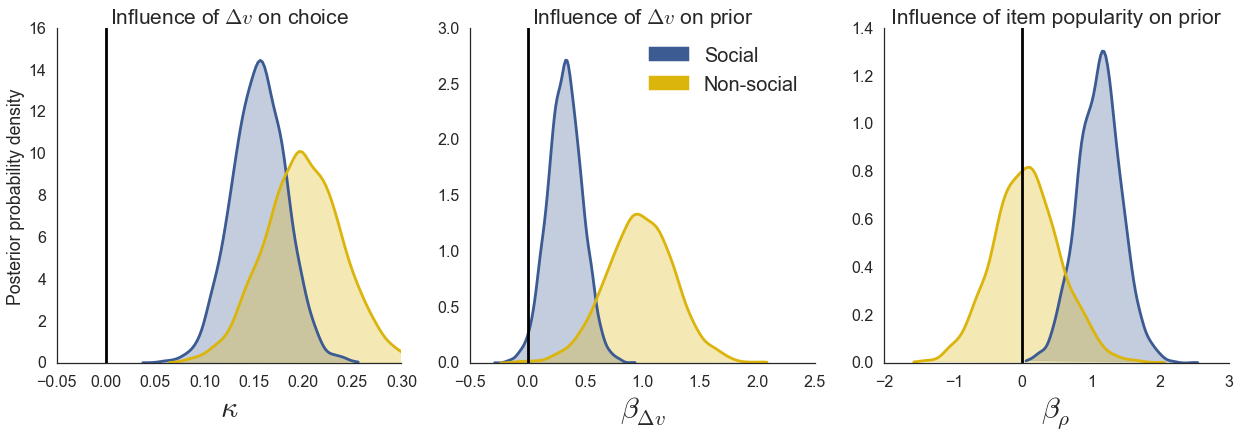

In [64]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (21, 6)

social_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Social')
non_social_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='Non-social')

fig, ax = pl.subplots(1,3,squeeze=False)
plt.suptitle(' ', size=24)
param_plot(fit_dual_insight_bayesian_noeye['insight_mean'], ax[0,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_dual_insight_bayesian_noeye_non_social['insight_mean'], ax[0,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[0,2].set_xlabel('$\\beta_{\\rho}$', size=30)
ax[0,2].set_title('Influence of item popularity on prior', size=21)
ax[0,2].axvline(x=0,color='black')
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)
#ax[0,2].set_ylim([0,14])
#ax[0,2].set_xlim([-0.3,0.7])

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_prior_mean'], ax[0,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_prior_mean'], ax[0,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[0,1].set_xlabel('$\\beta_{\Delta v}$', size=30)
ax[0,1].set_title('Influence of $\Delta v$ on prior', size=21)
ax[0,1].axvline(x=0,color='black')
ax[0,1].legend(handles=[social_patch, non_social_patch], loc=1, fontsize=20)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
#ax[0,1].set_ylim([0,14])
#ax[0,1].set_xlim([-0.3,0.7])

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_drift_bias_mean'], ax[0,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_drift_bias_mean'], ax[0,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[0,0].set_ylabel('Posterior probability density')
ax[0,0].set_xlabel('$\kappa$', size=30)
ax[0,0].set_title('Influence of $\Delta v$ on choice', size=21)
ax[0,0].axvline(x=0,color='black')
#ax[0,0].set_ylim([0,14])
ax[0,0].set_xlim([-0.05,0.3])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)



plt.savefig('../figures/fig6b-parameter_estimate_insight_group_means_triptych_two_groups.pdf', bbox_inches='tight')

##Supplementary Figures 3 and 4: Full parameter plot for supplementary results

In [6]:
#Load Stan model and fit if necessary
model_dual_insight_bayesian_noeye = pickle.load(open('stan/revisions/pickles/model_dual_insight_bayesian_noeye.pkl', 'rb'))
fit_dual_insight_bayesian_noeye = pickle.load(open('stan/revisions/pickles/fit_dual_insight_bayesian_noeye.pkl', 'rb'))

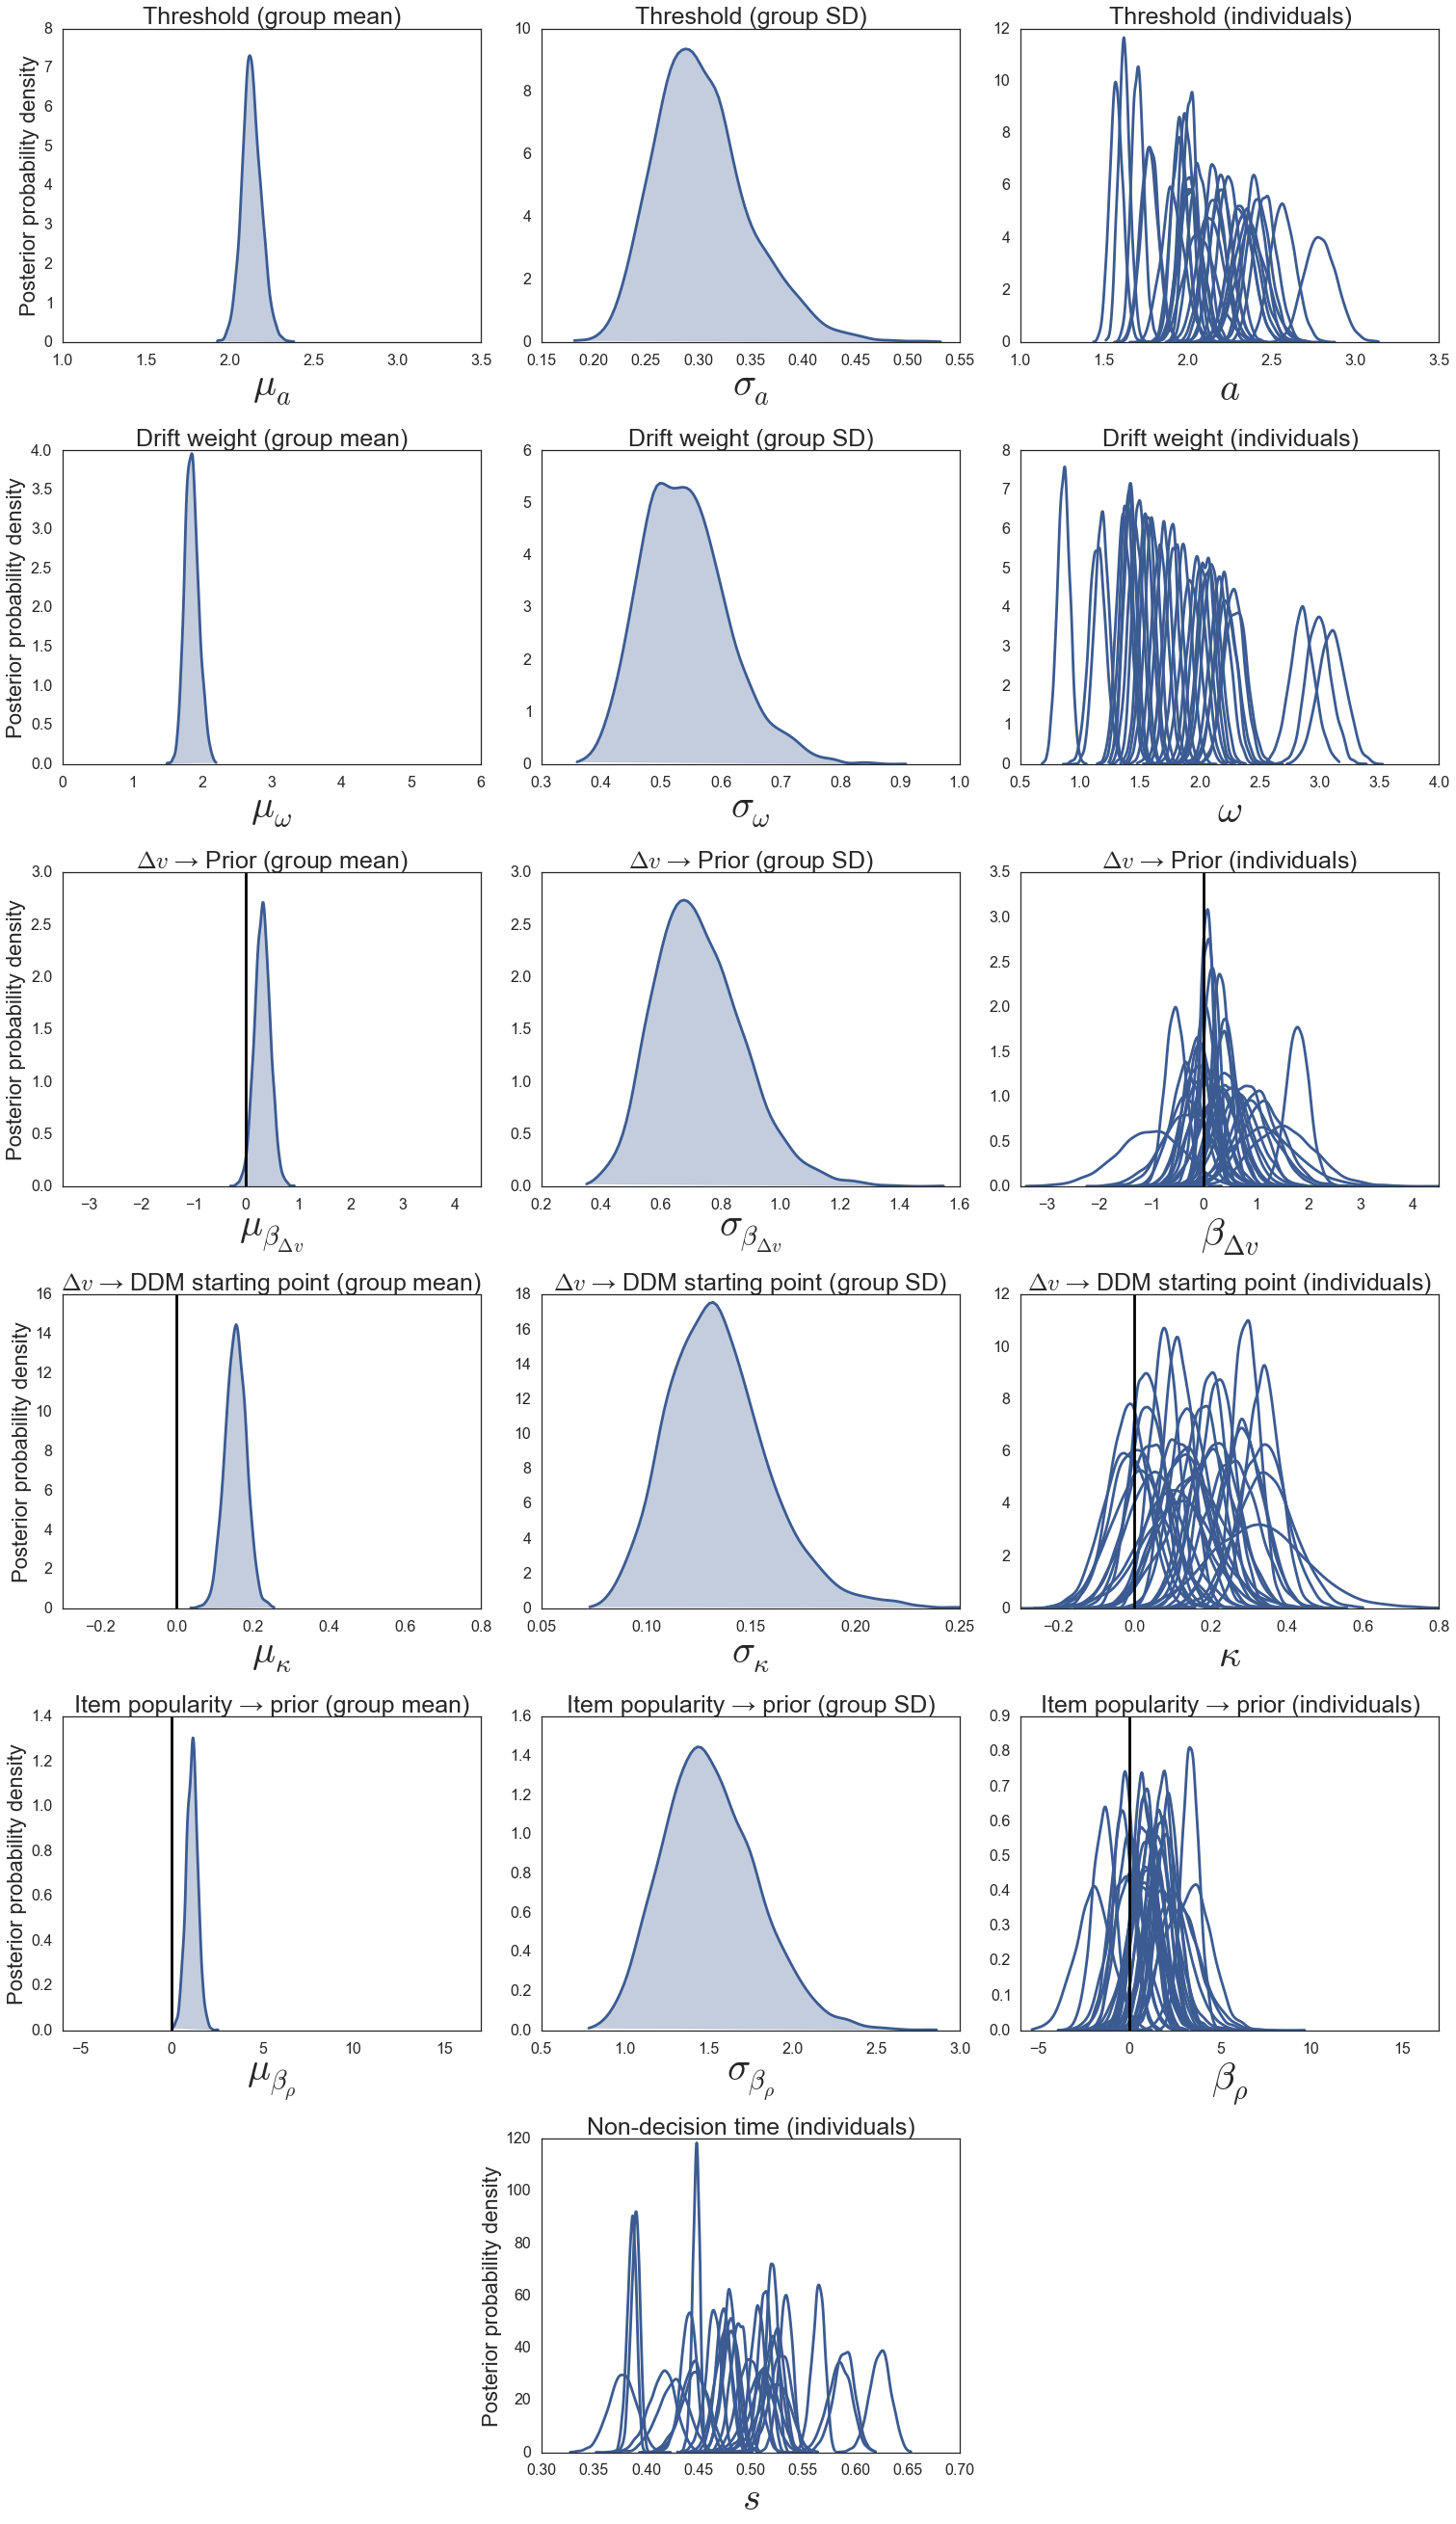

In [71]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (21, 6*6)
fig, ax = pl.subplots(6,3,squeeze=False)
plt.tight_layout(h_pad=4.0)
plt.suptitle(' ', size=24)


# THRESHOLD

param_plot(fit_dual_insight_bayesian_noeye['threshold_int_mean'], ax[0,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
ax[0,0].set_ylabel('Posterior probability density', size=22)
ax[0,0].set_xlabel('$\\mu_{a}$', size=40)
ax[0,0].set_title('Threshold (group mean)', size=25)
#ax[0,0].axvline(x=0,color='black')
#ax[0,0].spines['right'].set_visible(False)
#ax[0,0].spines['top'].set_visible(False)
#ax[0,0].set_ylim([0,14])
ax[0,0].set_xlim([1,3.5])

param_plot(fit_dual_insight_bayesian_noeye['threshold_int_sd'], ax[0,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[0,1].set_xlabel('$\\sigma_{a}$', size=40)
ax[0,1].set_title('Threshold (group SD)', size=25)
#ax[0,1].axvline(x=0,color='black')
#ax[0,1].spines['right'].set_visible(False)
#ax[0,1].spines['top'].set_visible(False)
#ax[0,1].set_ylim([0,14])
#ax[0,1].set_xlim([-0.3,0.7])

param_plot(fit_dual_insight_bayesian_noeye['threshold_int'], ax[0,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0)
ax[0,2].set_xlabel('$a$', size=40)
ax[0,2].set_title('Threshold (individuals)', size=25)
#ax[0,2].axvline(x=0,color='black')
#ax[0,2].set_ylim([0,14])
ax[0,2].set_xlim([1,3.5])
#ax[0,2].spines['right'].set_visible(False)
#ax[0,2].spines['top'].set_visible(False)



# DRIFT WEIGHT

param_plot(fit_dual_insight_bayesian_noeye['drift_rate_learning_mean'], ax[1,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
ax[1,0].set_ylabel('Posterior probability density', size=22)
ax[1,0].set_xlabel('$\\mu_{\omega}$', size=40)
ax[1,0].set_title('Drift weight (group mean)', size=25)
#ax[1,0].axvline(x=0,color='black')
#ax[1,0].spines['right'].set_visible(False)
#ax[1,0].spines['top'].set_visible(False)
#ax[1,0].set_ylim([0,14])
ax[1,0].set_xlim([0,6])

param_plot(fit_dual_insight_bayesian_noeye['drift_rate_learning_sd'], ax[1,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[1,1].set_xlabel('$\\sigma_{\omega}$', size=40)
ax[1,1].set_title('Drift weight (group SD)', size=25)
#ax[1,1].axvline(x=0,color='black')
#ax[1,1].spines['right'].set_visible(False)
#ax[1,1].spines['top'].set_visible(False)
#ax[1,1].set_ylim([0,14])
#ax[1,1].set_xlim([-0.3,0.7])

param_plot(fit_dual_insight_bayesian_noeye['drift_rate_learning'], ax[1,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0)
ax[1,2].set_xlabel('$\\omega$', size=40)
ax[1,2].set_title('Drift weight (individuals)', size=25)
#ax[1,2].axvline(x=0,color='black')
#ax[1,2].set_ylim([0,14])
#ax[1,2].set_xlim([1,3.5])
#ax[1,2].spines['right'].set_visible(False)
#ax[1,2].spines['top'].set_visible(False)




# PRIOR

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_prior_mean'], ax[2,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
ax[2,0].set_ylabel('Posterior probability density', size=22)
ax[2,0].set_xlabel('$\\mu_{\\beta_{\Delta v}}$', size=40)
ax[2,0].set_title(u'$\Delta v$ \u2192 Prior (group mean)', size=25)
ax[2,0].axvline(x=0,color='black')
#ax[2,0].spines['right'].set_visible(False)
#ax[2,0].spines['top'].set_visible(False)
#ax[2,0].set_ylim([0,14])
ax[2,0].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_prior_sd'], ax[2,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[2,1].set_xlabel('$\\sigma_{\\beta_{\Delta v}}$', size=40)
ax[2,1].set_title(u'$\Delta v$ \u2192 Prior (group SD)', size=25)
#ax[2,1].axvline(x=0,color='black')
#ax[2,1].spines['right'].set_visible(False)
#ax[2,1].spines['top'].set_visible(False)
#ax[2,1].set_ylim([0,14])
#ax[2,1].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_prior'], ax[2,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0)
ax[2,2].set_xlabel('$\\beta_{\Delta v}$', size=40)
ax[2,2].set_title(u'$\Delta v$ \u2192 Prior (individuals)', size=25)
ax[2,2].axvline(x=0,color='black')
#ax[2,2].set_ylim([0,14])
ax[2,2].set_xlim([-3.5,4.5])
#ax[2,2].spines['right'].set_visible(False)
#ax[2,2].spines['top'].set_visible(False)





# STARTING POINT BIAS

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_drift_bias_mean'], ax[3,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
ax[3,0].set_ylabel('Posterior probability density', size=22)
ax[3,0].set_xlabel('$\\mu_{\\kappa}$', size=40)
ax[3,0].set_title(u'$\Delta v$ \u2192 DDM starting point (group mean)', size=25)
ax[3,0].axvline(x=0,color='black')
#ax[3,0].spines['right'].set_visible(False)
#ax[3,0].spines['top'].set_visible(False)
#ax[3,0].set_ylim([0,14])
ax[3,0].set_xlim([-0.3,0.8])

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_drift_bias_sd'], ax[3,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
#ax[3,1].set_ylabel('Frequency')
ax[3,1].set_xlabel('$\\sigma_{\\kappa}$', size=40)
ax[3,1].set_title(u'$\Delta v$ \u2192 DDM starting point (group SD)', size=25)
#ax[3,1].axvline(x=0,color='black')
#ax[3,1].spines['right'].set_visible(False)
#ax[3,1].spines['top'].set_visible(False)
#ax[3,1].set_ylim([0,14])
#ax[3,1].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye['cong_weight_drift_bias'], ax[3,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0)
ax[3,2].set_xlabel('$\\kappa$', size=40)
ax[3,2].set_title(u'$\Delta v$ \u2192 DDM starting point (individuals)', size=25)
ax[3,2].axvline(x=0,color='black')
#ax[3,2].set_ylim([0,14])
ax[3,2].set_xlim([-0.3,0.8])
#ax[3,2].spines['right'].set_visible(False)
#ax[3,2].spines['top'].set_visible(False)




# POPULARITY -> PRIOR

param_plot(fit_dual_insight_bayesian_noeye['insight_mean'], ax[4,0], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
ax[4,0].set_ylabel('Posterior probability density', size=22)
ax[4,0].set_xlabel('$\\mu_{\\beta_{\\rho}}$', size=40)
ax[4,0].set_title(u'Item popularity \u2192 prior (group mean)', size=25)
ax[4,0].axvline(x=0,color='black')
#ax[4,0].spines['right'].set_visible(False)
#ax[4,0].spines['top'].set_visible(False)
#ax[4,0].set_ylim([0,14])
ax[4,0].set_xlim([-6,17])

param_plot(fit_dual_insight_bayesian_noeye['insight_sd'], ax[4,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0.3)
#ax[4,1].set_ylabel('Frequency')
ax[4,1].set_xlabel('$\\sigma_{\\beta_{\\rho}}$', size=40)
ax[4,1].set_title(u'Item popularity \u2192 prior (group SD)', size=25)
#ax[4,1].axvline(x=0,color='black')
#ax[4,1].spines['right'].set_visible(False)
#ax[4,1].spines['top'].set_visible(False)
#ax[4,1].set_ylim([0,14])
#ax[4,1].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye['insight'], ax[4,2], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0)
ax[4,2].set_xlabel('$\\beta_{\\rho}$', size=40)
ax[4,2].set_title(u'Item popularity \u2192 prior (individuals)', size=25)
ax[4,2].axvline(x=0,color='black')
#ax[4,2].set_ylim([0,14])
ax[4,2].set_xlim([-6,17])
#ax[4,2].spines['right'].set_visible(False)
#ax[4,2].spines['top'].set_visible(False)


# NON-DECISION TIMES

param_plot(fit_dual_insight_bayesian_noeye['non_decision_time_int'], ax[5,1], color=sns.xkcd_rgb['denim blue'], fill_color=sns.xkcd_rgb['denim blue'], alpha=0)
ax[5,1].set_ylabel('Posterior probability density', size=22)
ax[5,1].set_xlabel('$s$', size=40)
ax[5,1].set_title(u'Non-decision time (individuals)', size=25)
#ax[5,1].axvline(x=0,color='black')
#ax[5,1].spines['right'].set_visible(False)
#ax[5,1].spines['top'].set_visible(False)
#ax[5,1].set_ylim([0,14])
#ax[5,1].set_xlim([-3.5,4.5])


# Turn off axes and labels for unused subplots
ax[5,0].spines['right'].set_visible(False)
ax[5,0].spines['left'].set_visible(False)
ax[5,0].spines['top'].set_visible(False)
ax[5,0].spines['bottom'].set_visible(False)
ax[5,0].get_xaxis().set_visible(False)
ax[5,0].get_yaxis().set_visible(False)

ax[5,2].spines['right'].set_visible(False)
ax[5,2].spines['left'].set_visible(False)
ax[5,2].spines['top'].set_visible(False)
ax[5,2].spines['bottom'].set_visible(False)
ax[5,2].get_xaxis().set_visible(False)
ax[5,2].get_yaxis().set_visible(False)



plt.savefig('../figures/supp-fig3-parameter_estimates_complete_dual_insight_bayesian_noeye_social.pdf', bbox_inches='tight')

In [11]:
model_dual_insight_bayesian_noeye_non_social = pickle.load(open('stan/revisions/non_social/pickles/model_dual_bayesian_noeye_non_social.pkl', 'rb'))
fit_dual_insight_bayesian_noeye_non_social = pickle.load(open('stan/revisions/non_social/pickles/fit_dual_bayesian_noeye_non_social.pkl', 'rb'))


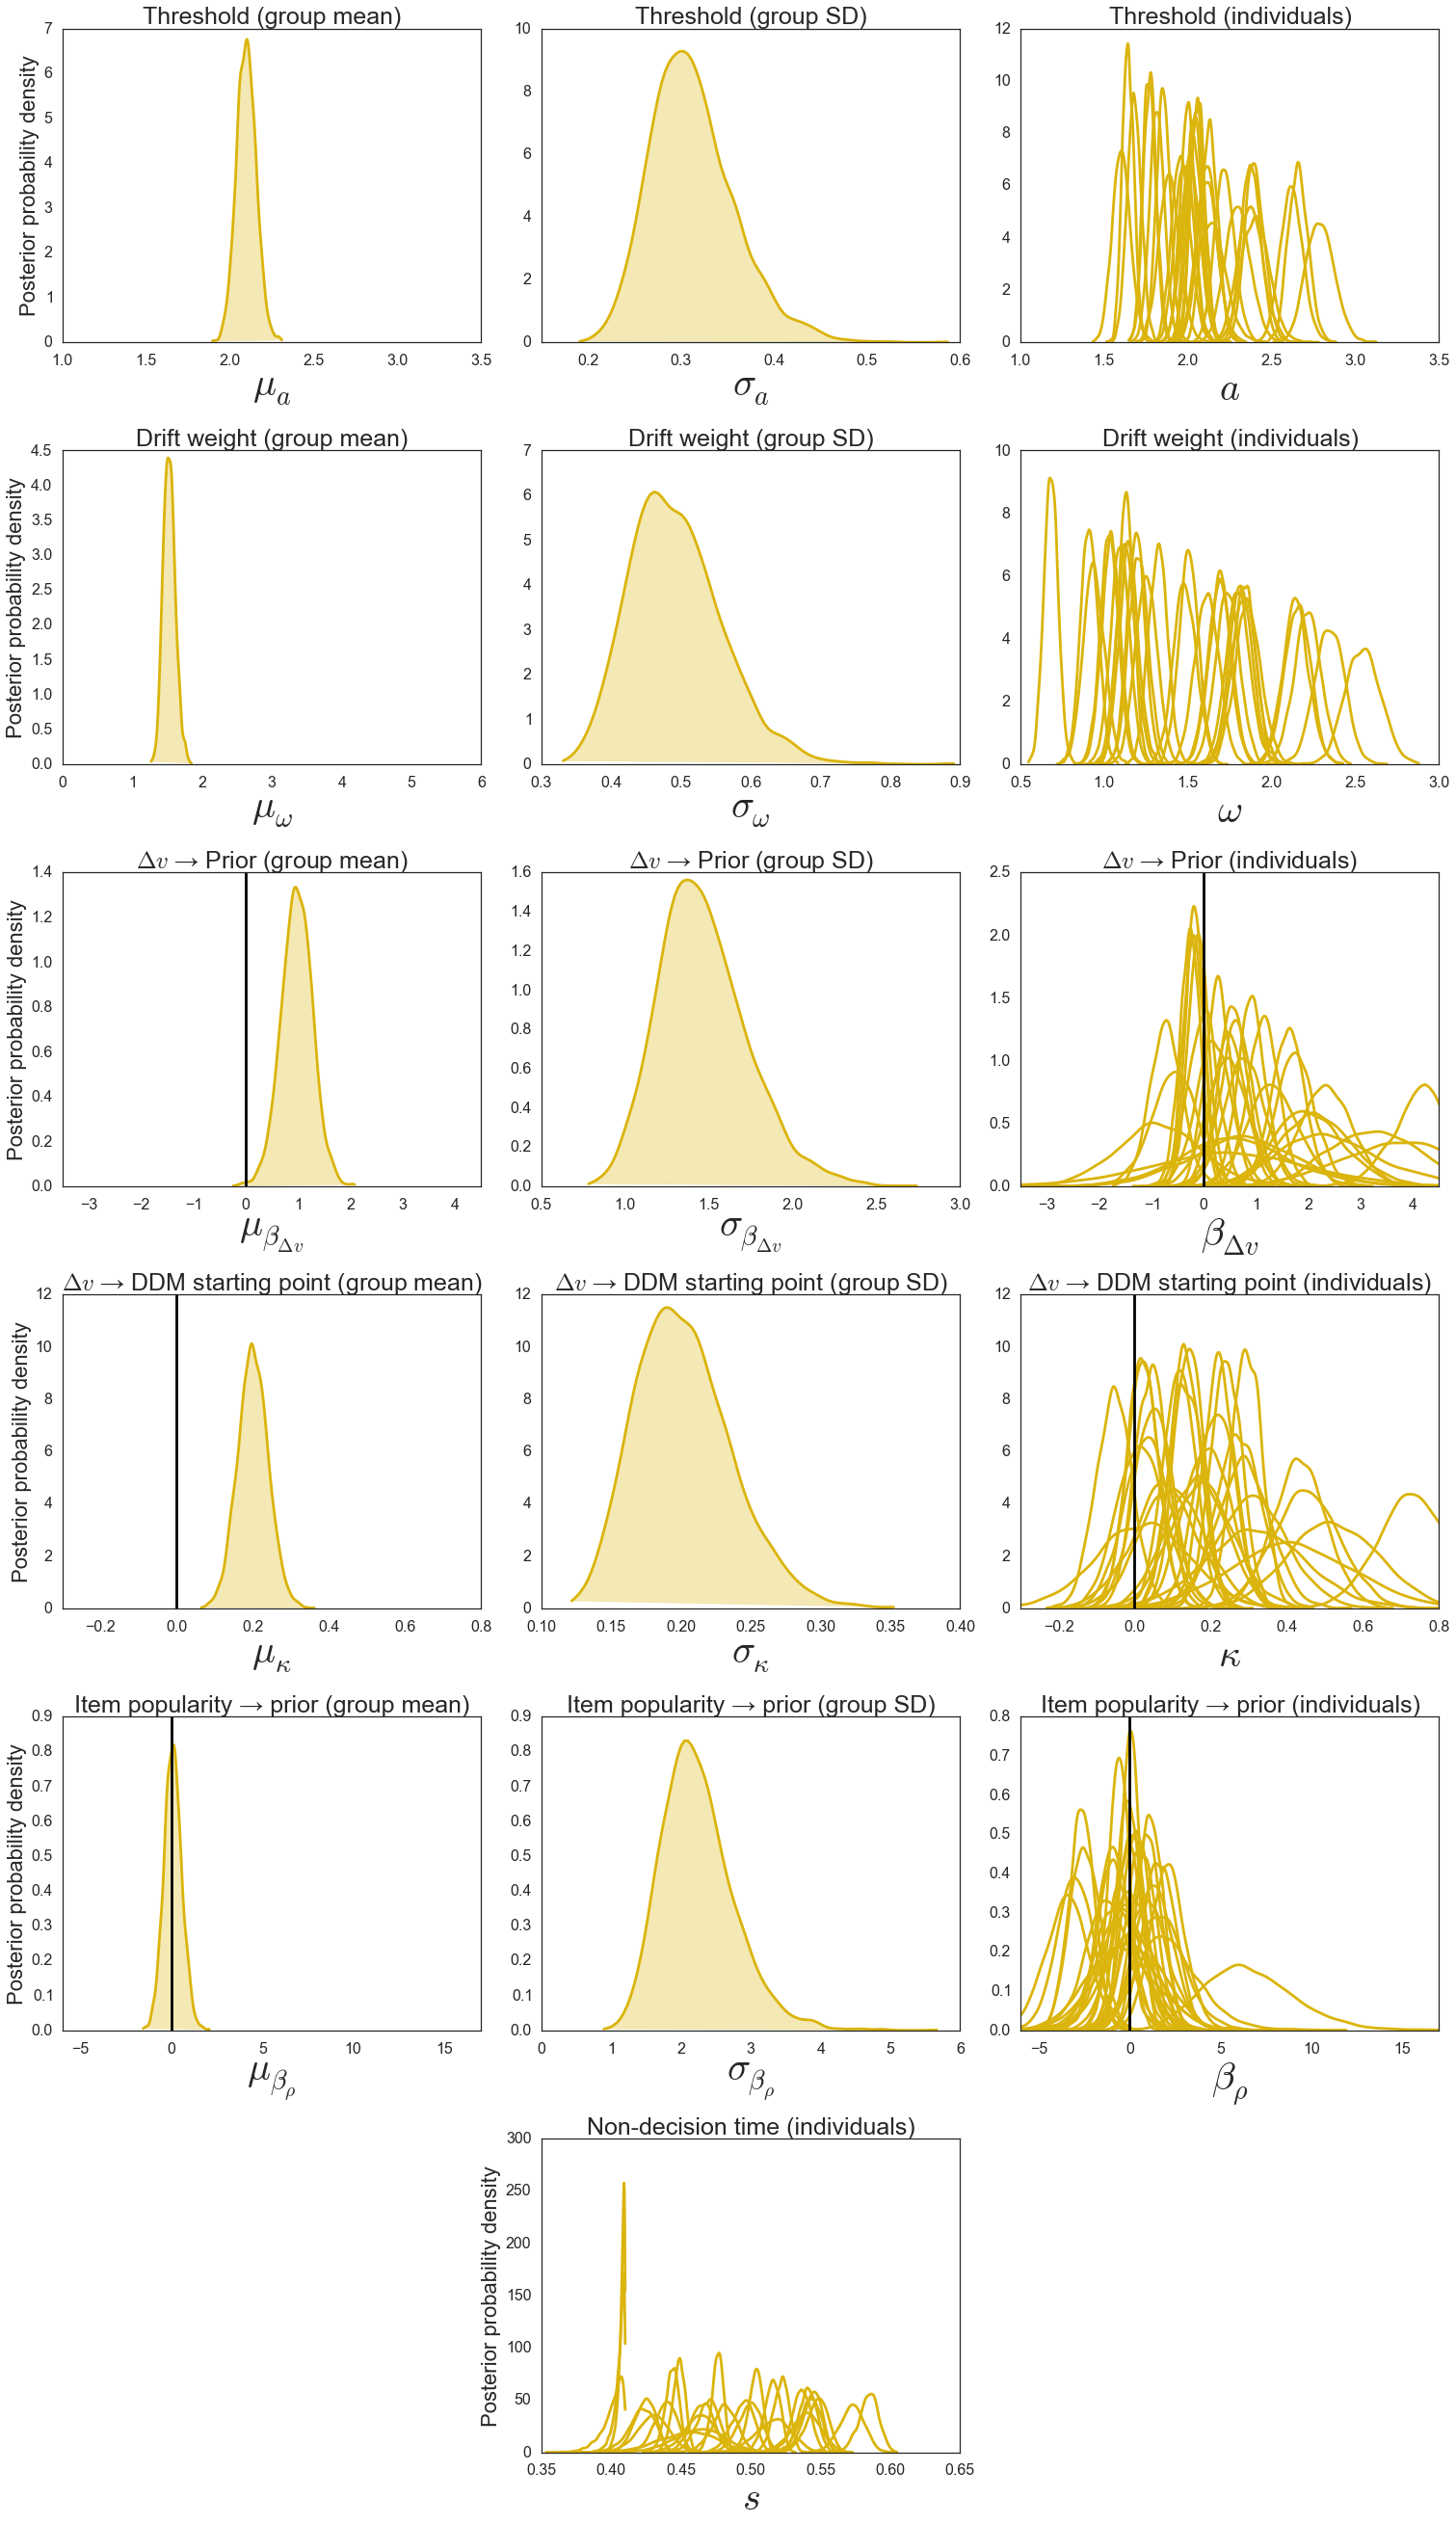

In [73]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (21, 6*6)
fig, ax = pl.subplots(6,3,squeeze=False)
plt.tight_layout(h_pad=4.0)
plt.suptitle(' ', size=24)


# THRESHOLD

param_plot(fit_dual_insight_bayesian_noeye_non_social['threshold_int_mean'], ax[0,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[0,0].set_ylabel('Posterior probability density', size=22)
ax[0,0].set_xlabel('$\\mu_{a}$', size=40)
ax[0,0].set_title('Threshold (group mean)', size=25)
#ax[0,0].axvline(x=0,color='black')
#ax[0,0].spines['right'].set_visible(False)
#ax[0,0].spines['top'].set_visible(False)
#ax[0,0].set_ylim([0,14])
ax[0,0].set_xlim([1,3.5])

param_plot(fit_dual_insight_bayesian_noeye_non_social['threshold_int_sd'], ax[0,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[0,1].set_xlabel('$\\sigma_{a}$', size=40)
ax[0,1].set_title('Threshold (group SD)', size=25)
#ax[0,1].axvline(x=0,color='black')
#ax[0,1].spines['right'].set_visible(False)
#ax[0,1].spines['top'].set_visible(False)
#ax[0,1].set_ylim([0,14])
#ax[0,1].set_xlim([-0.3,0.7])

param_plot(fit_dual_insight_bayesian_noeye_non_social['threshold_int'], ax[0,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0)
ax[0,2].set_xlabel('$a$', size=40)
ax[0,2].set_title('Threshold (individuals)', size=25)
#ax[0,2].axvline(x=0,color='black')
#ax[0,2].set_ylim([0,14])
ax[0,2].set_xlim([1,3.5])
#ax[0,2].spines['right'].set_visible(False)
#ax[0,2].spines['top'].set_visible(False)



# DRIFT WEIGHT

param_plot(fit_dual_insight_bayesian_noeye_non_social['drift_rate_learning_mean'], ax[1,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[1,0].set_ylabel('Posterior probability density', size=22)
ax[1,0].set_xlabel('$\\mu_{\omega}$', size=40)
ax[1,0].set_title('Drift weight (group mean)', size=25)
#ax[1,0].axvline(x=0,color='black')
#ax[1,0].spines['right'].set_visible(False)
#ax[1,0].spines['top'].set_visible(False)
#ax[1,0].set_ylim([0,14])
ax[1,0].set_xlim([0,6])

param_plot(fit_dual_insight_bayesian_noeye_non_social['drift_rate_learning_sd'], ax[1,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[1,1].set_xlabel('$\\sigma_{\omega}$', size=40)
ax[1,1].set_title('Drift weight (group SD)', size=25)
#ax[1,1].axvline(x=0,color='black')
#ax[1,1].spines['right'].set_visible(False)
#ax[1,1].spines['top'].set_visible(False)
#ax[1,1].set_ylim([0,14])
#ax[1,1].set_xlim([-0.3,0.7])

param_plot(fit_dual_insight_bayesian_noeye_non_social['drift_rate_learning'], ax[1,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0)
ax[1,2].set_xlabel('$\\omega$', size=40)
ax[1,2].set_title('Drift weight (individuals)', size=25)
#ax[1,2].axvline(x=0,color='black')
#ax[1,2].set_ylim([0,14])
#ax[1,2].set_xlim([1,3.5])
#ax[1,2].spines['right'].set_visible(False)
#ax[1,2].spines['top'].set_visible(False)




# PRIOR

param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_prior_mean'], ax[2,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[2,0].set_ylabel('Posterior probability density', size=22)
ax[2,0].set_xlabel('$\\mu_{\\beta_{\Delta v}}$', size=40)
ax[2,0].set_title(u'$\Delta v$ \u2192 Prior (group mean)', size=25)
ax[2,0].axvline(x=0,color='black')
#ax[2,0].spines['right'].set_visible(False)
#ax[2,0].spines['top'].set_visible(False)
#ax[2,0].set_ylim([0,14])
ax[2,0].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_prior_sd'], ax[2,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[0,1].set_ylabel('Frequency')
ax[2,1].set_xlabel('$\\sigma_{\\beta_{\Delta v}}$', size=40)
ax[2,1].set_title(u'$\Delta v$ \u2192 Prior (group SD)', size=25)
#ax[2,1].axvline(x=0,color='black')
#ax[2,1].spines['right'].set_visible(False)
#ax[2,1].spines['top'].set_visible(False)
#ax[2,1].set_ylim([0,14])
#ax[2,1].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_prior'], ax[2,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0)
ax[2,2].set_xlabel('$\\beta_{\Delta v}$', size=40)
ax[2,2].set_title(u'$\Delta v$ \u2192 Prior (individuals)', size=25)
ax[2,2].axvline(x=0,color='black')
#ax[2,2].set_ylim([0,14])
ax[2,2].set_xlim([-3.5,4.5])
#ax[2,2].spines['right'].set_visible(False)
#ax[2,2].spines['top'].set_visible(False)





# STARTING POINT BIAS

param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_drift_bias_mean'], ax[3,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[3,0].set_ylabel('Posterior probability density', size=22)
ax[3,0].set_xlabel('$\\mu_{\\kappa}$', size=40)
ax[3,0].set_title(u'$\Delta v$ \u2192 DDM starting point (group mean)', size=25)
ax[3,0].axvline(x=0,color='black')
#ax[3,0].spines['right'].set_visible(False)
#ax[3,0].spines['top'].set_visible(False)
#ax[3,0].set_ylim([0,14])
ax[3,0].set_xlim([-0.3,0.8])

param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_drift_bias_sd'], ax[3,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[3,1].set_ylabel('Frequency')
ax[3,1].set_xlabel('$\\sigma_{\\kappa}$', size=40)
ax[3,1].set_title(u'$\Delta v$ \u2192 DDM starting point (group SD)', size=25)
#ax[3,1].axvline(x=0,color='black')
#ax[3,1].spines['right'].set_visible(False)
#ax[3,1].spines['top'].set_visible(False)
#ax[3,1].set_ylim([0,14])
#ax[3,1].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye_non_social['cong_weight_drift_bias'], ax[3,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0)
ax[3,2].set_xlabel('$\\kappa$', size=40)
ax[3,2].set_title(u'$\Delta v$ \u2192 DDM starting point (individuals)', size=25)
ax[3,2].axvline(x=0,color='black')
#ax[3,2].set_ylim([0,14])
ax[3,2].set_xlim([-0.3,0.8])
#ax[3,2].spines['right'].set_visible(False)
#ax[3,2].spines['top'].set_visible(False)


# ITEM POPULARITY

param_plot(fit_dual_insight_bayesian_noeye_non_social['insight_mean'], ax[4,0], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
ax[4,0].set_ylabel('Posterior probability density', size=22)
ax[4,0].set_xlabel('$\\mu_{\\beta_{\\rho}}$', size=40)
ax[4,0].set_title(u'Item popularity \u2192 prior (group mean)', size=25)
ax[4,0].axvline(x=0,color='black')
#ax[3,0].spines['right'].set_visible(False)
#ax[3,0].spines['top'].set_visible(False)
#ax[3,0].set_ylim([0,14])
ax[4,0].set_xlim([-6,17])

param_plot(fit_dual_insight_bayesian_noeye_non_social['insight_sd'], ax[4,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0.3)
#ax[3,1].set_ylabel('Frequency')
ax[4,1].set_xlabel('$\\sigma_{\\beta_{\\rho}}$', size=40)
ax[4,1].set_title(u'Item popularity \u2192 prior (group SD)', size=25)
#ax[3,1].axvline(x=0,color='black')
#ax[3,1].spines['right'].set_visible(False)
#ax[3,1].spines['top'].set_visible(False)
#ax[3,1].set_ylim([0,14])
#ax[3,1].set_xlim([-3.5,4.5])

param_plot(fit_dual_insight_bayesian_noeye_non_social['insight'], ax[4,2], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0)
ax[4,2].set_xlabel('$\\beta_{\\rho}$', size=40)
ax[4,2].set_title(u'Item popularity \u2192 prior (individuals)', size=25)
ax[4,2].axvline(x=0,color='black')
#ax[3,2].set_ylim([0,14])
ax[4,2].set_xlim([-6,17])
#ax[3,2].spines['right'].set_visible(False)
#ax[3,2].spines['top'].set_visible(False)


# NON-DECISION TIMES

param_plot(fit_dual_insight_bayesian_noeye_non_social['non_decision_time_int'], ax[5,1], color=sns.xkcd_rgb['gold'], fill_color=sns.xkcd_rgb['gold'], alpha=0)
ax[5,1].set_ylabel('Posterior probability density', size=22)
ax[5,1].set_xlabel('$s$', size=40)
ax[5,1].set_title(u'Non-decision time (individuals)', size=25)
#ax[5,1].axvline(x=0,color='black')
#ax[5,1].spines['right'].set_visible(False)
#ax[5,1].spines['top'].set_visible(False)
#ax[5,1].set_ylim([0,14])
#ax[5,1].set_xlim([-3.5,4.5])


# Turn off axes and labels for unused subplots
ax[5,0].spines['right'].set_visible(False)
ax[5,0].spines['left'].set_visible(False)
ax[5,0].spines['top'].set_visible(False)
ax[5,0].spines['bottom'].set_visible(False)
ax[5,0].get_xaxis().set_visible(False)
ax[5,0].get_yaxis().set_visible(False)

ax[5,2].spines['right'].set_visible(False)
ax[5,2].spines['left'].set_visible(False)
ax[5,2].spines['top'].set_visible(False)
ax[5,2].spines['bottom'].set_visible(False)
ax[5,2].get_xaxis().set_visible(False)
ax[5,2].get_yaxis().set_visible(False)



plt.savefig('../figures/supp-fig4-parameter_estimates_complete_dual_insight_bayesian_noeye_non_social.pdf', bbox_inches='tight')

##Figure 4: Drift cartoon mock illustration

In [9]:
def RandomWalk(mu,sd,N=1000, d=2):
    """
    Use numpy.cumsum and numpy.random.uniform to generate
    a 2D random walk of length N, each of which has a random DeltaX and
    DeltaY between -1/2 and 1/2.  You'll want to generate an array of 
    shape (N,d), using (for example), random.uniform(min, max, shape).
    """
    return np.cumsum(np.random.normal(mu,sd,(N,d)))

# Find trace illustrations that hit the boundary at the actual mean RTs

done_cong_correct = False
done_cong_incorrect = False
done_incong_correct = False
done_incong_incorrect = False

while done_cong_correct == False:
    cong_correct = RandomWalk(0.015,0.09)
    if (np.where(cong_correct>2.0)[0][0] > 91.0) & (np.where(cong_correct>2.0)[0][0] < 93.0):
        done_cong_correct = True

while done_cong_incorrect == False:
    cong_incorrect = RandomWalk(-0.015,0.09)
    if (np.where(cong_incorrect<-2.0)[0][0] > 119.5) & (np.where(cong_incorrect<-2.0)[0][0] < 120.5):
        done_cong_incorrect = True
        
while done_incong_correct == False:
    incong_correct = RandomWalk(0.015,0.09)
    if (np.where(incong_correct>2.0)[0][0] > 98.5) & (np.where(incong_correct>2.0)[0][0] < 99.5):
        done_incong_correct = True
    
while done_incong_incorrect == False:
    incong_incorrect = RandomWalk(-0.015,0.09)
    if (np.where(incong_incorrect<-2.0)[0][0] > 98.5) & (np.where(incong_incorrect<-2.0)[0][0] < 100.5):
        done_incong_incorrect = True

# Set first values to starting points
cong_correct[0] = 0
incong_correct[0] = 0
cong_incorrect[0] = 0
incong_incorrect[0] = 0

# Delete all values after threshold is crossed
cong_correct[np.where(cong_correct>2.0)[0][0]+1:]=np.nan
incong_correct[np.where(incong_correct>2.0)[0][0]+1:]=np.nan
cong_incorrect[np.where(cong_incorrect<-2.0)[0][0]+1:]=np.nan
incong_incorrect[np.where(incong_incorrect<-2.0)[0][0]+1:]=np.nan

In [126]:
# done_cong_fast = False
# while done_cong_fast == False:
#     cong_fast = RandomWalk(0.015,0.09)
#     if (np.where(cong_fast>2.0)[0][0] > 91.0) & (np.where(cong_fast>2.0)[0][0] < 93.0):
#         done_cong_fast = True
        
cong_fast[0] = 0
cong_fast[np.where(cong_fast>1.20)[0][0]+1:]=np.nan


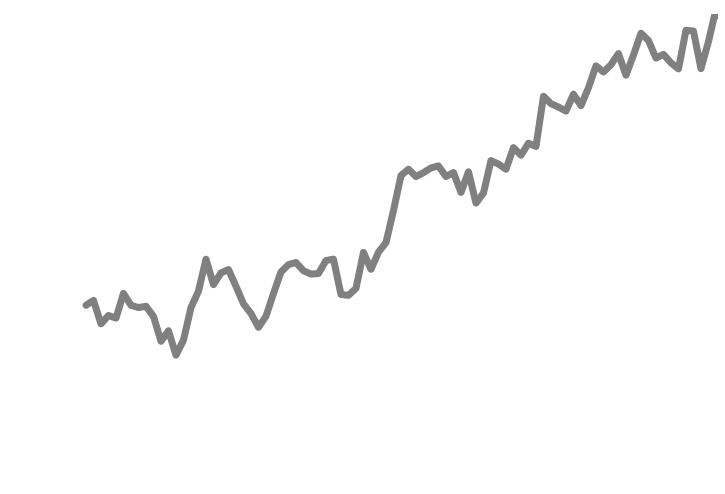

In [47]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (12, 8.0)
fig, ax = plt.subplots()
ax.plot(cong_correct, color='grey', linewidth=7)
#ax.set_axis_bgcolor(sns.xkcd_rgb['light blue grey'])
#plt.plot(incong_correct, color='orange')
#plt.plot(cong_incorrect, color=sns.xkcd_rgb['green'])
#plt.plot(incong_incorrect, color=sns.xkcd_rgb['faded orange'])
ax.set_ylim(-0.8,1.5)
ax.set_xlim(-5,84.28)
ax.axis('off')
plt.savefig('images/figures/drift_cartoon_weak.png')

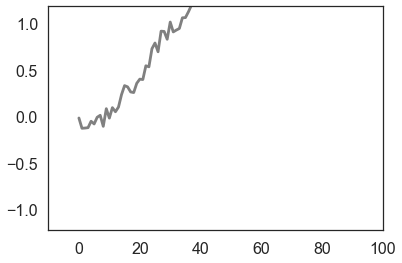

In [130]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (6, 4.0)
fig, ax = plt.subplots()
ax.plot(cong_fast, color='grey')
#ax.set_axis_bgcolor(sns.xkcd_rgb['light blue grey'])
#plt.plot(incong_correct, color='orange')
#plt.plot(cong_incorrect, color=sns.xkcd_rgb['green'])
#plt.plot(incong_incorrect, color=sns.xkcd_rgb['faded orange'])
ax.set_ylim(-1.2,1.2)
ax.set_xlim(-10,100)
plt.savefig('images/figures/drift_cartoon_strong.png')

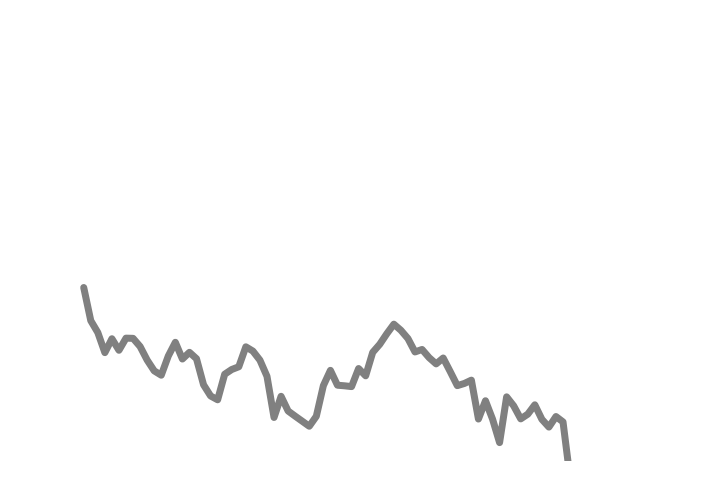

In [48]:
sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (12, 8.0)
fig, ax = plt.subplots()
ax.plot(incong_incorrect, color='grey', linewidth=7)
ax.axis('off')
#ax.set_axis_bgcolor(sns.xkcd_rgb['light blue grey'])
#plt.plot(incong_correct, color='orange')
#plt.plot(cong_incorrect, color=sns.xkcd_rgb['green'])
#plt.plot(incong_incorrect, color=sns.xkcd_rgb['faded orange'])
ax.set_ylim(-0.95,1.5)
ax.set_xlim(-5,90)
plt.savefig('images/figures/drift_cartoon_wrong.png')

##Methods: Participant age information

In [379]:
participant_log = pd.read_excel('../data/participant_log.xlsx')

Social group

In [386]:
# Mean for social group
participant_log[participant_log['Participant ID'].str[0]=='E'].Age.mean()

26.696969696969695

In [385]:
# Standard deviation for social group
participant_log[participant_log['Participant ID'].str[0]=='E'].Age.std()

8.3497187395925518

Non-social group

In [388]:
# Mean for the non-social group
participant_log[participant_log['Participant ID'].str[0]=='C'].Age.mean()

24.828571428571429

In [387]:
# Standard deviation for non-social group
participant_log[participant_log['Participant ID'].str[0]=='C'].Age.std()

6.7147148083878587

Pilot study

In [389]:
participant_log[participant_log['Participant ID'].str[0]=='P']

,Participant ID,Study Phase,Date,Time,Testing Room,Sex,Age,Final Payment,Post-session wait time,Notes
0,P1,Pretest v1.0,2014-10-13,8:00am,424,M,25,29.44,NaN,Did not believe it was a real person's data; f...
1,P2,Pretest v1.0,2014-10-13,4:30pm,424,F,20,30.26,NaN,Black & white questionnaire and instructions
2,P3,Pretest v1.0,2014-10-14,6:00pm,424,M,37,30.19,NaN,Color questionnaire and instructions;
3,P4,Pretest v1.0,2014-10-16,3:00pm,424,F,21,29.84,NaN,Color questionnaire and instructions; thought ...
4,P5,Pretest v1.0,2014-10-17,8:00am,424,M,29,30.54,NaN,Color questionnaire and instructions;
5,P6,Pretest v1.0,2014-10-17,10:30am,424,F,27,30.28,NaN,Color questionnaire and instructions; didn't u...
7,P7,Pretest v1.1,2014-10-23,10:00am,424,F,24,30.01,NaN,"Cart with items during questionnaire, bid and ..."
8,P8,Pretest v1.1,2014-10-23,12:30pm,424,F,19,27.89,NaN,"Cart with items during quesitonnaire, bid and ..."
9,P9,Pretest v1.1,2014-10-23,5:30pm,424,F,27,30.24,NaN,"Cart with items during questionnaire, bid, cho..."
10,P10,Pretest v1.1,2014-10-24,10:00am,424,F,30,30.43,NaN,"Cart with items during questionnaire, bid, and..."


In [390]:
# Standard deviation for social group
participant_log[participant_log['Participant ID'].str[0]=='P'].Age.std()

5.1138552141720979

##Supplementary Table 23: Pilot participant analysis

In [391]:
pilot_data = pd.read_pickle('../data/social_pilot/data_processed_social_pilot_wexclusions.pkl')

In [393]:
%Rpush pilot_data

In [394]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), pilot_data, binomial) 
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), pilot_data, binomial) 
print(anova(logitmodel_withchoice,logitmodel_null))
print(summary(logitmodel_withchoice))

Data: pilot_data
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 4981.0 5001.4 -2487.5   4975.0              
logitmodel_withchoice  4 4930.1 4957.3 -2461.1   4922.1 52.821      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  3.655e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
  4930.1   4957.3  -2461.1   4922.1     6596 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8313  0.2181  0.3142  0.4346  1.1576 

Random effects:
 

####Trials 1-10

In [395]:
pilot_data_first10 = pilot_data[pilot_data.pair_rep<11]
%Rpush pilot_data_first10

In [396]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), pilot_data_first10, binomial) 
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), pilot_data_first10, binomial) 
print(anova(logitmodel_withchoice,logitmodel_null))
print(summary(logitmodel_withchoice))

Data: pilot_data_first10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 2273.7 2290.8 -1133.8   2267.7              
logitmodel_withchoice  4 2250.2 2273.0 -1121.1   2242.2 25.517      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  4.386e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: pilot_data_first10

     AIC      BIC   logLik deviance df.resid 
  2250.2   2273.0  -1121.1   2242.2     2196 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9480  0.2835  0.4280  0.5953  1.0868 

R

####Trials 11-20

In [397]:
pilot_data_middle10 = pilot_data[(pilot_data.pair_rep>10)&(pilot_data.pair_rep<21)]
%Rpush pilot_data_middle10

In [398]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), pilot_data_middle10, binomial) 
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), pilot_data_middle10, binomial) 
print(anova(logitmodel_withchoice,logitmodel_null))
print(summary(logitmodel_withchoice))

Data: pilot_data_middle10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 1301.0 1318.1 -647.52   1295.0              
logitmodel_withchoice  4 1293.8 1316.5 -642.88   1285.8 9.2752      1
                      Pr(>Chisq)   
logitmodel_null                    
logitmodel_withchoice   0.002323 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: pilot_data_middle10

     AIC      BIC   logLik deviance df.resid 
  1293.8   1316.6   -642.9   1285.8     2196 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.7843  0.1790  0.2671  0.3391  0.8008 

Ra

####Trials 21-30

In [399]:
pilot_data_last10 = pilot_data[pilot_data.pair_rep>20]
%Rpush pilot_data_last10

In [400]:
%%R
logitmodel_null <- glmer(response_correct ~ 1+pair_rep+(1|participant), pilot_data_last10, binomial) 
logitmodel_withchoice <- glmer(response_correct ~ 1+pair_rep+inf_bid_dv+(1|participant), pilot_data_last10, binomial) 
print(anova(logitmodel_withchoice,logitmodel_null))
print(summary(logitmodel_withchoice))

Data: pilot_data_last10
Models:
logitmodel_null: response_correct ~ 1 + pair_rep + (1 | participant)
logitmodel_withchoice: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
logitmodel_null        3 1217.1 1234.2 -605.56   1211.1              
logitmodel_withchoice  4 1199.9 1222.7 -595.94   1191.9 19.257      1
                      Pr(>Chisq)    
logitmodel_null                     
logitmodel_withchoice  1.143e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: response_correct ~ 1 + pair_rep + inf_bid_dv + (1 | participant)
   Data: pilot_data_last10

     AIC      BIC   logLik deviance df.resid 
  1199.9   1222.7   -595.9   1191.9     2196 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.7922   0.0960   0.2335   0.3545   0.

##Figure 2: Data/model prediction plots

In [57]:
control_data_rt[(control_data_rt.inf_bid_dv>0)].infer_resp_rt.mean()

1.1567645022506661

In [58]:
control_data_rt[(control_data_rt.inf_bid_dv<0)].infer_resp_rt.mean()

1.2002481220285928

In [59]:
data_rt[(data_rt.inf_bid_dv>0)].infer_resp_rt.mean()

1.0864458606164489

In [60]:
data_rt[(data_rt.inf_bid_dv<0)].infer_resp_rt.mean()

1.159406759259441

In [32]:
# SOCIAL (DUAL INFLUENCE w/INSIGHT, BAYESIAN, NO GAZE BIAS)

# Generate model predictions from Stan fit
fit_dual_insight_bayesian_noeye_df = pd.DataFrame(fit_dual_insight_bayesian_noeye['log_lik_resp']).transpose()

pred_data_social = merged_data2.copy()
pred_data_social = pred_data_social[pred_data_social['block_loop_thisN'].notnull() & pred_data_social['img_correct'].notnull()]
pred_data_social = pred_data_social.reset_index(drop=True)

pred_data_social['lik_fit_dual_insight_bayesian_noeye'] = np.exp(fit_dual_insight_bayesian_noeye_df.mean(axis=1))
pred_data_social.loc[(pred_data_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye'] = pred_data_social['lik_fit_dual_insight_bayesian_noeye']
pred_data_social.loc[(pred_data_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye'] = 1 - pred_data_social['lik_fit_dual_insight_bayesian_noeye']

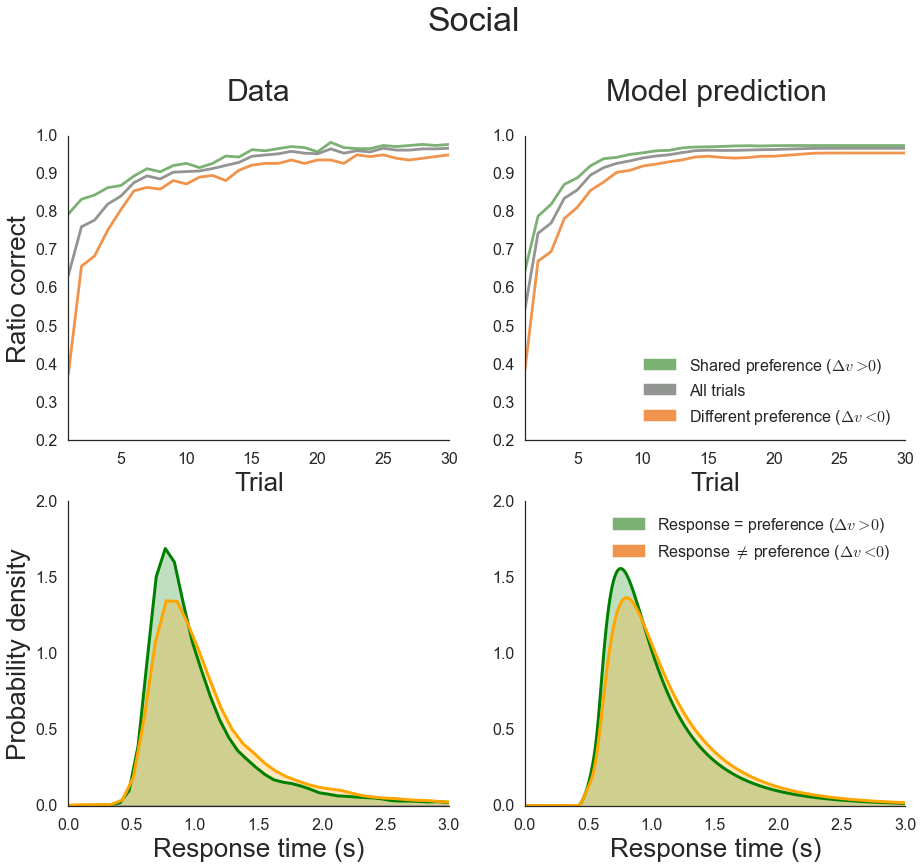

In [105]:
# Code for plot
model_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()
model_means_all = pred_data_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye.mean()

data_means_cong = pred_data_social[pred_data_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong = pred_data_social[pred_data_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all = pred_data_social.groupby(['pair_rep']).response_correct.mean()

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Different preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
tot_patch = mpatches.Patch(color=sns.xkcd_rgb['grey'], label='All trials')

sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

pl.rcParams['figure.figsize'] = (15.0, 12.0) # Make the inline plot image bigger
plt.suptitle('Social', size=34, y=1.05)

ax1 = plt.subplot(221)
plt.plot(range(1,31),data_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),data_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),data_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Data', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
plt.ylabel('Ratio correct', fontsize=26)
#plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = plt.subplot(222)
plt.plot(range(1,31),model_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),model_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),model_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Model prediction', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
#plt.ylabel('Ratio correct', fontsize=26)
plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Response $\\neq$ preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Response = preference ($\Delta v> 0$)')

ax3 = plt.subplot(223)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==1)].infer_resp_rt, color='green', shade=True, linewidth=3, legend=False)
sns.kdeplot(data_rt[(data_rt.response_matches_preference_bid==0)].infer_resp_rt, color='orange', shade=True, linewidth=3, legend=False)
ax3.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
plt.ylabel('Probability density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
#plt.legend(handles=[con_patch, in_patch], loc=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = plt.subplot(224)
plt.plot(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), color='green', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_cong_all_social.mean(axis=0), alpha=0.25, color='green')
plt.plot(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), color='orange', linewidth=3)
plt.fill(np.arange(0,10.58,0.01), pdfs_incong_all_social.mean(axis=0), alpha=0.25, color='orange')
ax4.set(xlim=(0, 3))
#ax4.set_title('Data',fontsize=30)
plt.xlabel('Response time (s)', fontsize=26)
#plt.ylabel('Probability Density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
plt.legend(handles=[con_patch, in_patch], loc=1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.savefig('../figures/fig2a-model_prediction_dual_insight_social.pdf', bbox_inches='tight')

In [103]:
len(pred_data_social[pred_data_social['inf_bid_dv']>0])

10830

In [403]:
len(pred_data_social[pred_data_social['inf_bid_dv']<0])

6660

In [404]:
len(pred_data_non_social[pred_data_non_social['inf_bid_dv']>0])

9510

In [405]:
len(pred_data_non_social[pred_data_non_social['inf_bid_dv']<0])

7470

In [359]:
fit_dual_insight_bayesian_noeye_non_social_df = pd.DataFrame(fit_dual_insight_bayesian_noeye_non_social['log_lik_resp']).transpose()

pred_data_non_social = control_data.copy()
pred_data_non_social = pred_data_non_social[pred_data_non_social['block_loop_thisN'].notnull() & pred_data_non_social['img_correct'].notnull()]
pred_data_non_social = pred_data_non_social.reset_index(drop=True)

pred_data_non_social['lik_fit_dual_insight_bayesian_noeye_non_social'] = np.exp(fit_dual_insight_bayesian_noeye_non_social_df.mean(axis=1))
pred_data_non_social.loc[(pred_data_non_social['response_correct']==1),'pred_fit_dual_insight_bayesian_noeye_non_social'] = pred_data_non_social['lik_fit_dual_insight_bayesian_noeye_non_social']
pred_data_non_social.loc[(pred_data_non_social['response_correct']==0),'pred_fit_dual_insight_bayesian_noeye_non_social'] = 1 - pred_data_non_social['lik_fit_dual_insight_bayesian_noeye_non_social']


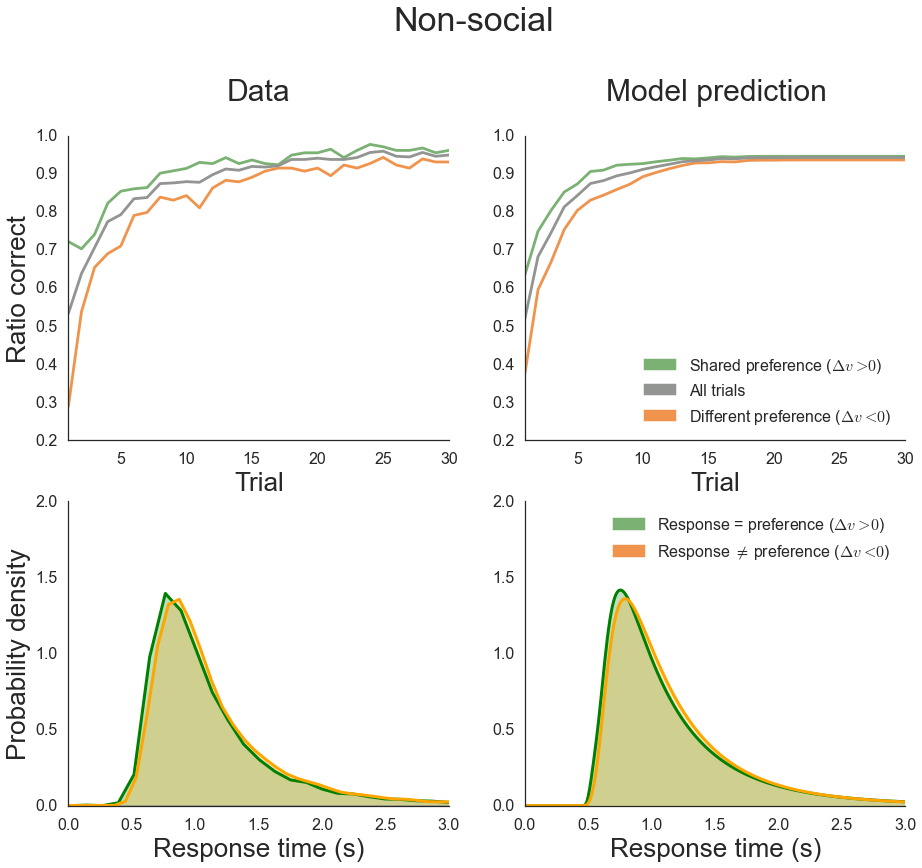

In [106]:
# Code for plot
model_means_cong = pred_data_non_social[pred_data_non_social['inf_bid_dv']>0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye_non_social.mean()
model_means_incong = pred_data_non_social[pred_data_non_social['inf_bid_dv']<0].groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye_non_social.mean()
model_means_all = pred_data_non_social.groupby(['pair_rep']).pred_fit_dual_insight_bayesian_noeye_non_social.mean()

data_means_cong = pred_data_non_social[pred_data_non_social['inf_bid_dv']>0].groupby(['pair_rep']).response_correct.mean()
data_means_incong = pred_data_non_social[pred_data_non_social['inf_bid_dv']<0].groupby(['pair_rep']).response_correct.mean()
data_means_all = pred_data_non_social.groupby(['pair_rep']).response_correct.mean()

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Different preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Shared preference ($\Delta v> 0$)')
tot_patch = mpatches.Patch(color=sns.xkcd_rgb['grey'], label='All trials')

sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})

pl.rcParams['figure.figsize'] = (15.0, 12.0) # Make the inline plot image bigger
plt.suptitle('Non-social', size=34, y=1.05)

ax1 = plt.subplot(221)
plt.plot(range(1,31),data_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),data_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),data_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Data', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
plt.ylabel('Ratio correct', fontsize=26)
#plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.subplot(222)
plt.plot(range(1,31),model_means_cong, color=sns.xkcd_rgb['faded green']), plt.plot(range(1,31),model_means_incong, color=sns.xkcd_rgb['faded orange']), plt.plot(range(1,31),model_means_all, color=sns.xkcd_rgb['grey'])
plt.axis([1,30,0.2,1])
plt.title('Model prediction', fontsize=30, y=1.1)
plt.xlabel('Trial', fontsize=26)
#plt.ylabel('Ratio correct')
plt.legend(handles=[con_patch, tot_patch, in_patch], loc=4)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

in_patch = mpatches.Patch(color=sns.xkcd_rgb['faded orange'], label='Response $\\neq$ preference ($\Delta v< 0$)')
con_patch = mpatches.Patch(color=sns.xkcd_rgb['faded green'], label='Response = preference ($\Delta v> 0$)')

ax3 = plt.subplot(223)
sns.kdeplot(control_data_rt[(control_data_rt.response_matches_preference_bid==1)].infer_resp_rt, color='green', shade=True, linewidth=3, legend=False)
sns.kdeplot(control_data_rt[(control_data_rt.response_matches_preference_bid==0)].infer_resp_rt, color='orange', shade=True, linewidth=3, legend=False)
ax4.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
plt.ylabel('Probability density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
#plt.legend(handles=[con_patch, in_patch], loc=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = plt.subplot(224)
plt.plot(np.arange(0,15.52,0.01), pdfs_cong_all_non_social.mean(axis=0), color='green', linewidth=3)
plt.fill(np.arange(0,15.52,0.01), pdfs_cong_all_non_social.mean(axis=0), alpha=0.25, color='green')
plt.plot(np.arange(0,15.52,0.01), pdfs_incong_all_non_social.mean(axis=0), color='orange', linewidth=3)
plt.fill(np.arange(0,15.52,0.01), pdfs_incong_all_non_social.mean(axis=0), alpha=0.25, color='orange')
ax4.set(xlim=(0, 3))
plt.xlabel('Response time (s)', fontsize=26)
#plt.ylabel('Probability Density',fontsize=26)
plt.axis([0,3,0,2])
#plt.title('Social', size=34, position=[0.5,1.05])
plt.legend(handles=[con_patch, in_patch], loc=1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)


plt.savefig('../figures/fig2b-model_prediction_dual_insight_non_social.pdf', bbox_inches='tight')